# PAO-EquiML

In [94]:
import logging
import torch
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import colormaps
from torch_cluster import radius_graph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_scatter import scatter
from torch.utils.data import Dataset

from e3nn import o3
from e3nn.nn import FullyConnectedNet, Gate, models
from e3nn.o3 import FullyConnectedTensorProduct
from e3nn.math import soft_one_hot_linspace
from e3nn.util.test import assert_equivariant
from e3nn.nn.models.gate_points_2101 import Network

from pathlib import Path
from pao_file_utils import parse_pao_file, append_samples, write_pao_file, read_cp2k_energy

from sklearn.model_selection import train_test_split

t = torch.tensor

In [95]:
change_of_coord = t([
    # this specifies the change of basis yzx -> xyz
    [0., 0., 1.],
    [1., 0., 0.],
    [0., 1., 0.]
])
prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
}
pao_basis_size = 4

In [96]:
class PAO_Object:
    def __init__(self, kind, atomkind, coords, xblock):
        self.kind = kind
        self.atomkind = atomkind
        self.coords = coords
        self.xblock = xblock
        U, S, Vh = torch.linalg.svd(xblock, full_matrices=False)
        self.label = Vh
        
    def swap(self, idx, jdx):
        idxs = list(range(len(self.coords)))
        idxs[idx], idxs[jdx] = idxs[jdx], idxs[idx]
        coords_swap = self.coords.clone().detach()
        atomkind_swap = self.atomkind.copy()
        index = torch.LongTensor(idxs)
        coords_swap[index] = self.coords
        atomkind_swap[idx], atomkind_swap[jdx] = atomkind_swap[jdx], atomkind_swap[idx]
        self.coords = coords_swap
        self.atomkind = atomkind_swap

class PAO_dataset(Dataset):
    def __init__(self, pao_objects):
        self.labels = [pao_object.label for pao_object in pao_objects]
        self.atomkinds = [generate_f_in(pao_object) for pao_object in pao_objects]
        self.coords = [pao_object.coords for pao_object in pao_objects]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        coords = self.coords[idx]
        label = self.labels[idx]
        atomkind = self.atomkinds[idx]
        return coords, atomkind, label

# Torch Module for PAO learning
class PAO_model(torch.nn.Module):
    def __init__(self, max_radius, num_layers, num_neighbours, pao_basis_size, prim_basis_spec, prim_basis_size, irreps_input, irreps_sh, irreps_output):
        super(PAO_model, self).__init__()
        change_of_coord = t([
            [0., 0., 1.],
            [1., 0., 0.],
            [0., 1., 0.]
        ]) 
        self.dim = prim_basis_size
        self.max_radius = max_radius
        self.num_distances = 10
        self.num_neighbours = num_neighbours
        self.pao_basis_size = pao_basis_size
        self.prim_basis_spec = prim_basis_spec
        self.prim_basis_size = prim_basis_size
        self.irreps_sh = irreps_sh
        
        irreps_mid = o3.Irreps([(5, (l, p)) for l in range(2 + 1) for p in [-1, 1]])
        self.irreps_mid = irreps_mid
        self.lin1 = o3.Linear(irreps_sh, irreps_sh)
        self.irreps_output = irreps_output
        self.tp =  o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_mid, shared_weights=False)
        self.lin2 = o3.Linear(irreps_mid, irreps_mid)
        self.tp_out = o3.FullyConnectedTensorProduct(irreps_mid, irreps_mid, irreps_output, shared_weights=True)

        self.num_layers = num_layers
        self.fc = FullyConnectedNet([self.num_distances, num_layers, self.tp.weight_numel], torch.nn.functional.silu)
        self.coord_change = self.tp_out.irreps_out.D_from_matrix(change_of_coord)

        idx_in = []
        aux_H_idx_in = 2*t(prim_basis_spec.ls)+1 
        self.wigner_dict = {}

        for idx, mu_i in enumerate(prim_basis_spec.ls):
            # Spherical Harmonic Factor 2
            for jdx, mu_j in enumerate(prim_basis_spec.ls[idx:]):
                # Contraction contribution of Spherical Harmonic with L={|L1-L2|...L1+L2}
                for mu_ij in range(abs(mu_i-mu_j),mu_i+mu_j+1):
                    # Check parity (even*even=even, odd*odd=even, even*odd=odd) and generate wigner matrix only for match
                    if mu_i%2==mu_j%2 and mu_ij%2==0 or mu_i%2!=mu_j%2 and mu_ij%2==1:
                        idx_in.append(2*mu_ij+1)
                        wigner_m = o3.wigner_3j(mu_i, mu_j, mu_ij)
                        wig_zero_factor = wigner_m[(2*mu_i+1)//2,(2*mu_j+1)//2,(2*mu_ij+1)//2]
                        wigner_m = wig_zero_factor*wigner_m
                        self.wigner_dict[f"{mu_i}{mu_j}{mu_ij}"] = wigner_m.clone()

        idx_in = t(idx_in)
        self.idx_out = torch.cumsum(idx_in, dim=0, dtype=int)              # rh-index into pred-vector
        self.aux_H_idx_out = torch.cumsum(aux_H_idx_in, dim=0, dtype=int)    # rh-index into auxiliary Hamiltonian
        self.idx_in = self.idx_out-idx_in                                    # lh-index of pred-vector
        self.aux_H_idx_in = self.aux_H_idx_out-aux_H_idx_in                  # lh-index into auxiliary Hamiltonian


    def pred_to_pao(self, pred):
        aux_H = torch.zeros((self.prim_basis_spec.dim,self.prim_basis_spec.dim))        # auxiliary Hamiltonian
        jdx_shift = 0

        # Spherical Harmonic Factor 1
        for idx, mu_i in enumerate(self.prim_basis_spec.ls):
            # Spherical Harmonic Factor 2
            for jdx, mu_j in enumerate(self.prim_basis_spec.ls[idx:]):
                # Contraction contribution of Spherical Harmonic with L={|L1-L2|...L1+L2}
                for mu_ij in range(abs(mu_i-mu_j),mu_i+mu_j+1):
                    # Check parity (even*even=even, odd*odd=even, even*odd=odd) and calculate coefficients only for match
                    if mu_i%2==mu_j%2 and mu_ij%2==0 or mu_i%2!=mu_j%2 and mu_ij%2==1:
                        # Contraction per shell
                        contraction_coefficients = torch.matmul(self.wigner_dict[f"{mu_i}{mu_j}{mu_ij}"], pred[self.idx_in[jdx_shift]:self.idx_out[jdx_shift]])
                        # Add shell contribution to resp. block in the auxiliary Hamiltionan
                        aux_H[self.aux_H_idx_in[idx]:self.aux_H_idx_out[idx],self.aux_H_idx_in[jdx+idx]:self.aux_H_idx_out[jdx+idx]] = aux_H[self.aux_H_idx_in[idx]:self.aux_H_idx_out[idx],self.aux_H_idx_in[jdx+idx]:self.aux_H_idx_out[jdx+idx]]  + contraction_coefficients 
                        if idx!=idx+jdx: # also add transform of non-diagonal blocks
                            aux_H[self.aux_H_idx_in[jdx+idx]:self.aux_H_idx_out[jdx+idx],self.aux_H_idx_in[idx]:self.aux_H_idx_out[idx]] = aux_H[self.aux_H_idx_in[jdx+idx]:self.aux_H_idx_out[jdx+idx],self.aux_H_idx_in[idx]:self.aux_H_idx_out[idx]] + contraction_coefficients.T 
                        jdx_shift += 1
        L, Q = torch.linalg.eigh(aux_H)
        pao_vectors = Q[:,:self.pao_basis_size].T
        return pao_vectors

    def forward(self, data):
        edge_vec = data.pos
        f_in = data.z
        sh = o3.spherical_harmonics(self.irreps_sh, edge_vec, normalize=True, normalization='component')
        emb = soft_one_hot_linspace(x=edge_vec.norm(dim=1), start=0.0, end=self.max_radius, number=self.num_distances, 
                                    basis='smooth_finite', cutoff=True).mul(self.num_distances**0.5)
        x = self.lin1(sh)
        aux_H = self.tp(f_in, x, self.fc(emb)).sum(dim=0).div(self.num_neighbours**0.5)
        aux_H = self.lin2(aux_H)
        aux_H = self.tp_out(aux_H, aux_H)
        aux_H = torch.matmul(aux_H, self.coord_change)
        pao_vectors = self.pred_to_pao(aux_H)
        return pao_vectors

In [97]:
def parse_pao_file_torch(path: Path):
    kinds, atom2kind, coords, xblocks = parse_pao_file(path)
    return kinds, atom2kind, t(coords, dtype=torch.float32), [t(x, dtype=torch.float32) for x in xblocks]
    
def atom_number(atomkind):
    f_in = t([[1] if k=="H" else [8] for k in atomkind], dtype=torch.float32)
    return f_in

def generate_f_in(atomkind):  
    f_in = t([(k=="H", k=="O") for k in atomkind], dtype=torch.float32)
    return f_in

# Remove central atom and create PAO object from PAO file
def generate_pao_object_from_file(file_path):
    pao_objects = []
    kinds, atom2kind, coords, xblocks = parse_pao_file_torch(file_path)

    for idx, atom in enumerate(atom2kind):
        rel_coords = coords - coords[idx]
        idxs = list(range(len(atom2kind)))
        idxs.pop(idx)
        atomkind = [atom2kind[atom] for atom in idxs]
#        f_in = atom_number(atomkind)
#        f_in = f_in/f_in.norm(dim=0)
        f_in = generate_f_in([atom2kind[atom] for atom in idxs])
        pao_objects.append(PAO_Object(kinds[atom], f_in, rel_coords[idxs], xblocks[idx]))
    return pao_objects

def generate_irreps_output(pao_basis_size, atom_species):
    prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
    }
    prim_basis_spec = prim_basis_specs[atom_species]
    prim_basis_size = o3.Irreps(prim_basis_spec).dim
    irreps_output = o3.Irreps(" + ".join(pao_basis_size*[prim_basis_spec]))
    return irreps_output

### Read PAO files for dataset generation

In [113]:
pao_objects = []
pao_objects.extend(generate_pao_object_from_file(Path(f"2H2O_rotations/rand_10/2H2O_pao44-1_0.pao")))
#for i in range(0,2001,25):
#    pao_objects.extend(generate_pao_object_from_file(Path(f"2H2O_MD/frame_{i:04d}/2H2O_pao44-1_0.pao")))

pao_objects_O = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==8]
pao_objects_H = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==1]
kinds, atom2kind, coords, _ = parse_pao_file_torch(Path("2H2O_rotations/rand_10/2H2O_pao44-1_0.pao"))

In [112]:
# Loss functions.

def loss_function_ortho_projector_batch(pred, label):
    pred_projector = torch.bmm(torch.transpose(pred, dim0=1, dim1=2), pred)
    label_projector = torch.bmm(torch.transpose(label, dim0=1, dim1=2), label)
    residual = pred_projector - label_projector
    return residual.pow(2).mean()

def loss_function_ortho_projector(pred, label):
    pred_projector = pred.T @ pred
    label_projector = label.T @ label
    proj_residual = pred_projector - label_projector
    return proj_residual.pow(2).mean()

## PAO-Model Oxygen

In [100]:
# Irreps Input
irreps_input = o3.Irreps("2x0e") # features: is_hydrogen, is_oxygen

# Irreps Spherical Harmonics
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)

# Primitive Basis specs

prim_basis_spec = o3.Irreps(prim_basis_specs["O"])
prim_basis_size = o3.Irreps(prim_basis_spec).dim

# Irreps Output
# ss ss'  sp  sp'  sd
#    s's' s'p s'p' s'd
#         pp  pp'  pd
#             p'p' p'd
#                  dd
# This will be changed since the required spherical harmonics can be also evaluated via
# o3.ReducedTensorProduct as part of the model based on prim_basis_spec. Main issue to be dealt
# with is the ordering: ReducedTensorProduct returns spherical harmonics ordered according to angular momentum.
# E.g. "7x0e + 6x1o + 6x2e + 2x3o + 1x4e" for O with prim_basis_spec "2x0e + 2x1o + 1x2e"
irreps_output = o3.Irreps(
            "2x0e+2x1o+1x2e+\
             1x0e+2x1o+1x2e+\
             1x0e+1x2e+1x0e+1x2e+1x1o+1x3o+\
             1x0e+1x2e+1x1o+1x3o+\
             1x0e+1x2e+1x4e")

In [101]:
batch_size = 1
data_O = []

for pao_object in pao_objects_O:
    data_O += [
        Data(
            x=None, pos=pao_object.coords, y=pao_object.label, z=pao_object.atomkind
        )
    ]

#train_data_O, test_data_O = train_test_split(data_O, test_size=0.2)
#train_loader_O = DataLoader(
#    train_data_O, batch_size=batch_size, shuffle=True
#)

In [102]:
max_radius = 4.0
num_neighbours = 5
model_O = PAO_model(
    max_radius=max_radius,
    num_layers=32,
    num_neighbours=num_neighbours,
    pao_basis_size=pao_basis_size,
    prim_basis_spec=prim_basis_spec,
    prim_basis_size=prim_basis_size, 
    irreps_input=irreps_input,
    irreps_sh=irreps_sh,
    irreps_output=irreps_output
)

/Users/Vincente/anaconda3/envs/e3nn/lib/python3.11/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [103]:
# Train the model.
optim = torch.optim.Adam(model_O.parameters(), lr=1e-3)
train_loss_O = []
        
for step in range(5001):
    optim.zero_grad()
    temp_loss = 0
    loss_string = ""
    i = 0
    for x in data_O:
        label = x.y
        pred = model_O(x)
        loss = loss_function_ortho_projector(pred, label)
        loss.backward()
        if step % 100 == 0:
            loss_string += (f"  {loss:.8e}")
            temp_loss += loss.detach()
            i+=1
    optim.step()
    if step % 100 == 0:
        temp_loss /= i
        train_loss_O.append(temp_loss)
        print(f"training {step:5d} | loss {loss_string}")

training     0 | loss   3.47656123e-02  2.84046289e-02
training   100 | loss   6.42036460e-03  1.40874963e-02
training   200 | loss   5.05694421e-04  3.04594333e-03
training   300 | loss   1.75932713e-04  1.08474269e-04
training   400 | loss   6.33653108e-05  4.47780913e-05
training   500 | loss   3.46163106e-05  2.97360202e-05
training   600 | loss   2.51820056e-05  2.11143633e-05
training   700 | loss   1.95281336e-05  1.52489511e-05
training   800 | loss   1.56011447e-05  1.10537267e-05
training   900 | loss   1.27421863e-05  8.09090307e-06
training  1000 | loss   1.05888375e-05  6.05505693e-06
training  1100 | loss   8.90697538e-06  4.67219343e-06
training  1200 | loss   7.55834890e-06  3.71971782e-06
training  1300 | loss   6.46594253e-06  3.04094942e-06
training  1400 | loss   5.58118654e-06  2.53631993e-06
training  1500 | loss   4.86566933e-06  2.14595866e-06
training  1600 | loss   4.28558587e-06  1.83425811e-06
training  1700 | loss   3.81147061e-06  1.57958732e-06
training  

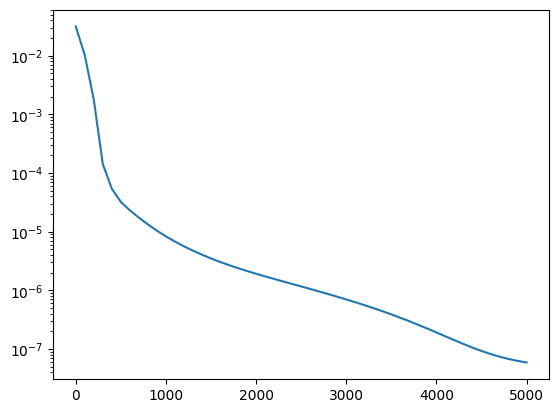

In [104]:
plt.plot(list(range(0, 5001,100)), train_loss_O)
plt.yscale("log")
plt.show()

In [105]:
torch.save(model_O.state_dict(), "./model_O_hamil.param")

In [115]:
test_pao_objects = []
for i in range(0,20,2):
    test_pao_objects.extend(generate_pao_object_from_file(Path(f"2H2O_rotations/rand_{i:02d}/2H2O_pao44-1_0.pao")))

test_pao_objects_O = [pao_object for pao_object in test_pao_objects if pao_object.kind.atomic_number==8]
test_pao_objects_H = [pao_object for pao_object in test_pao_objects if pao_object.kind.atomic_number==1]
kinds, atom2kind, coords, _ = parse_pao_file_torch(Path("2H2O_rotations/rand_10/2H2O_pao44-1_0.pao"))

test_data_O= []
for pao_object in test_pao_objects_O:
    test_data_O += [
        Data(
            x=None, pos=pao_object.coords, y=pao_object.label, z=pao_object.atomkind
        )
    ]

tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


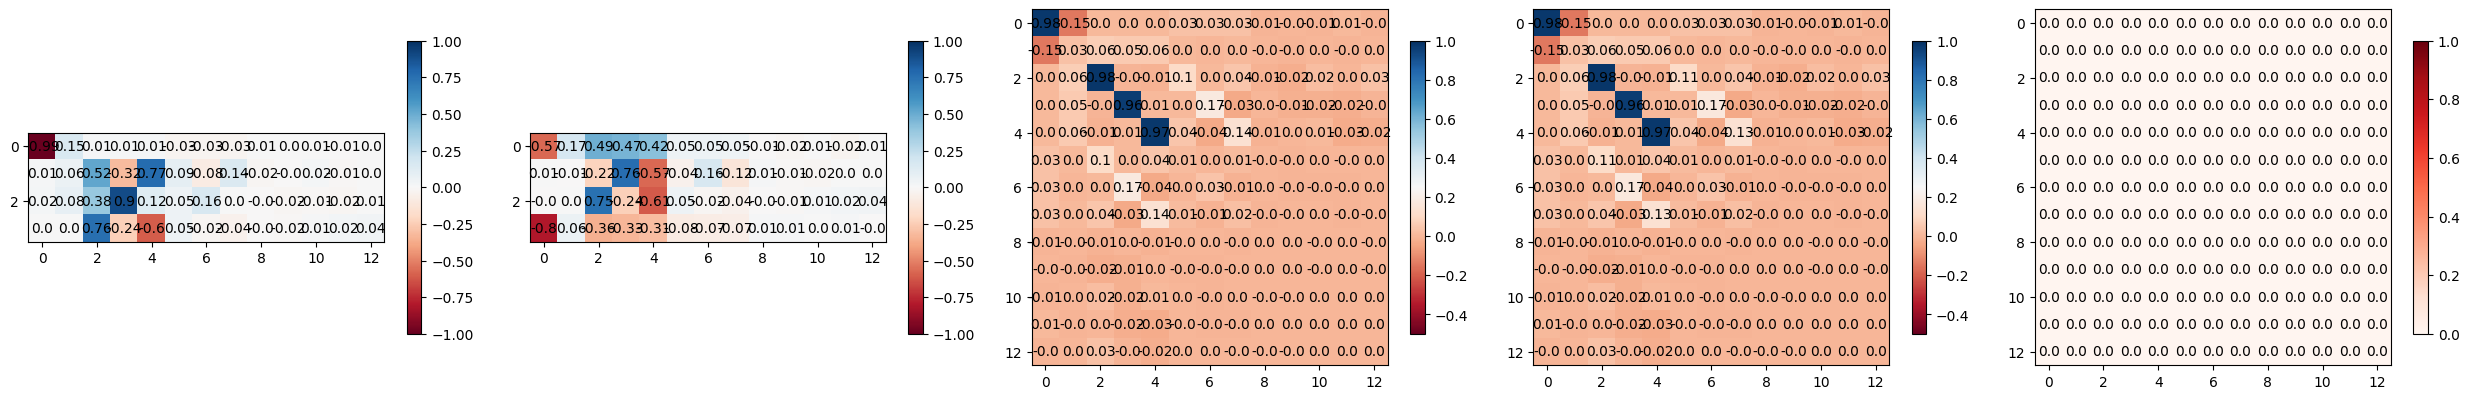

0: 2.619100e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


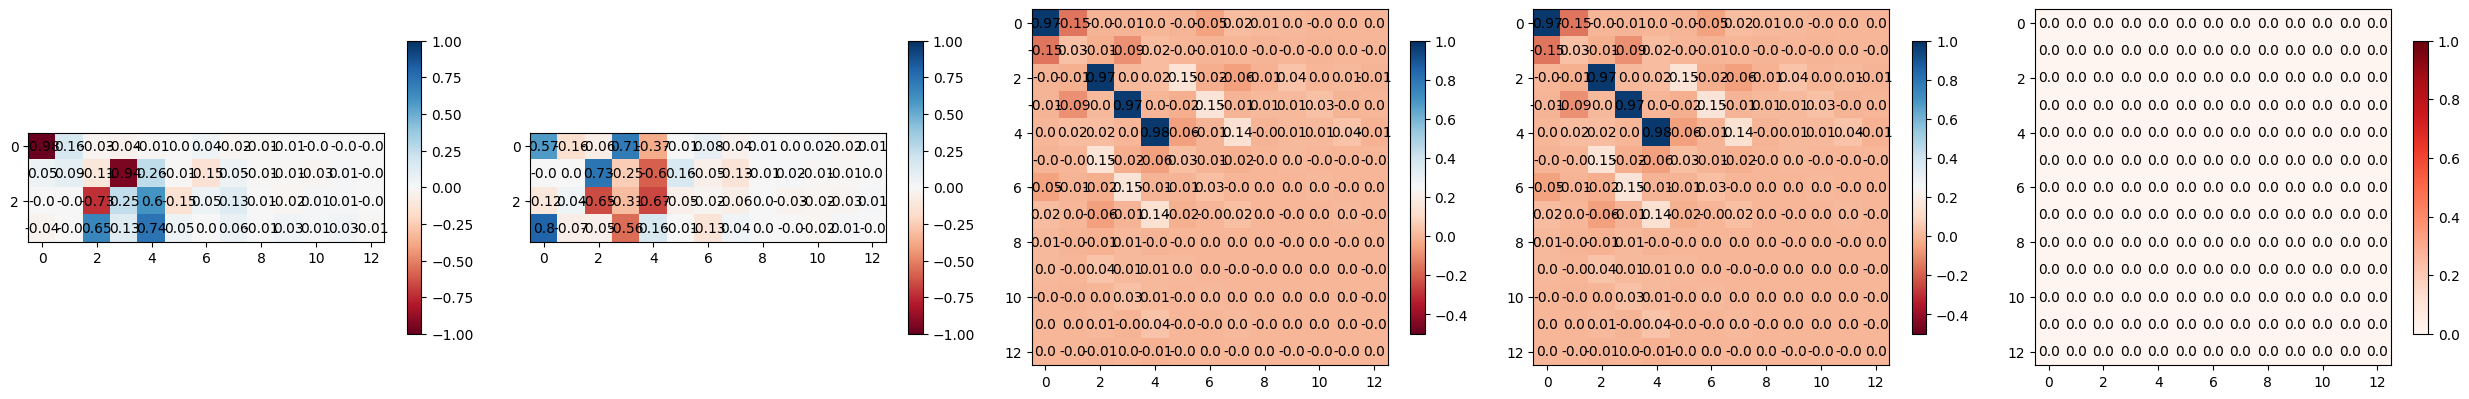

1: 1.984470e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


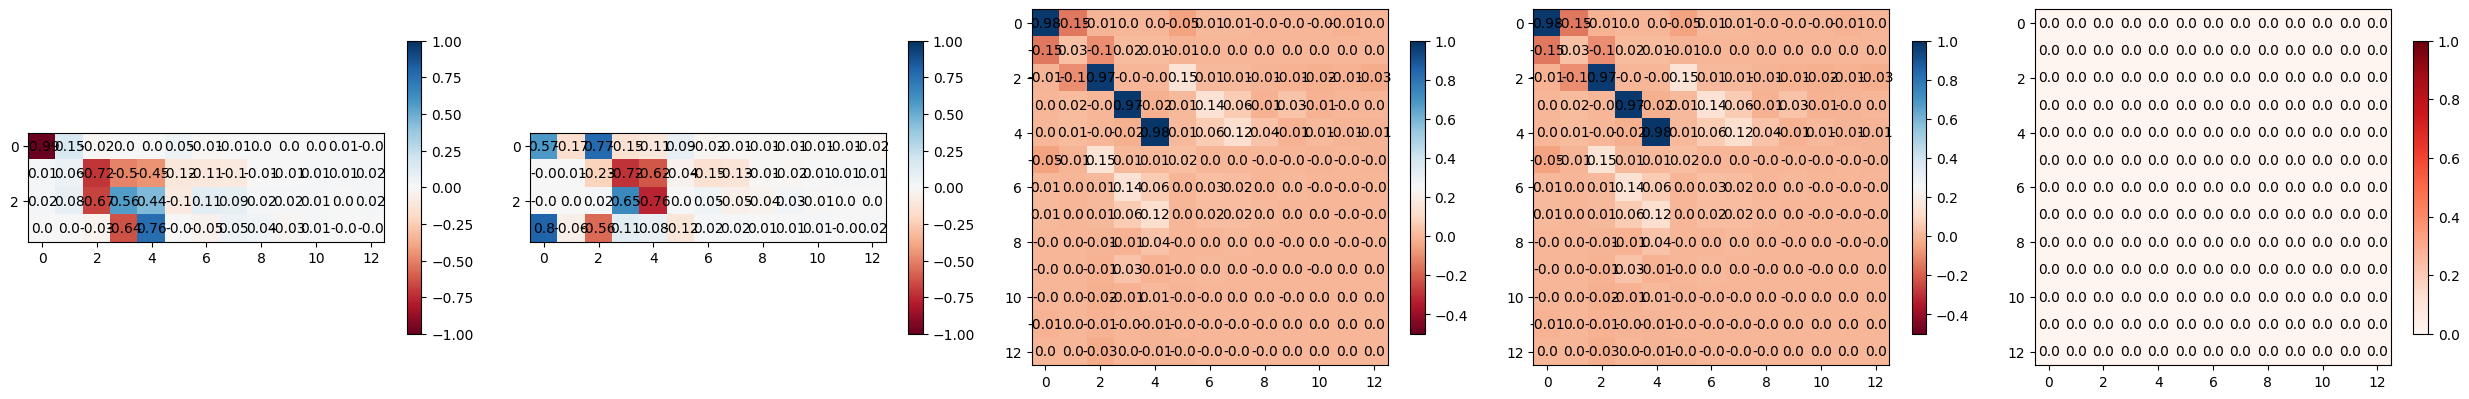

2: 3.265210e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


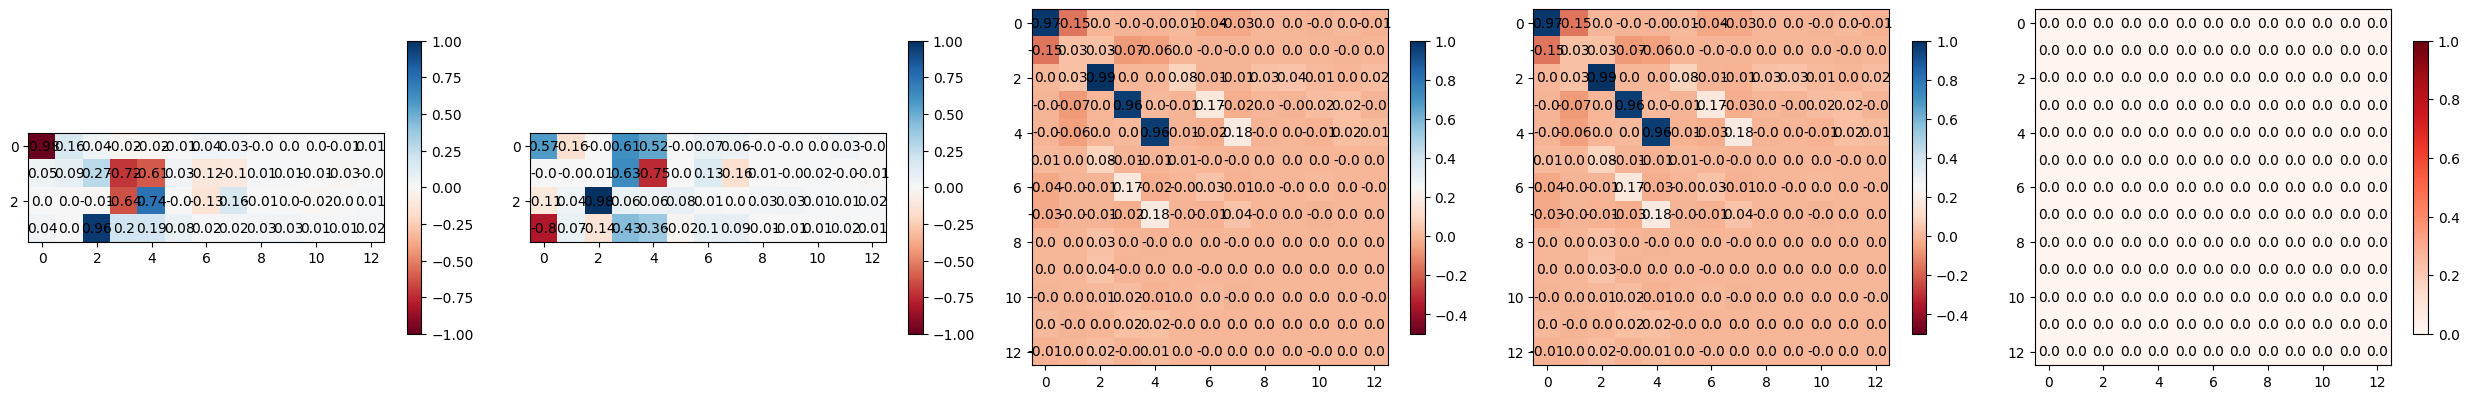

3: 3.081434e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


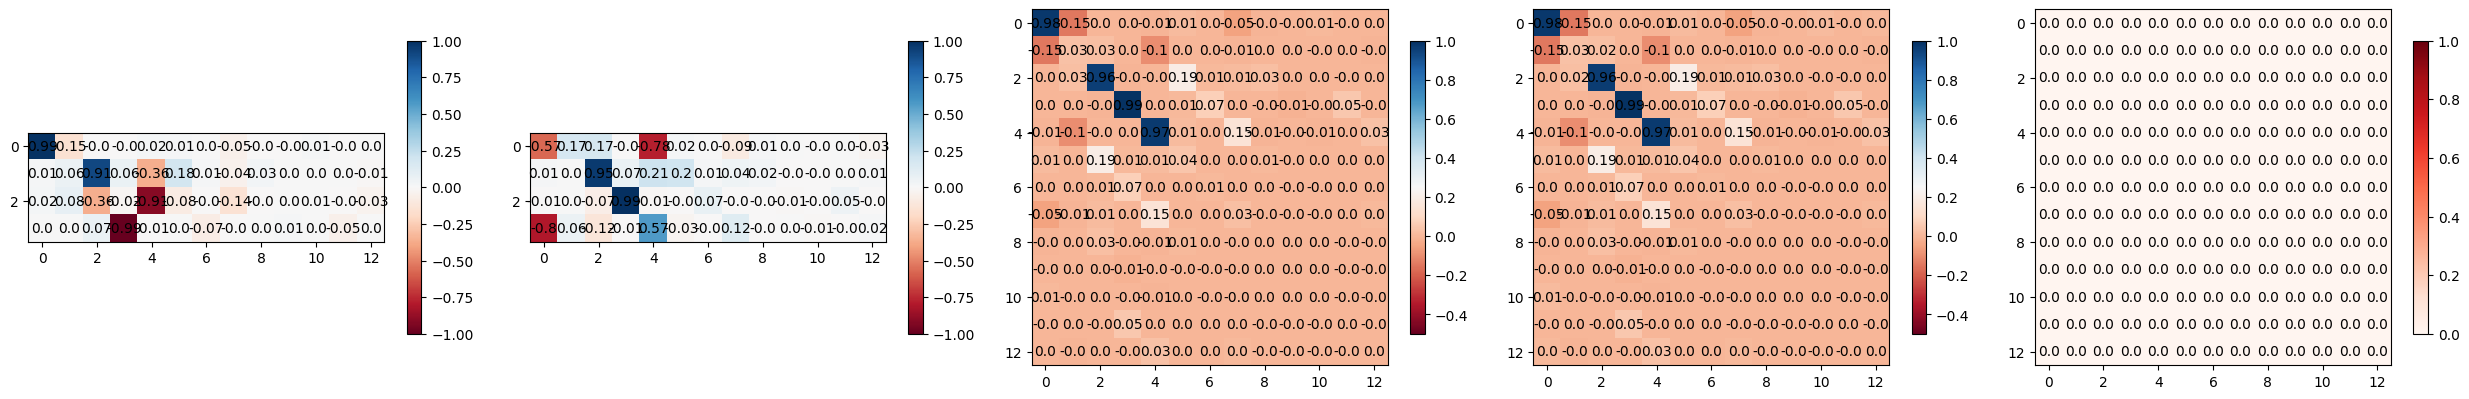

4: 2.845402e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


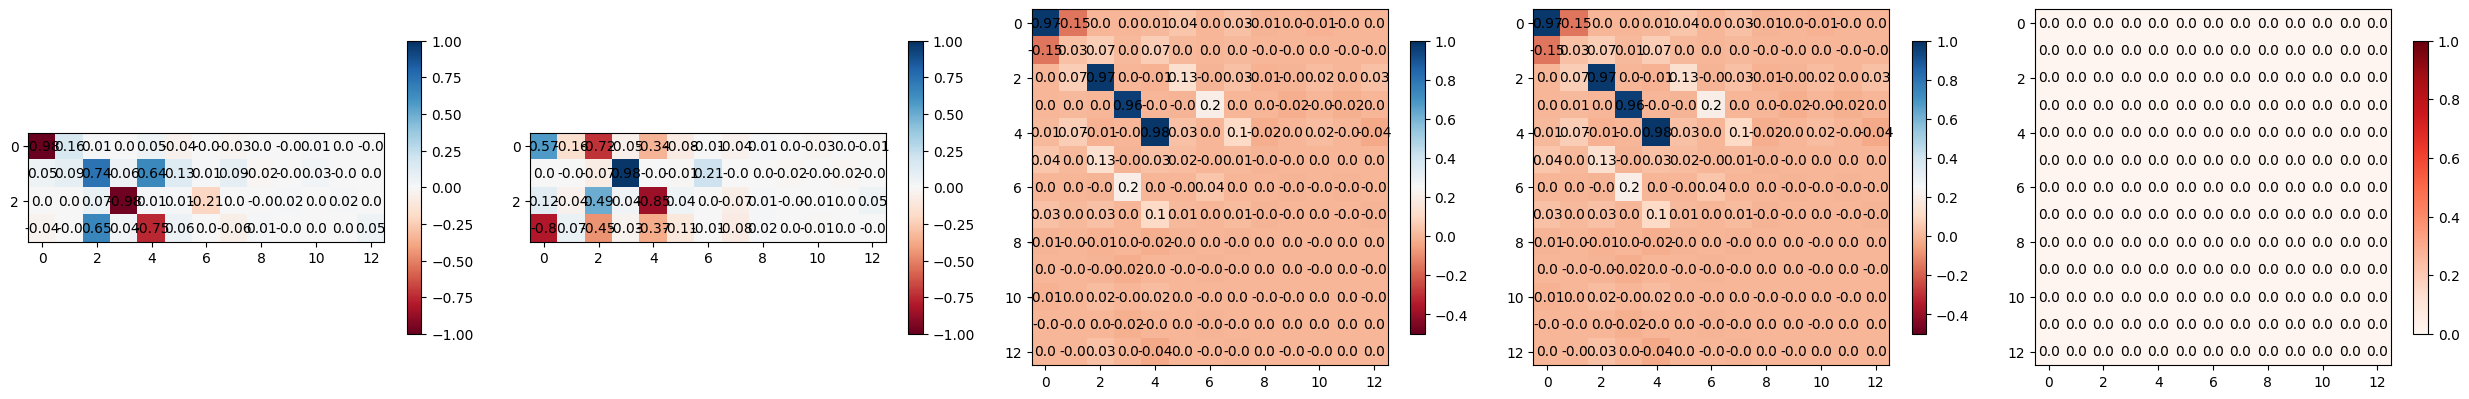

5: 3.168931e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


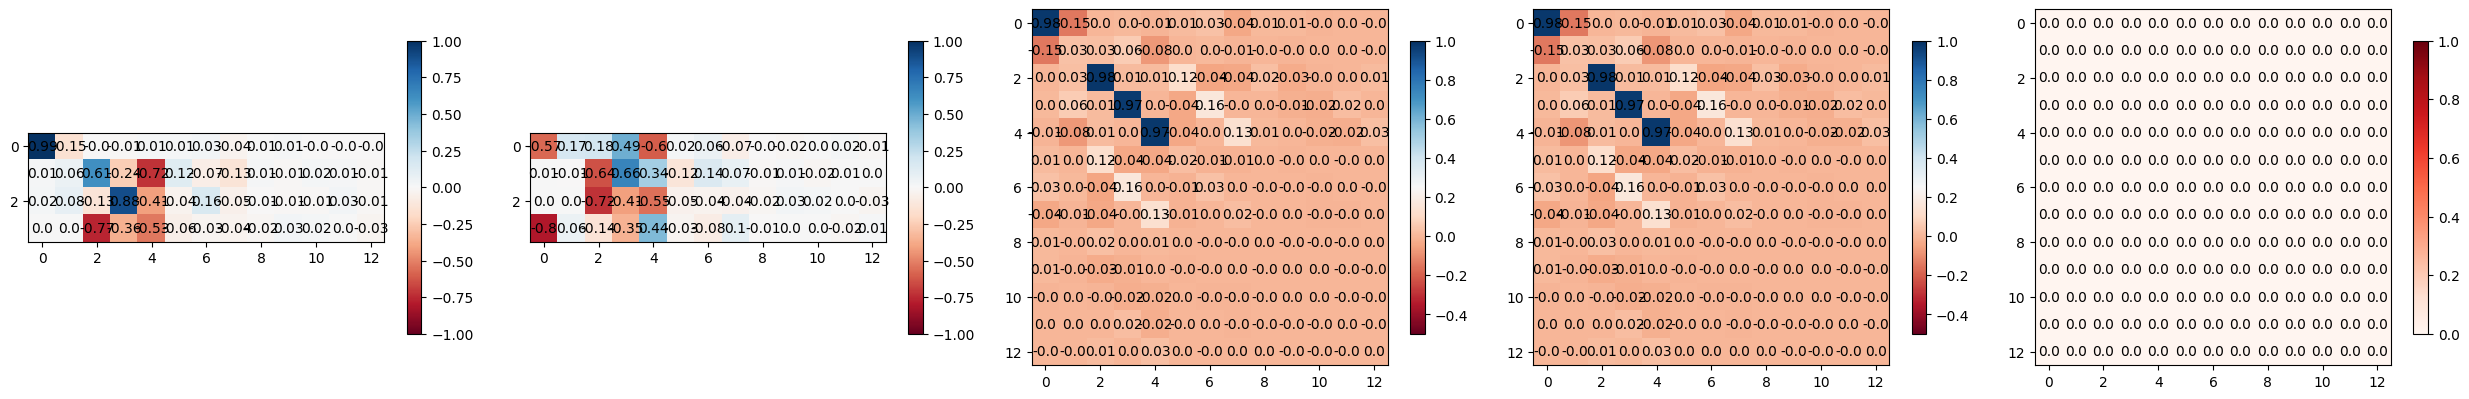

6: 2.515921e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


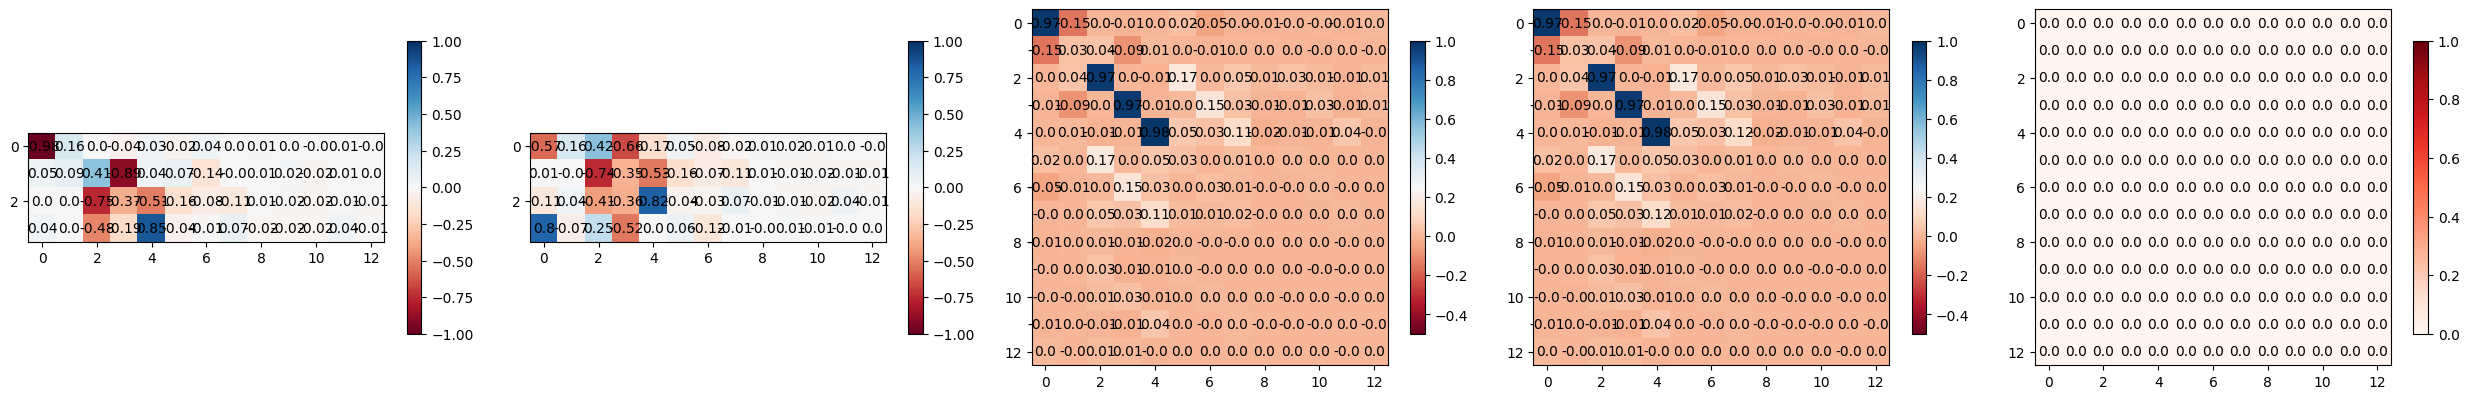

7: 2.657634e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


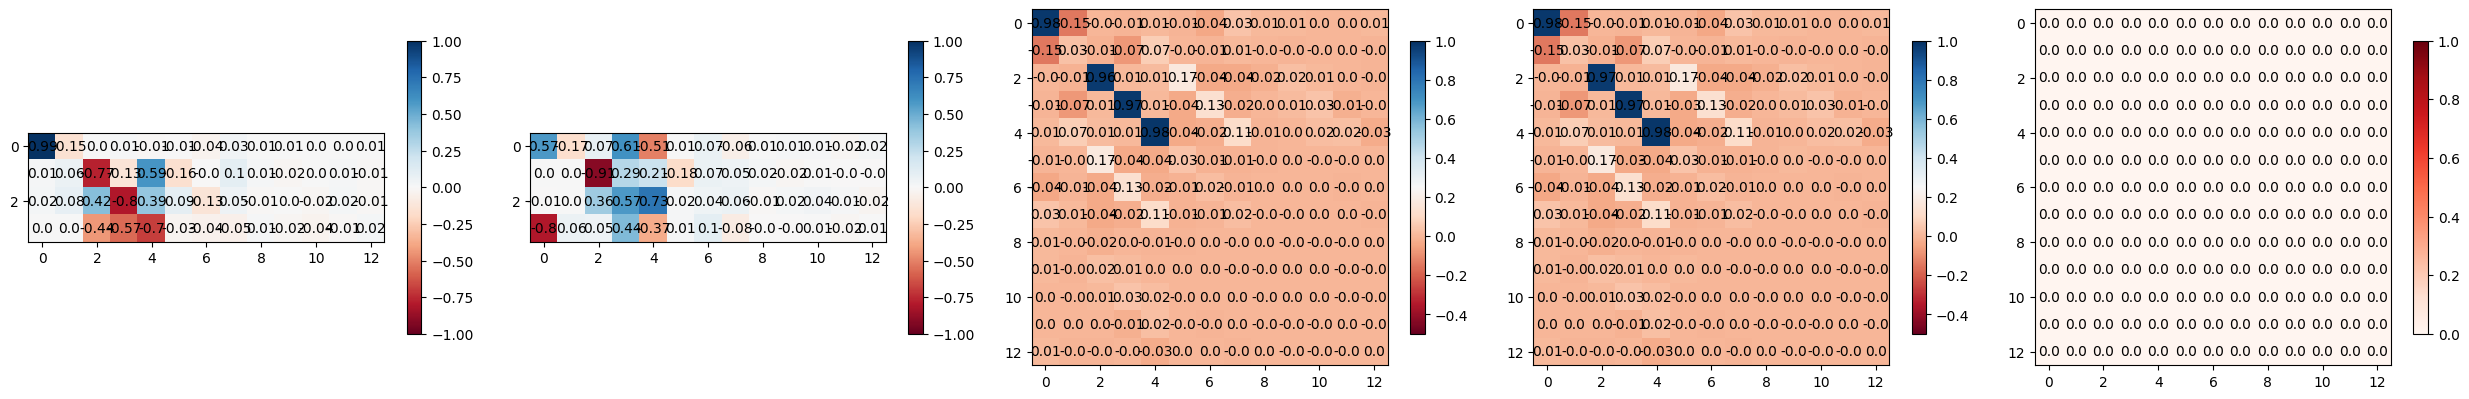

8: 3.086740e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


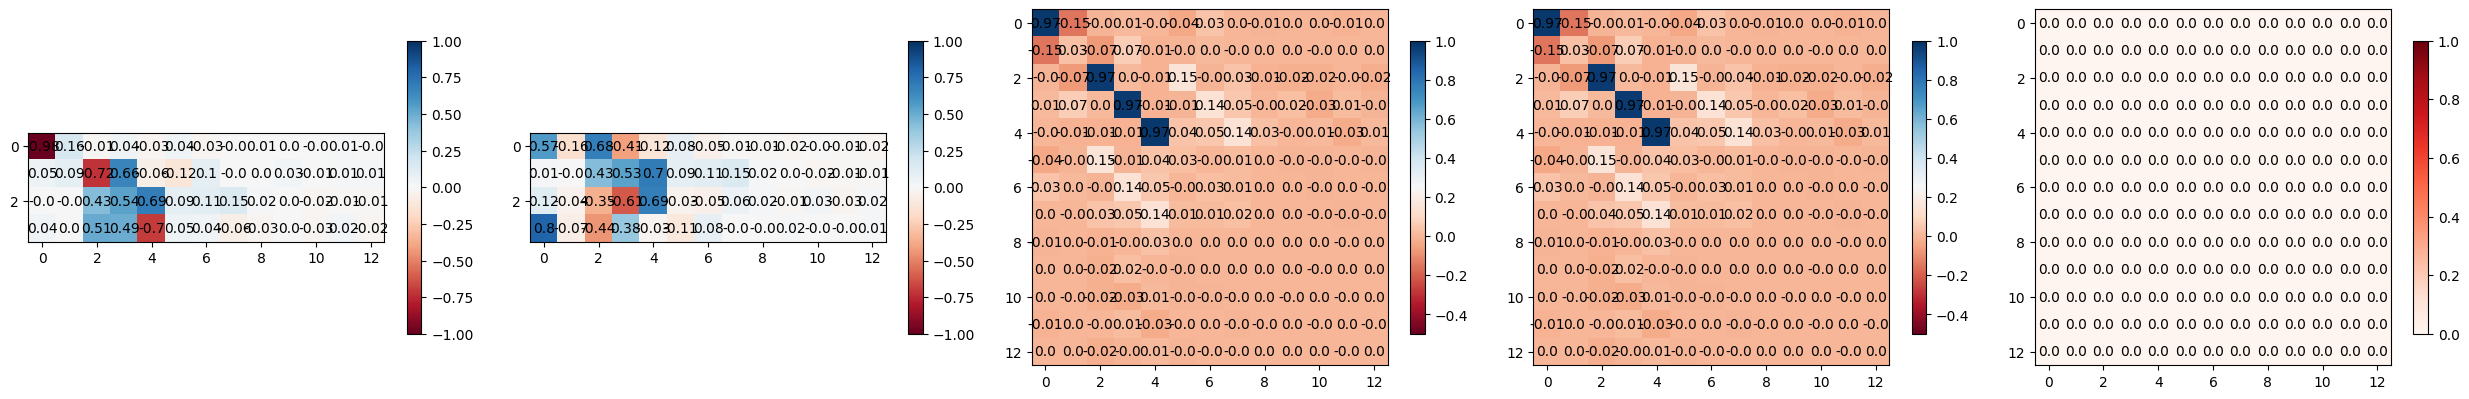

9: 2.704837e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


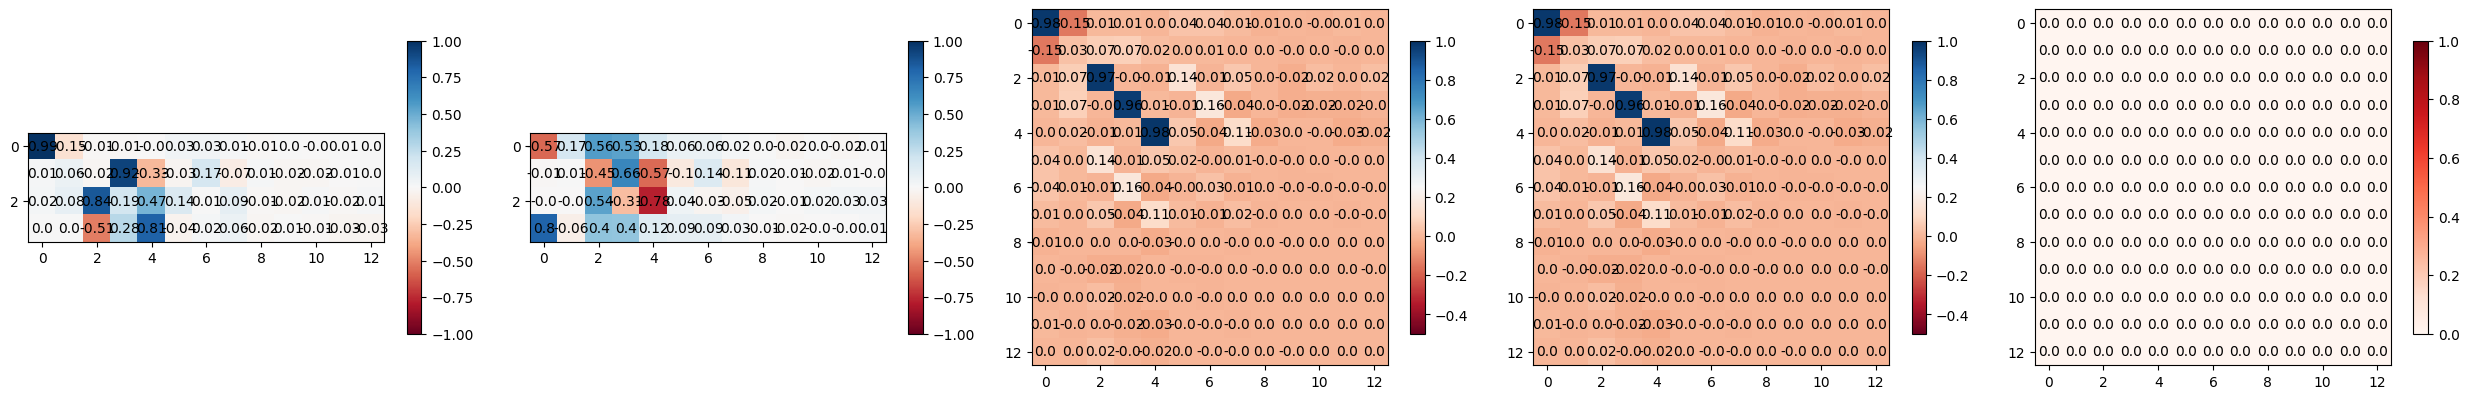

10: 2.561074e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


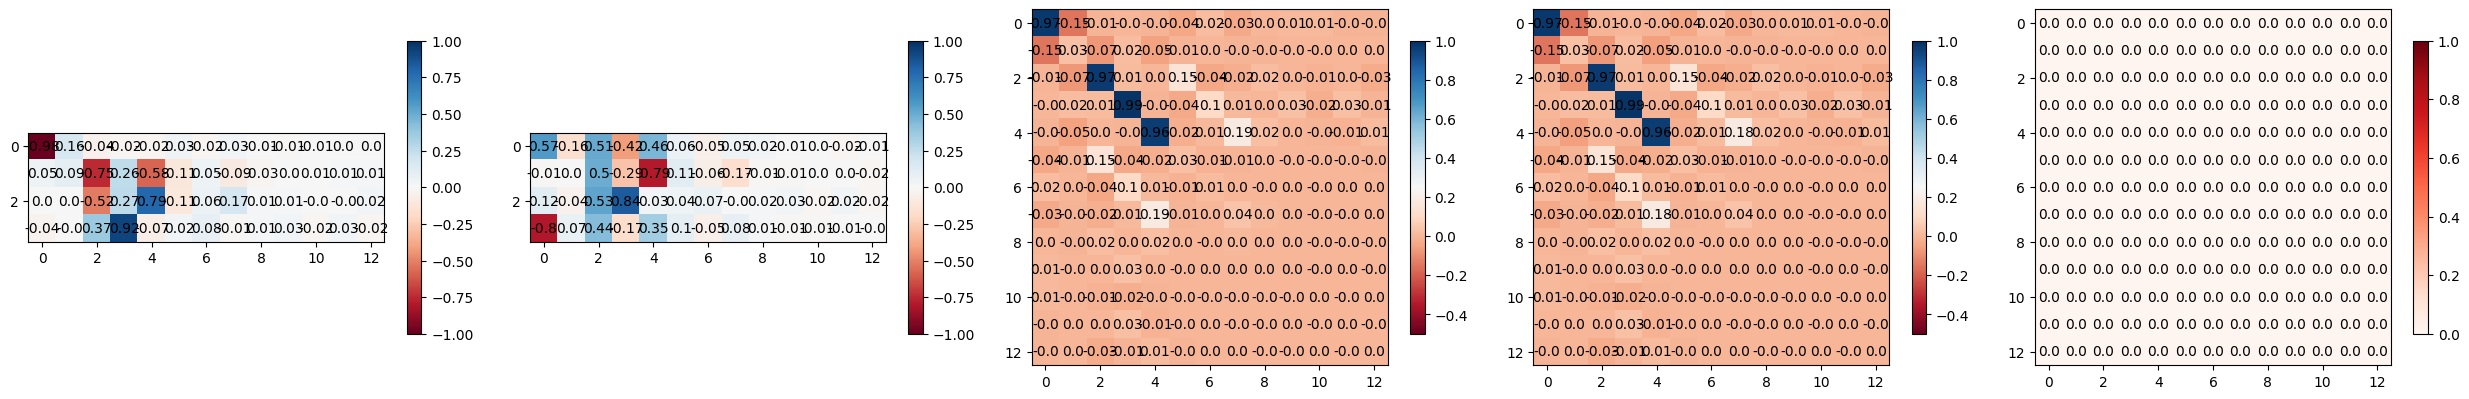

11: 2.677985e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


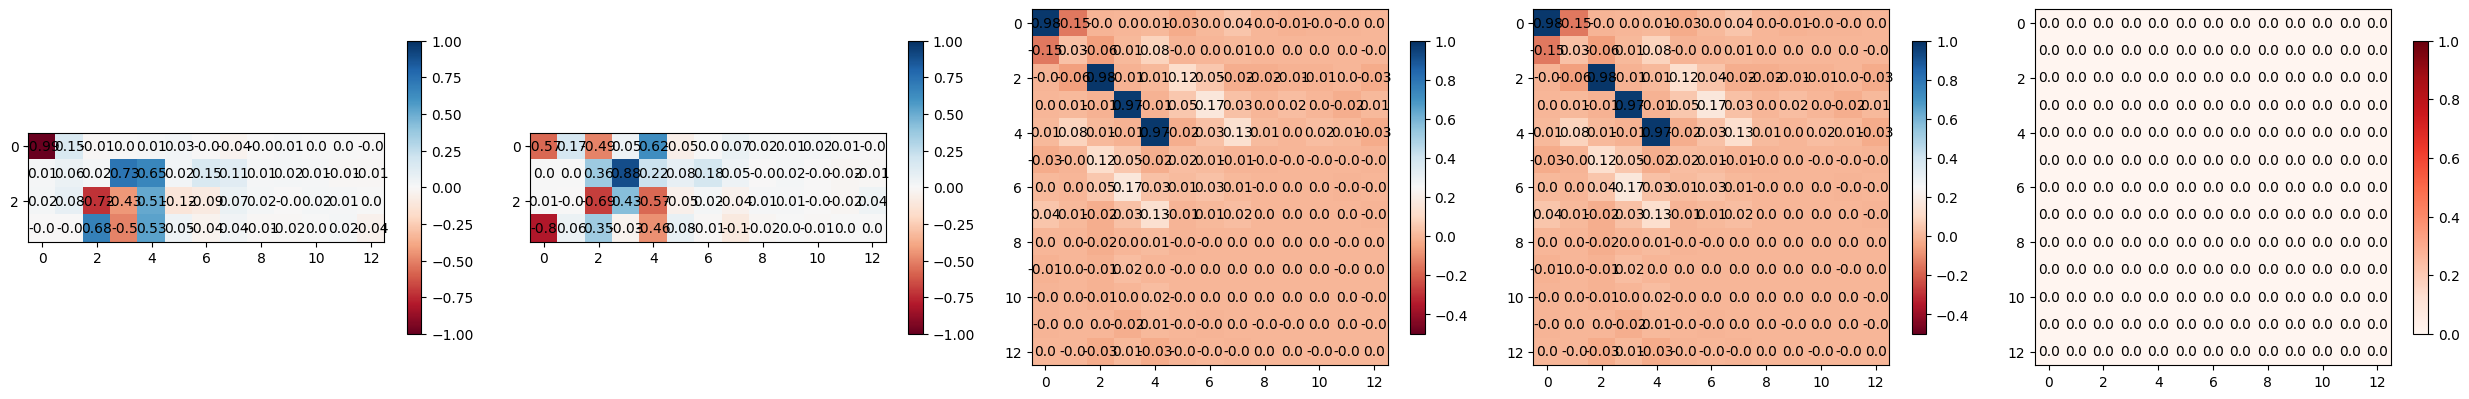

12: 3.078340e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


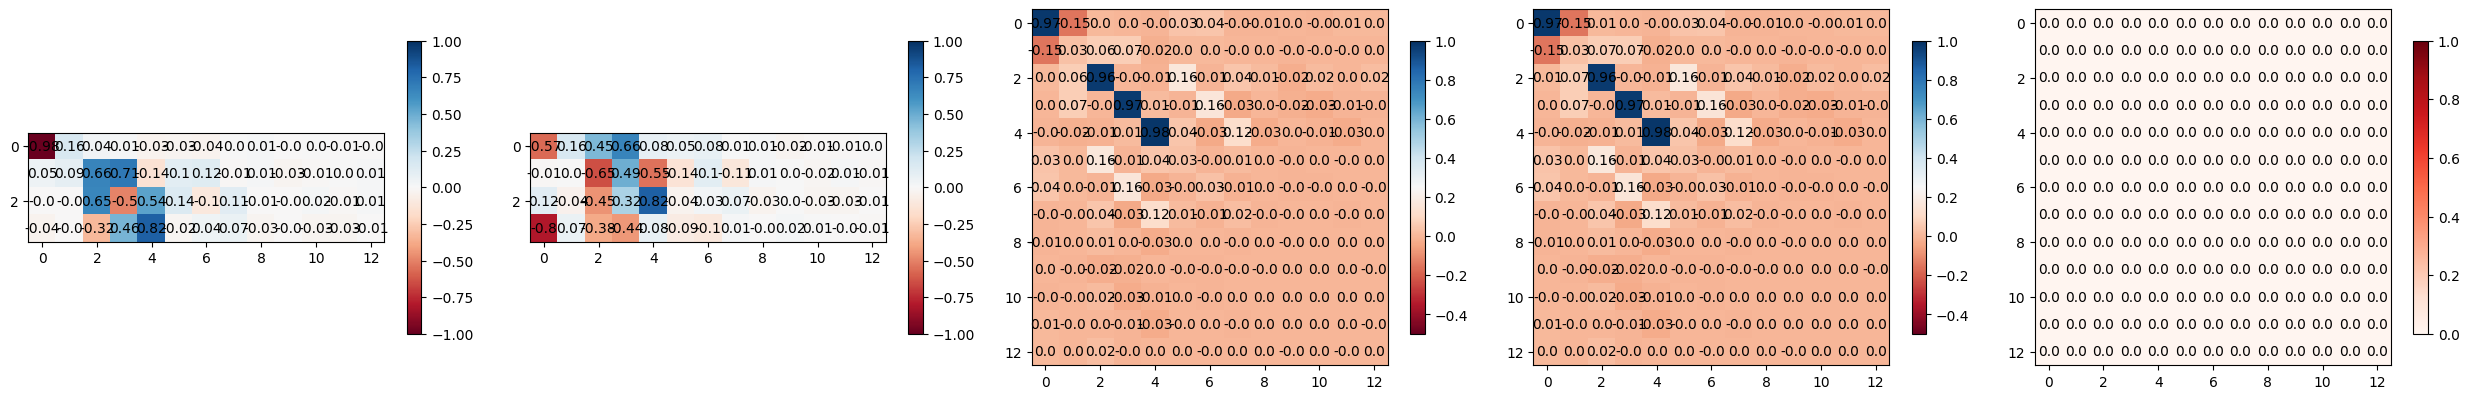

13: 2.556054e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


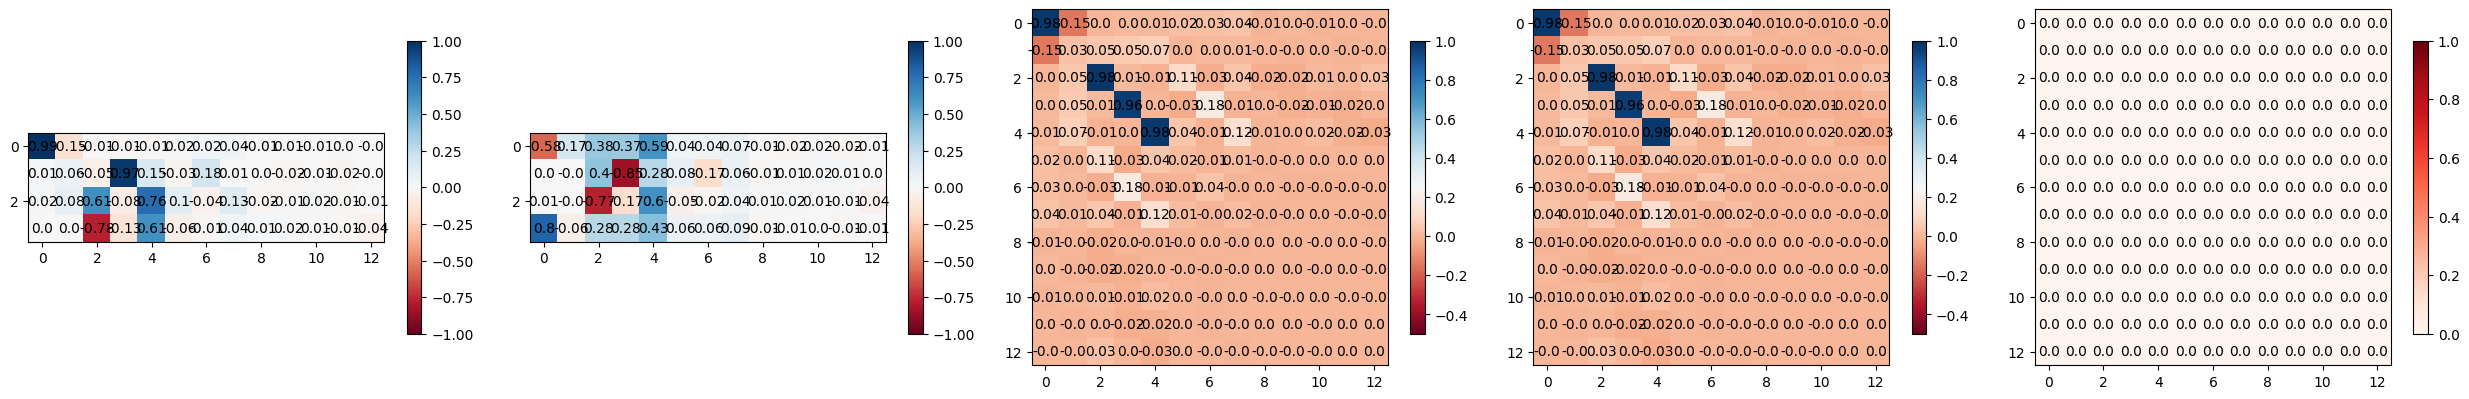

14: 2.525077e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


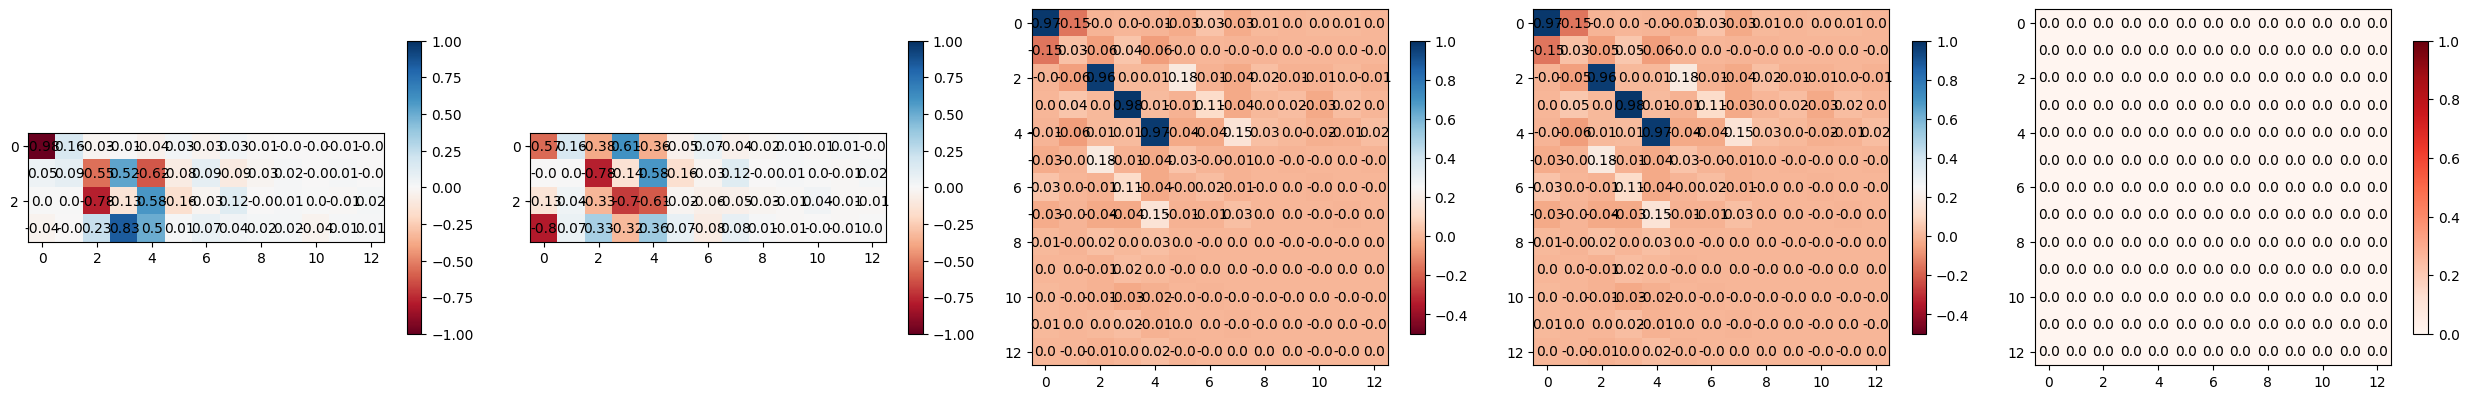

15: 2.601232e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


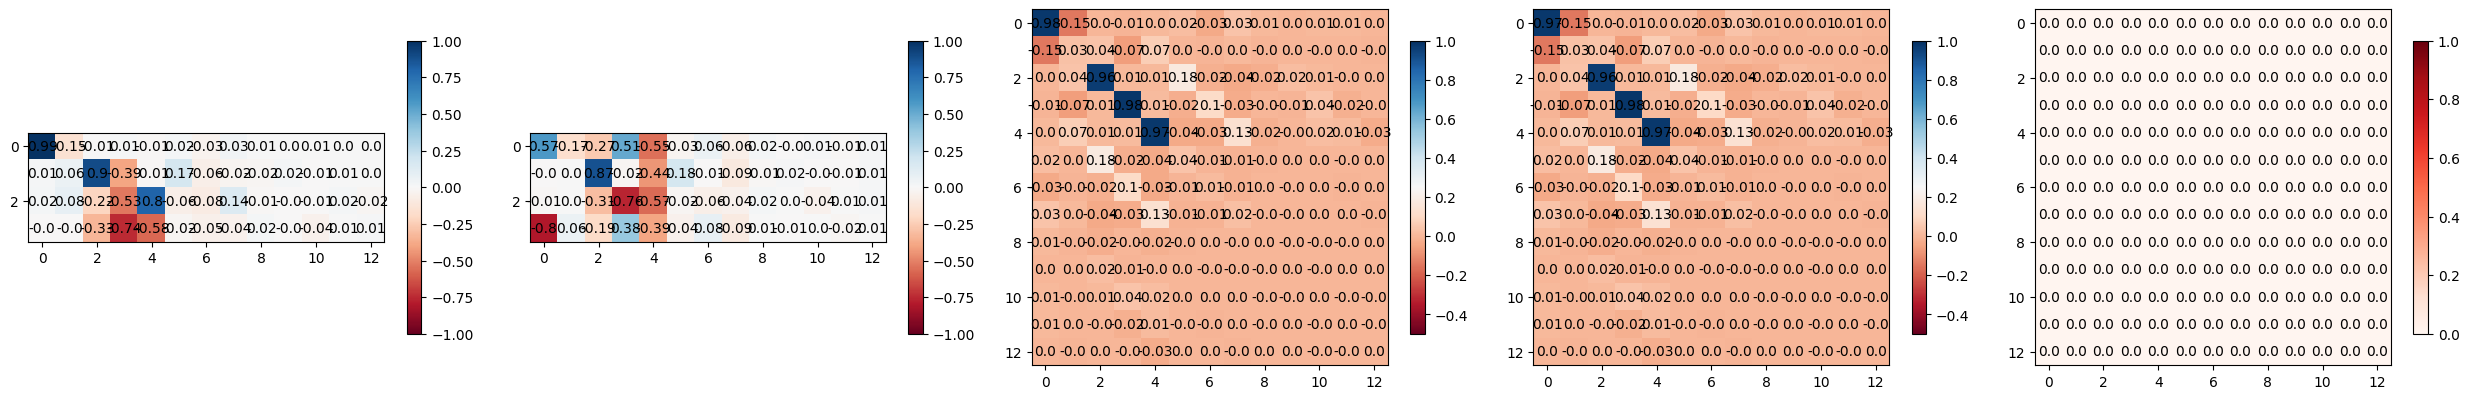

16: 2.998098e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


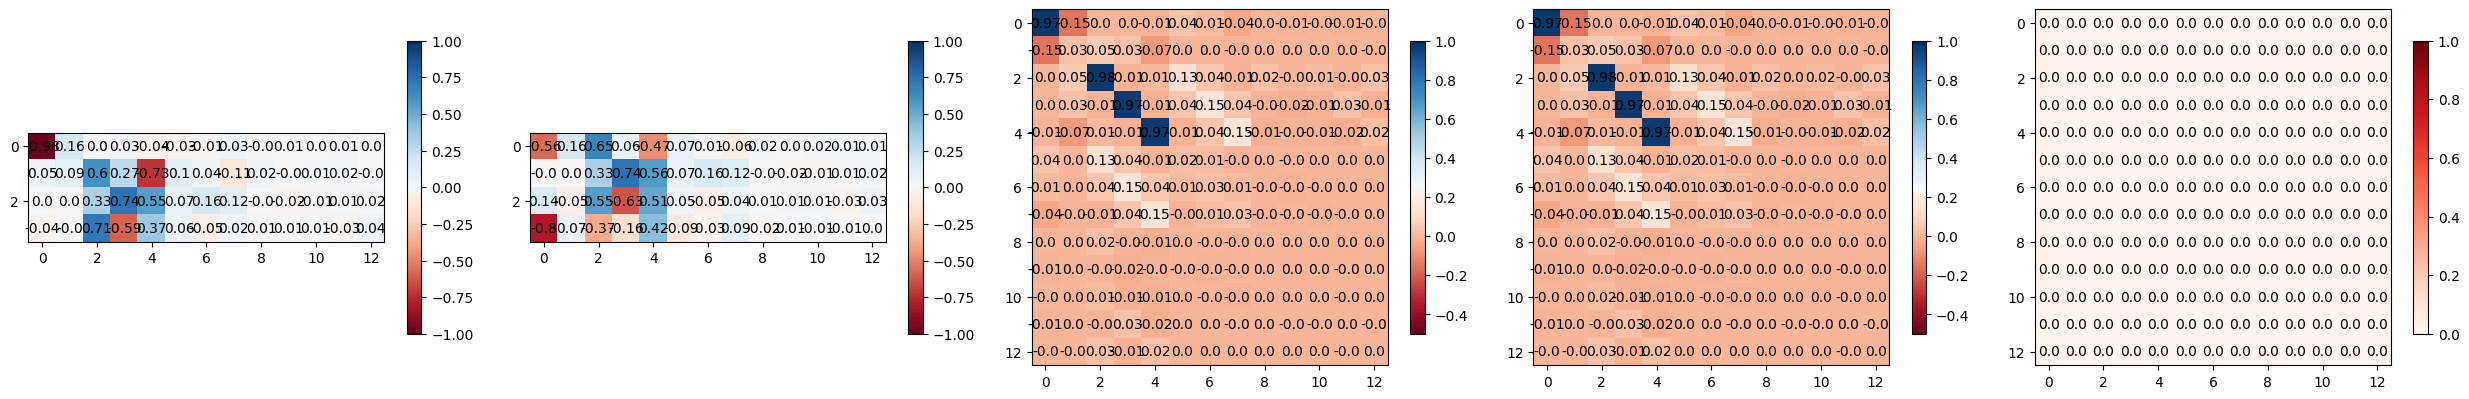

17: 2.605242e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


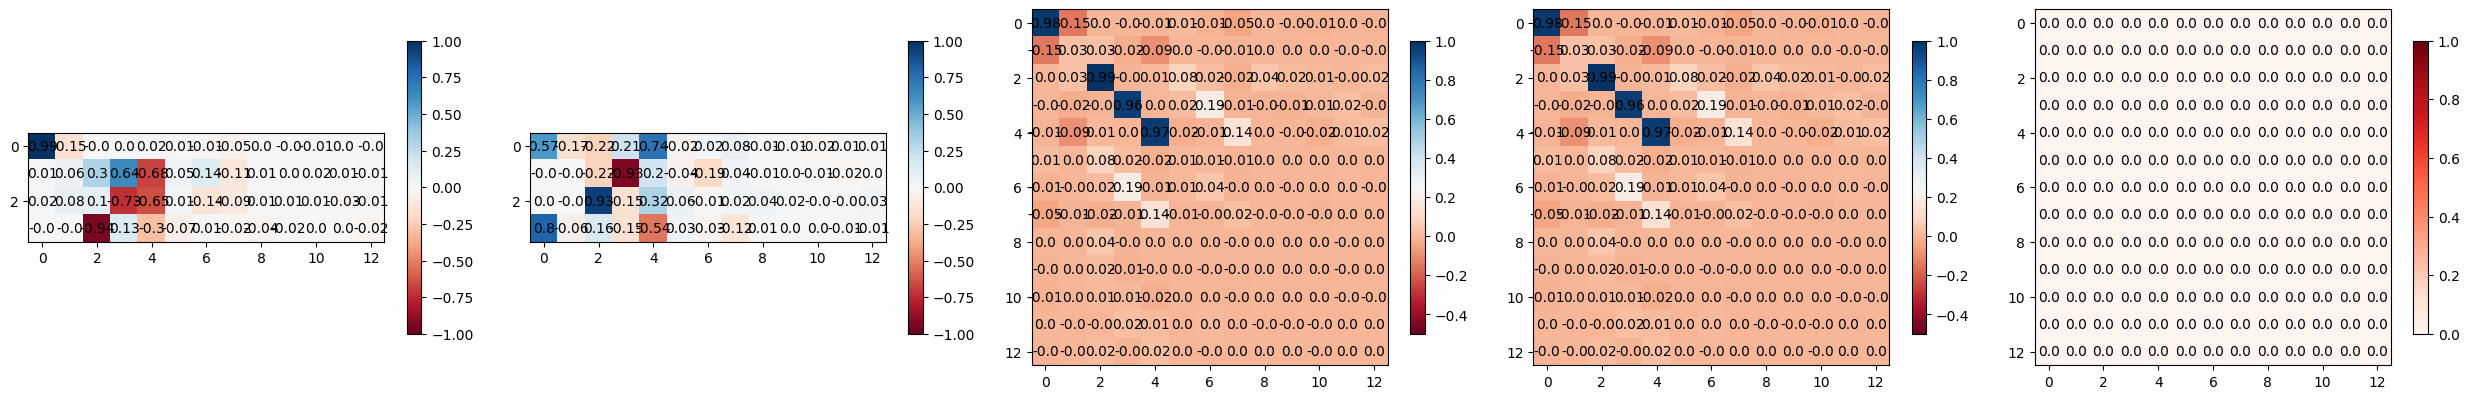

18: 3.088698e-02
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


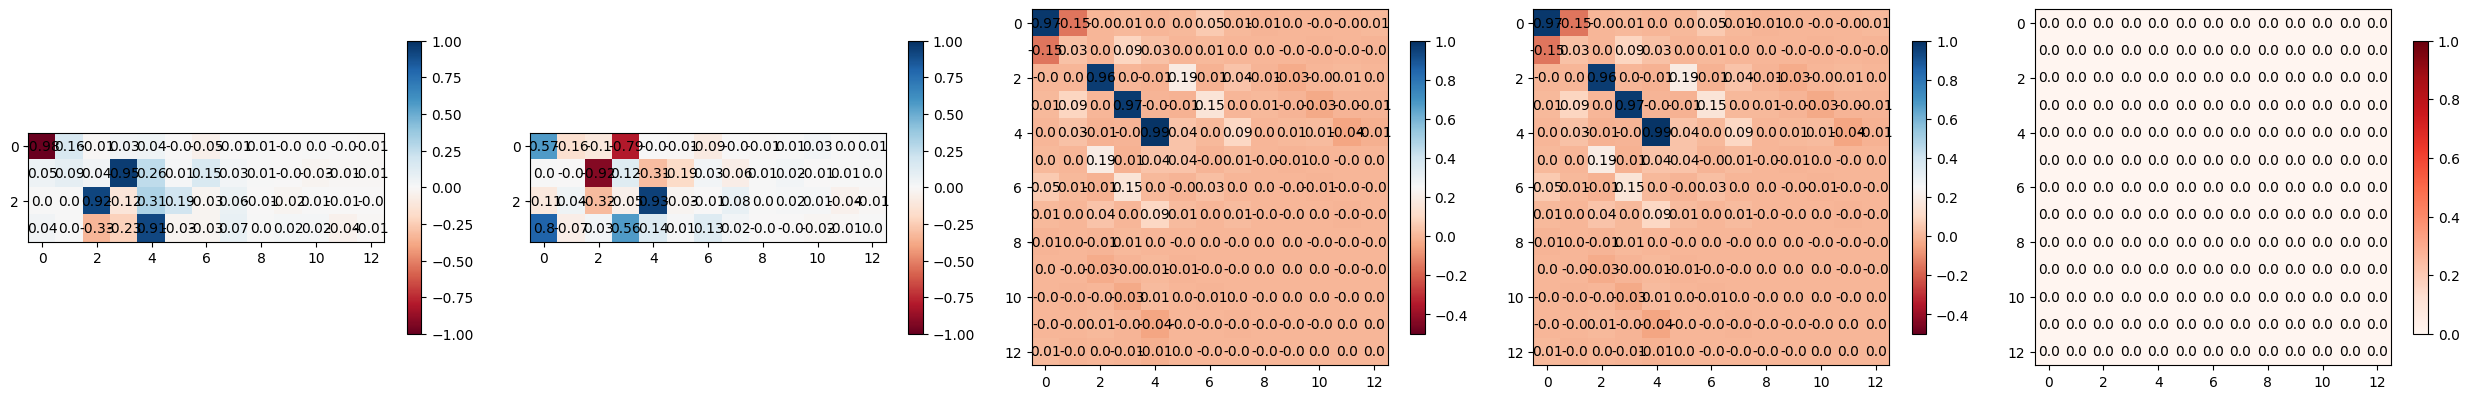

19: 3.023137e-02


In [116]:
prim_basis_spec = prim_basis_specs["O"]
prim_basis_size = o3.Irreps(prim_basis_spec).dim

for idx, pao_object in enumerate(test_data_O):
    label = pao_object.y
    pred = model_O(pao_object)
    label_projector = label.T @ label
    pred_projector = pred.T @ pred
    print(label.pow(2).sum(dim=1))
    print(pred.squeeze().pow(2).sum(dim=1))
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25.0, 4.0))
    ax0 = axs[0].imshow(pred.squeeze().detach(), cmap="RdBu",vmin=-1, vmax=1)
    ax1 = axs[1].imshow(label, cmap="RdBu",vmin=-1, vmax=1)
    ax2 = axs[2].imshow(pred_projector.detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    ax3 = axs[3].imshow(label_projector.detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    ax4 = axs[4].imshow((pred_projector-label_projector).abs().detach(), cmap="Reds",vmin=0, vmax=1)
    for (j,i),l in np.ndenumerate(pred.squeeze().detach()):
        axs[0].text(i,j,round(l,2),ha='center',va='center')
    for (j,i),l in np.ndenumerate(label.squeeze()):
        axs[1].text(i,j,round(l,2),ha='center',va='center')
    for (j,i),l in np.ndenumerate((pred_projector).detach()):
        axs[2].text(i,j,round(l,2),ha='center',va='center')
    for (j,i),l in np.ndenumerate(label_projector.detach()):
        axs[3].text(i,j,round(l,2),ha='center',va='center')
    for (j,i),l in np.ndenumerate((pred_projector-label_projector).abs().detach()):
        axs[4].text(i,j,round(l,2),ha='center',va='center')

    fig.colorbar(ax0, ax=axs[0], shrink=0.8)
    fig.colorbar(ax1, ax=axs[1], shrink=0.8)
    fig.colorbar(ax2, ax=axs[2], shrink=0.8)
    fig.colorbar(ax3, ax=axs[3], shrink=0.8)
    fig.colorbar(ax4, ax=axs[4], shrink=0.8)
    plt.tight_layout()
    plt.show()
    test_mae = (pred_projector-label_projector).abs().sum()
    print(f"{idx}: {test_mae:e}")

## PAO-Model Hydrogen

In [106]:
# Irreps Input
irreps_input = o3.Irreps("2x0e") # features: is_hydrogen, is_oxygen

# Irreps Spherical Harmonics
irreps_sh = o3.Irreps.spherical_harmonics(lmax=1)

# Primitive Basis specs

prim_basis_spec = o3.Irreps(prim_basis_specs["H"])
prim_basis_size = o3.Irreps(prim_basis_spec).dim

# Irreps Output
irreps_output = o3.Irreps(
            "2x0e+1x1o+\
             1x0e+1x1o+\
             1x0e+1x2e")

In [107]:
batch_size = 1
data_H = []

for pao_object in pao_objects_H:
    data_H += [
        Data(
            x=None, pos=pao_object.coords, y=pao_object.label, z=pao_object.atomkind
        )
    ]
train_loader_H = DataLoader(
    data_H, batch_size=batch_size, shuffle=False
)

In [108]:
max_radius = 4.0
num_neighbours = 5
model_H = PAO_model(
    max_radius=max_radius,
    num_layers=32,
    num_neighbours=num_neighbours,
    pao_basis_size=pao_basis_size,
    prim_basis_spec=prim_basis_spec,
    prim_basis_size=prim_basis_size, 
    irreps_input=irreps_input,
    irreps_sh=irreps_sh,
    irreps_output=irreps_output
)

In [109]:
# Train the model.
optim = torch.optim.Adam(model_H.parameters(), lr=1e-3)
train_loss_H = []
for step in range(5001):
    optim.zero_grad()
    temp_loss = 0
    loss_string = ""
    i = 0
    for x in data_H:
        label = x.y
        pred = model_H(x)
        loss = loss_function_ortho_projector(pred, label)
        loss.backward()
        if step % 100 == 0:
            loss_string += (f"  {loss:.8e}")
            temp_loss += loss.detach()
            i+=1
    optim.step()
    if step % 100 == 0:
        temp_loss /= i
        train_loss_H.append(temp_loss)
        print(f"training {step:5d} | loss {loss_string}")


training     0 | loss   5.46021499e-02  5.49614541e-02  5.18652722e-02  5.29724136e-02
training   100 | loss   1.48797082e-02  1.57163385e-02  5.03743719e-03  1.58420280e-02
training   200 | loss   3.68258479e-04  5.40593755e-04  7.69204227e-04  6.52893679e-03
training   300 | loss   8.80994121e-05  6.63664541e-05  8.32445003e-05  2.06842553e-03
training   400 | loss   7.78591057e-05  2.63423608e-05  1.21255769e-04  1.20039003e-04
training   500 | loss   2.08541987e-05  2.89319451e-06  3.25074070e-05  8.52887297e-06
training   600 | loss   8.88995964e-06  5.96731206e-06  1.09491721e-05  5.65147820e-06
training   700 | loss   5.63741833e-06  8.67024937e-06  6.92570802e-06  5.36216930e-06
training   800 | loss   4.69252427e-06  9.67309188e-06  6.03126227e-06  5.33489629e-06
training   900 | loss   4.40636268e-06  9.81210542e-06  5.75150807e-06  5.33430102e-06
training  1000 | loss   4.31258422e-06  9.64898300e-06  5.60980243e-06  5.33594584e-06
training  1100 | loss   4.27221312e-06  9.3

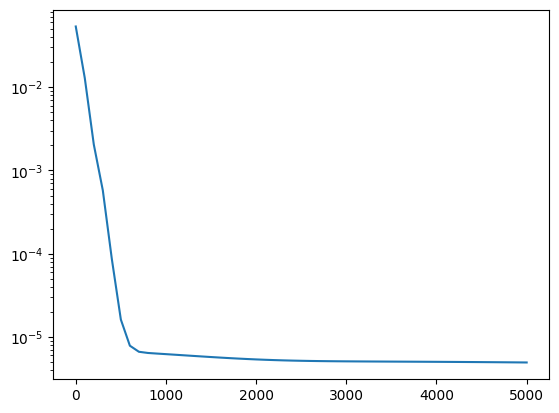

In [110]:
plt.plot(list(range(0, 5001,100)), train_loss_H)
plt.yscale("log")
plt.show()

In [111]:
torch.save(model_H.state_dict(), "./model_H_hamil.param")

In [117]:
test_data_H= []
for pao_object in test_pao_objects_H:
    test_data_H += [
        Data(
            x=None, pos=pao_object.coords, y=pao_object.label, z=pao_object.atomkind
        )
    ]

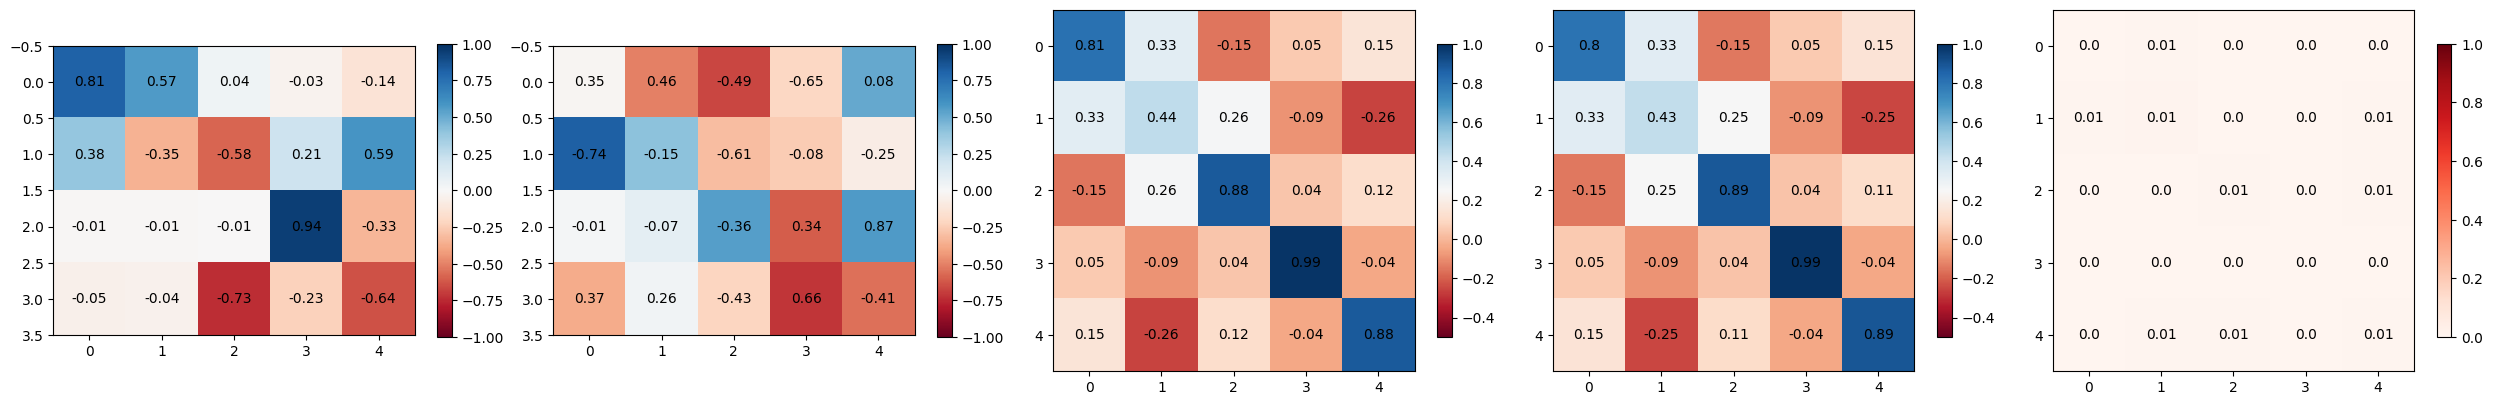

0: 3.790948e-03


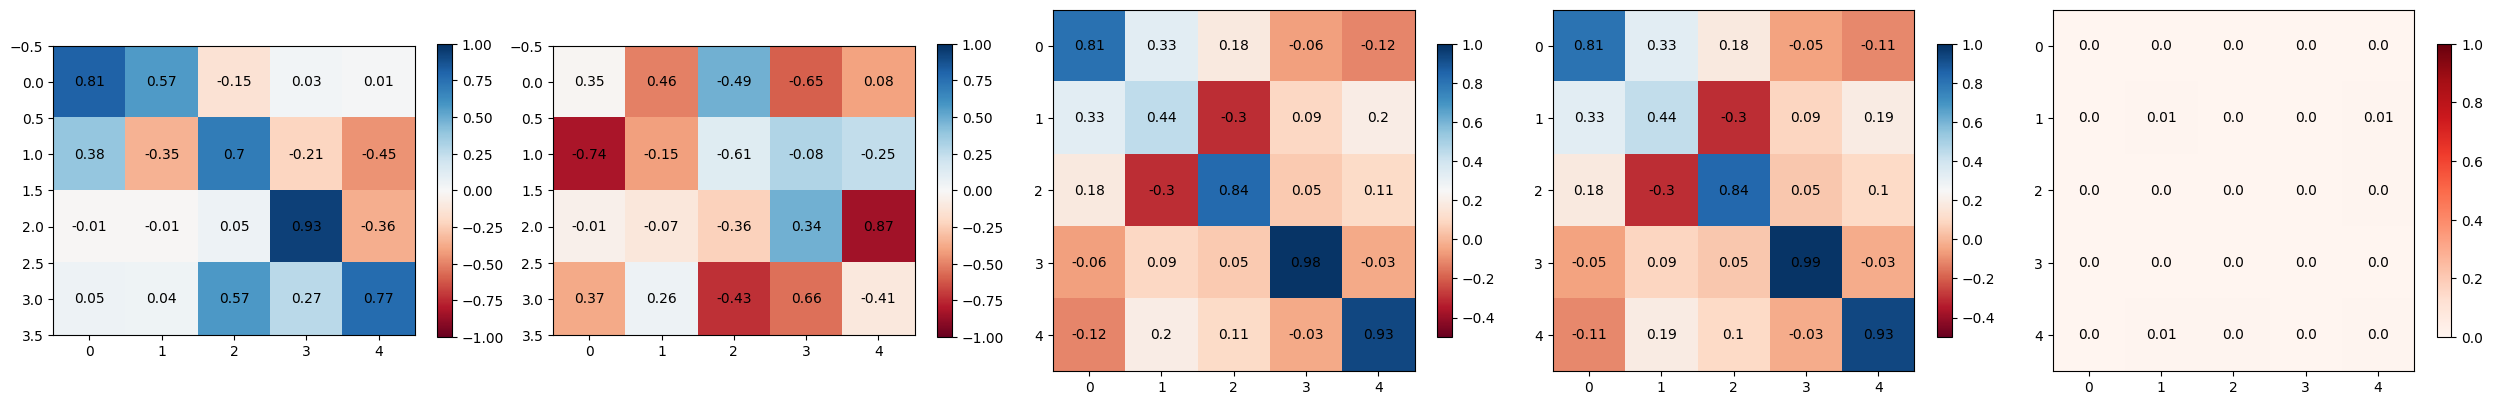

1: 2.664694e-03


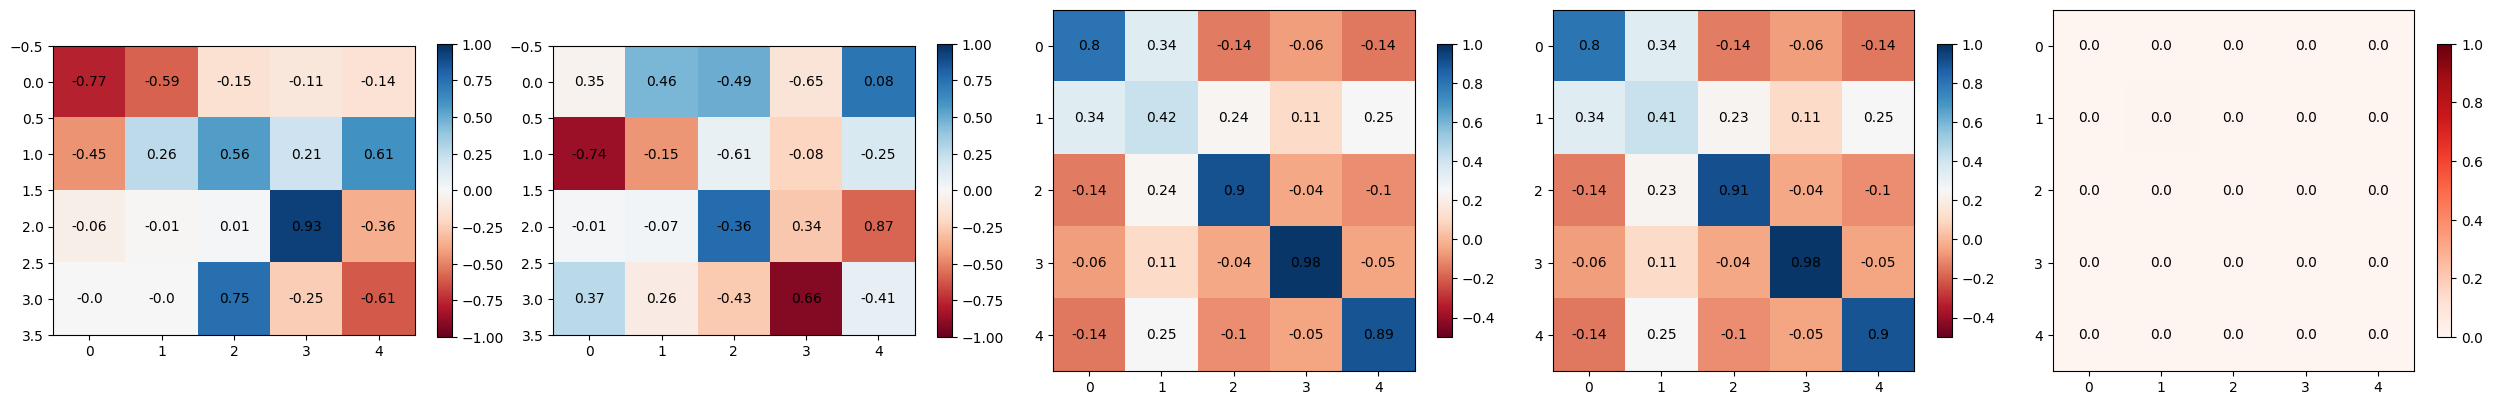

2: 1.915160e-03


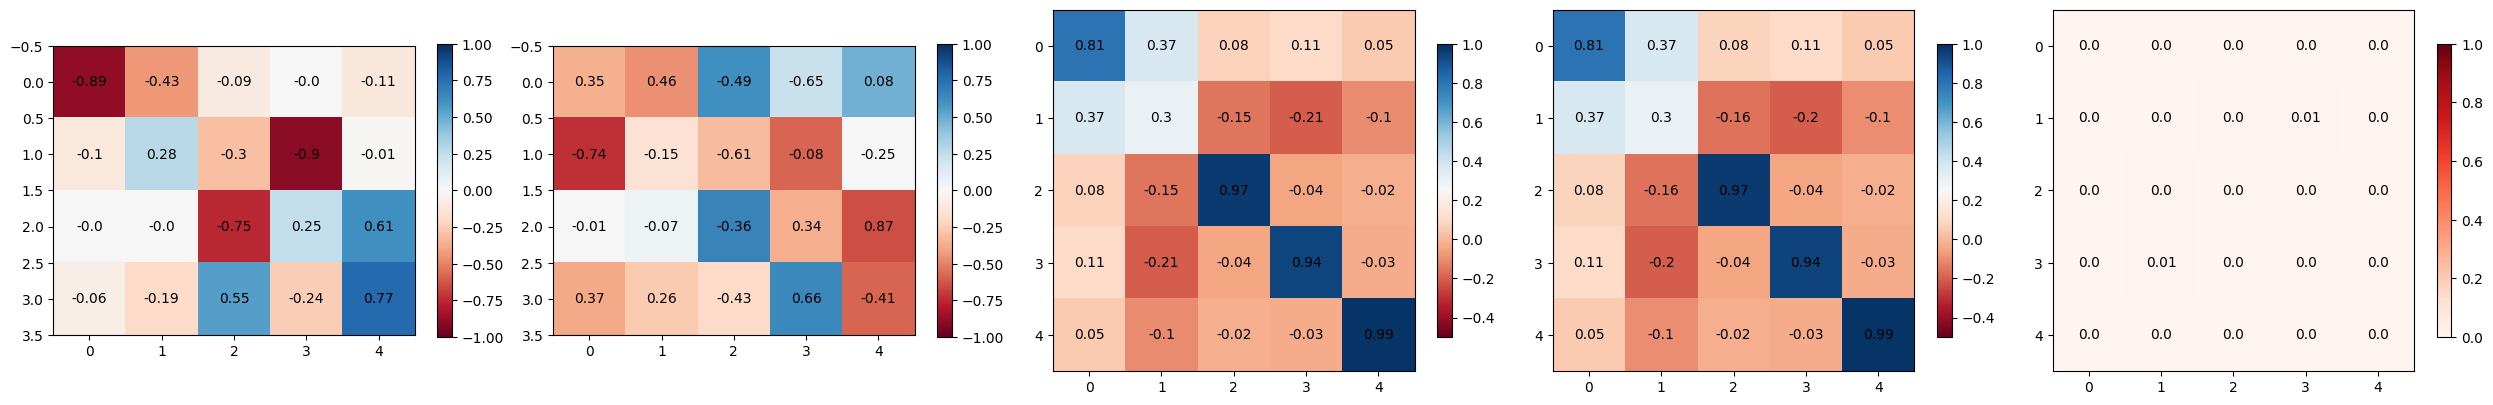

3: 1.935556e-03


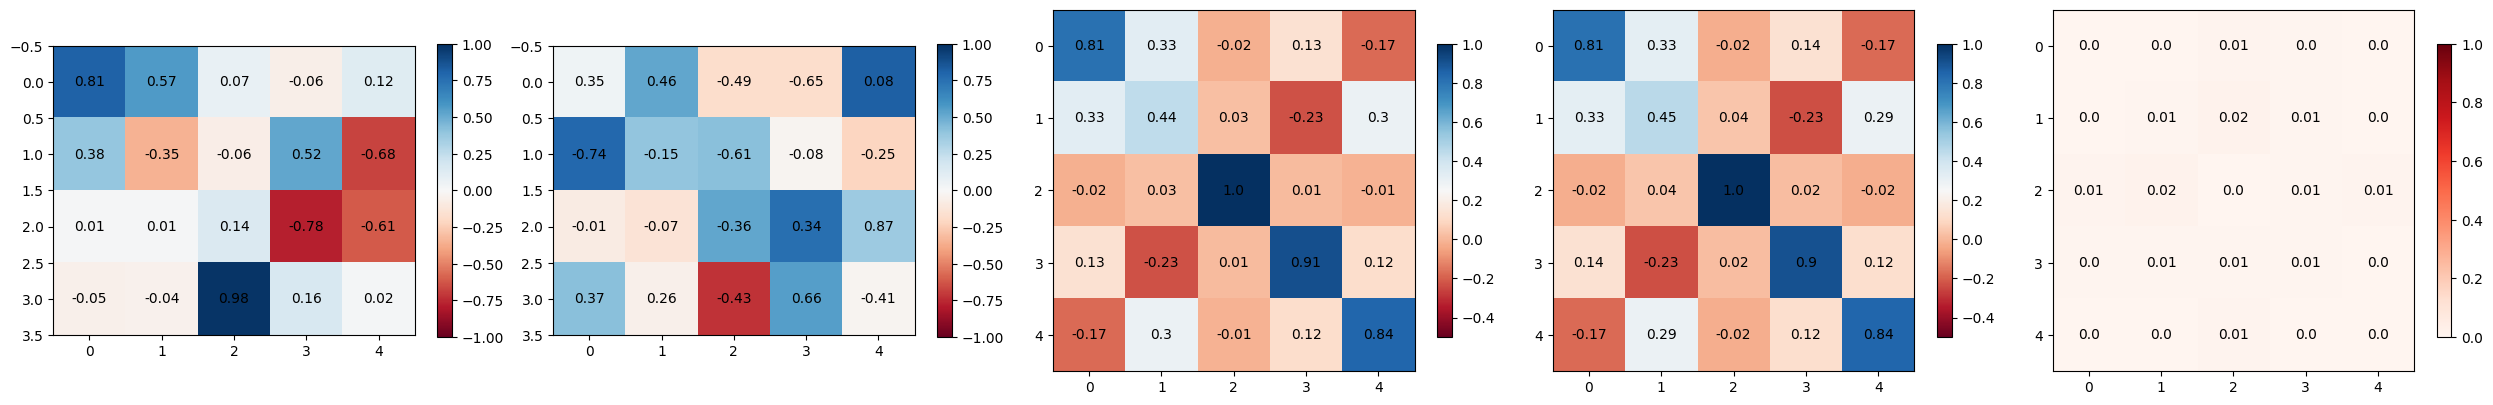

4: 5.328802e-03


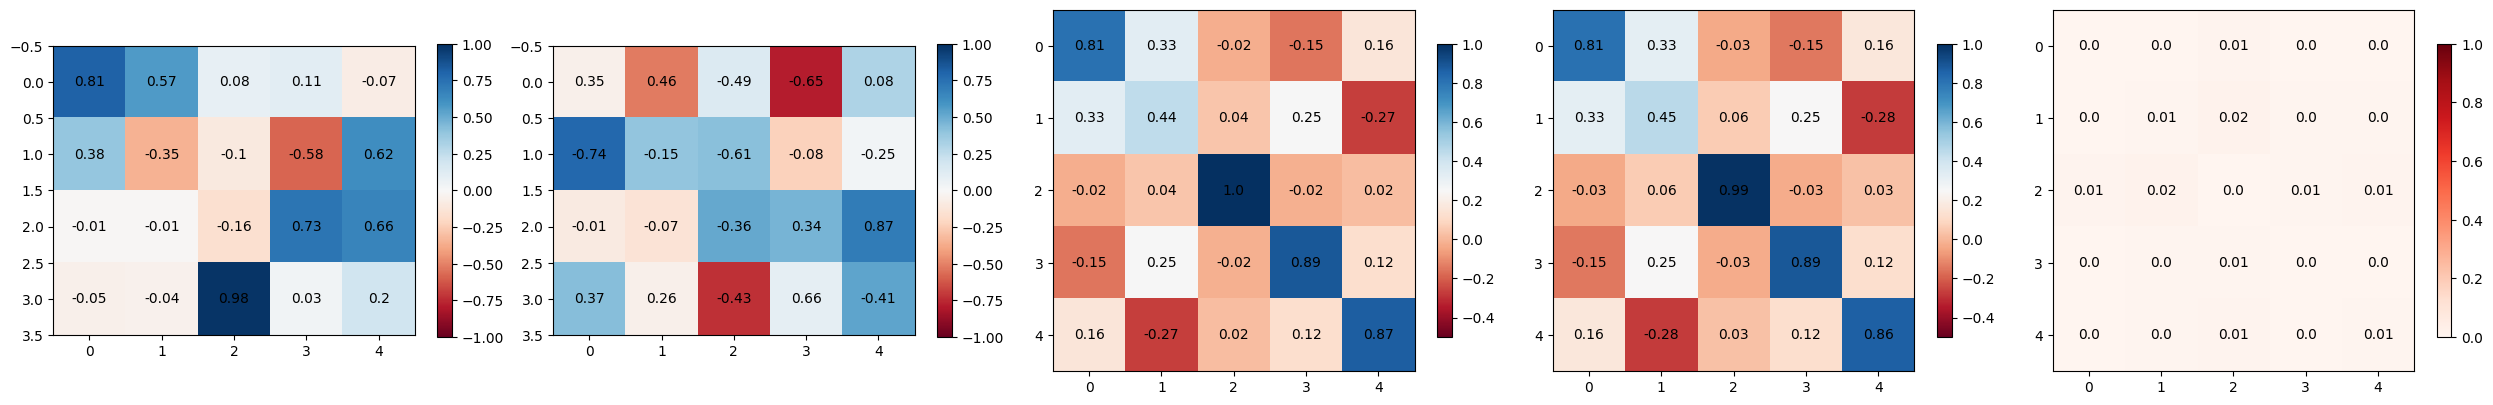

5: 5.655086e-03


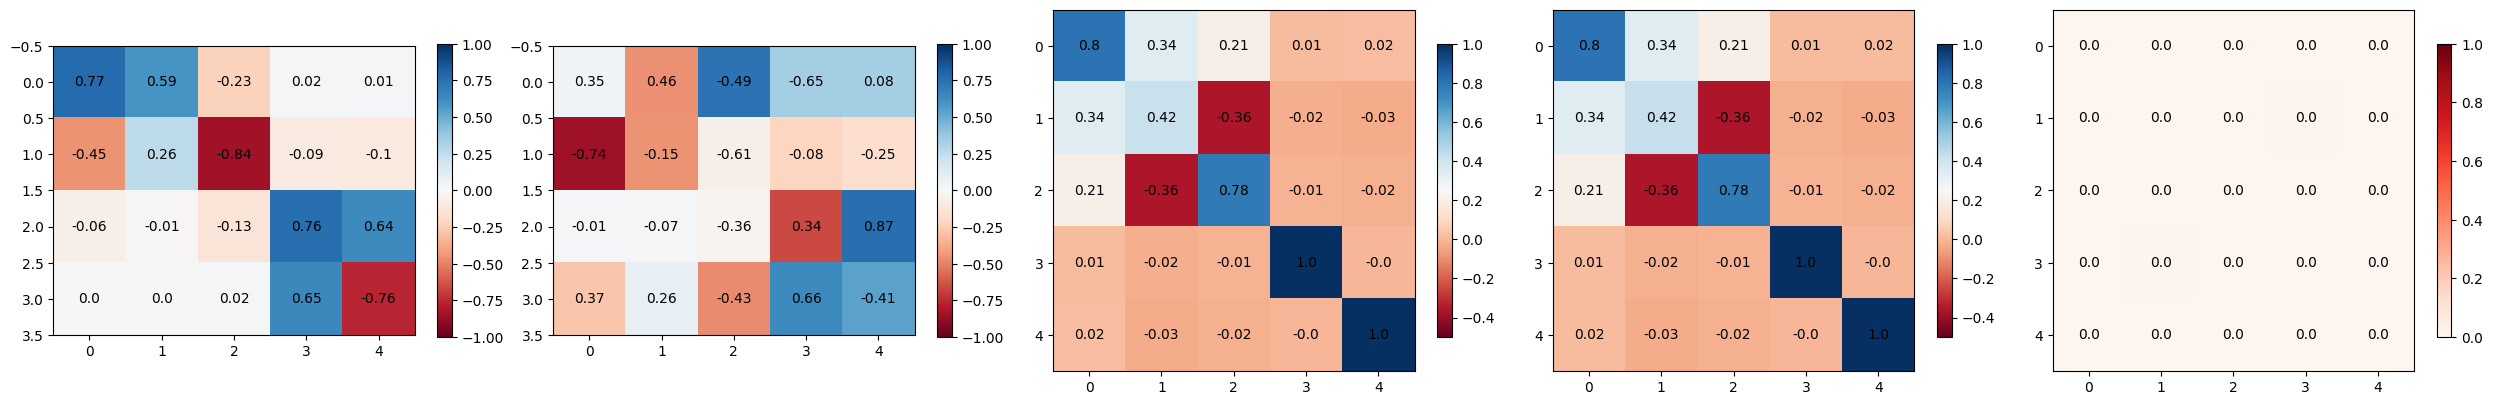

6: 1.641506e-03


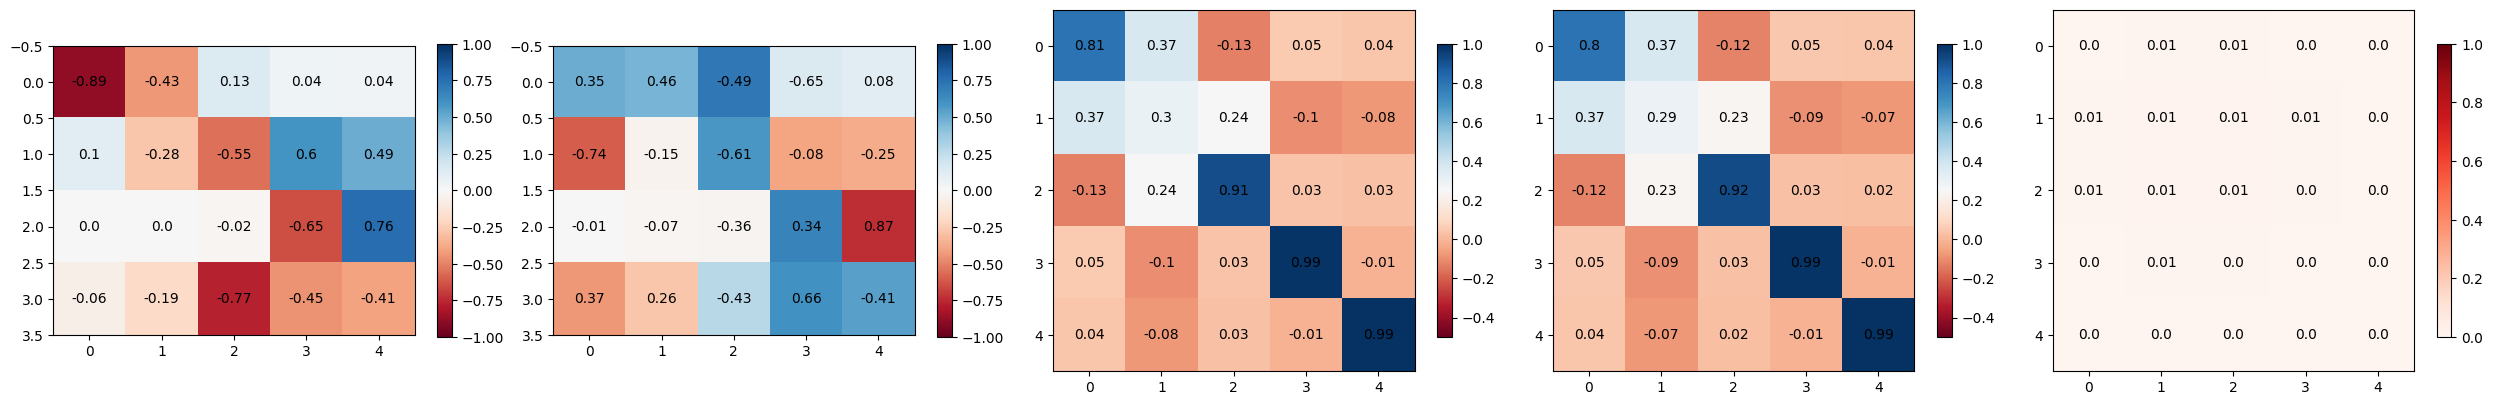

7: 4.682884e-03


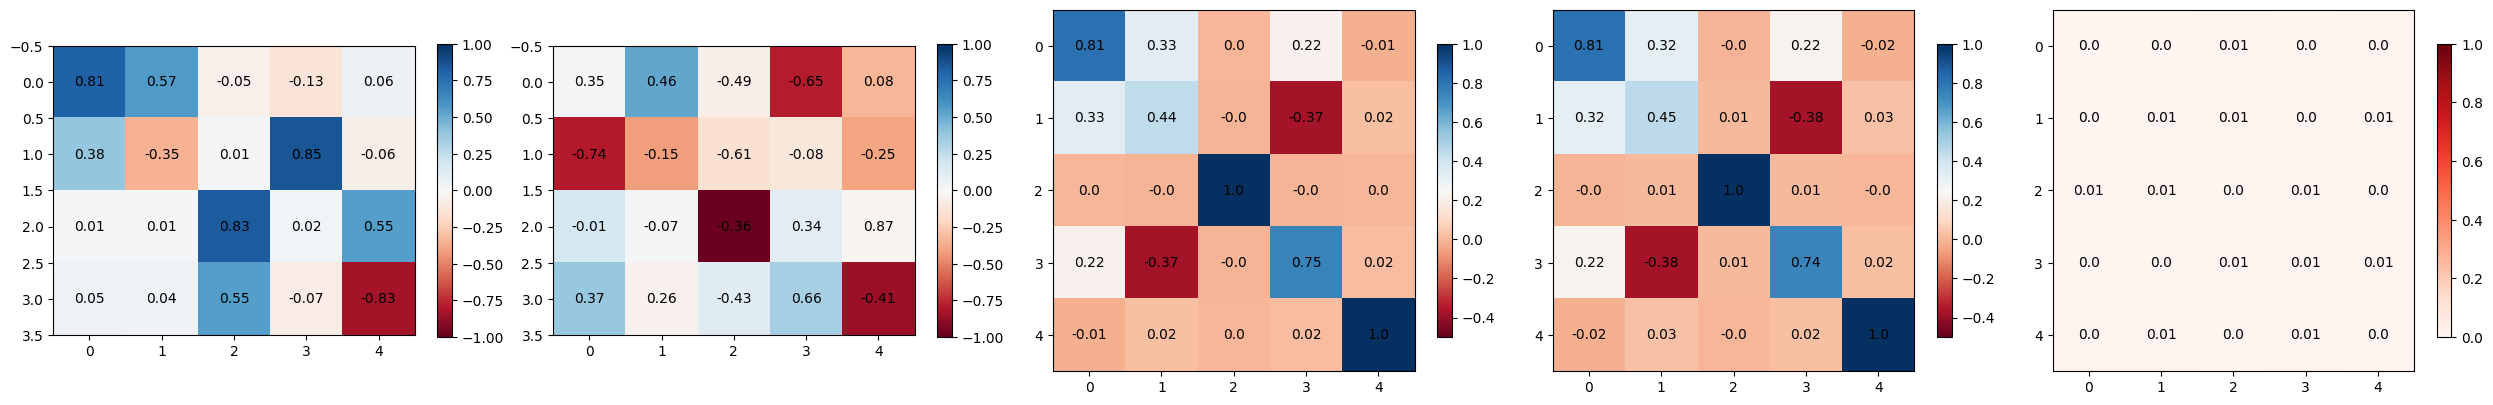

8: 4.706684e-03


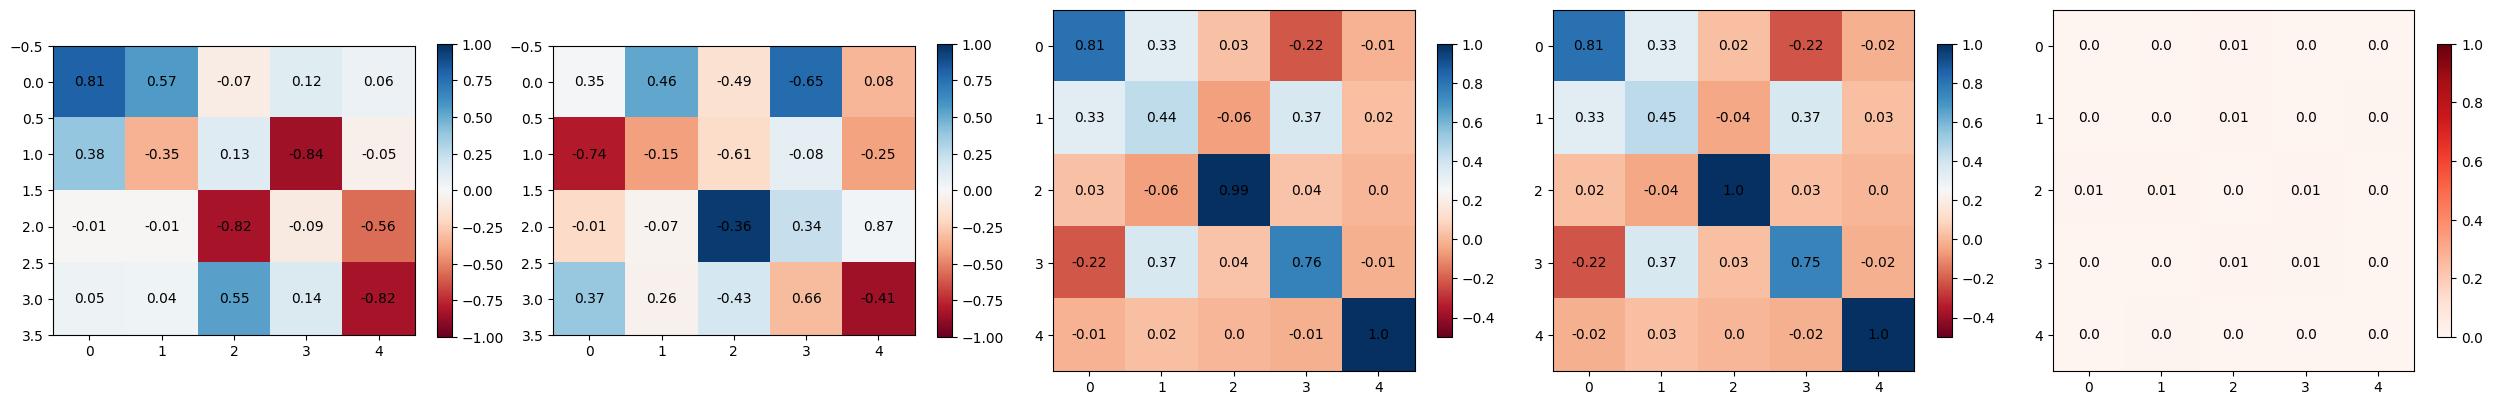

9: 4.391297e-03


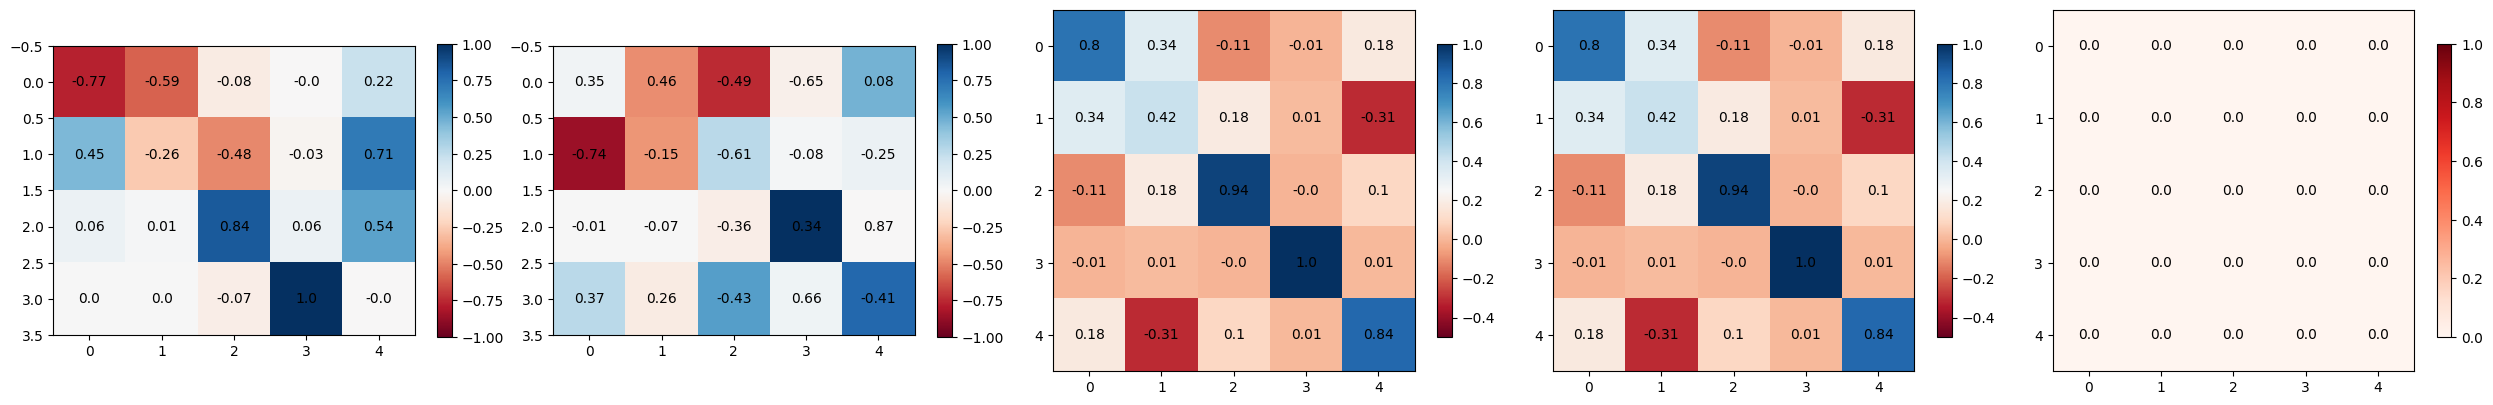

10: 1.952700e-04


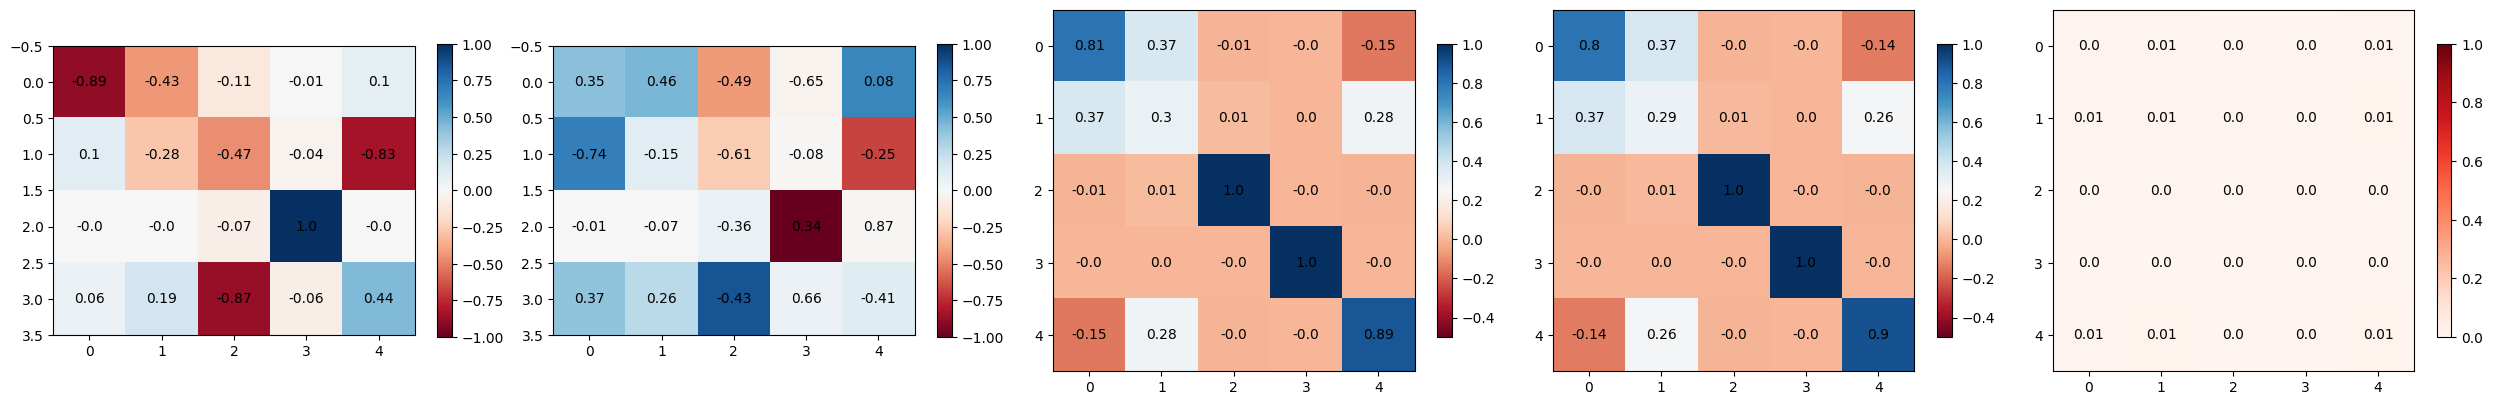

11: 3.957403e-03


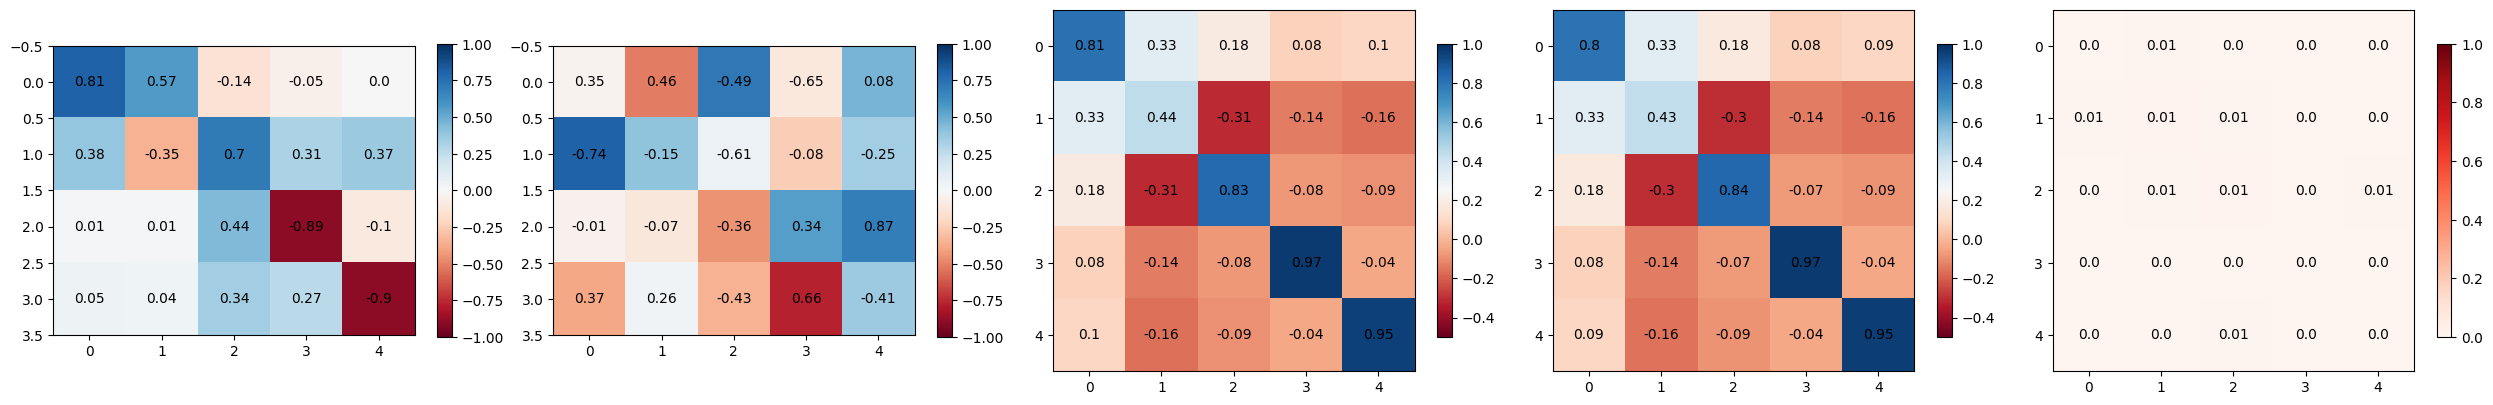

12: 3.441653e-03


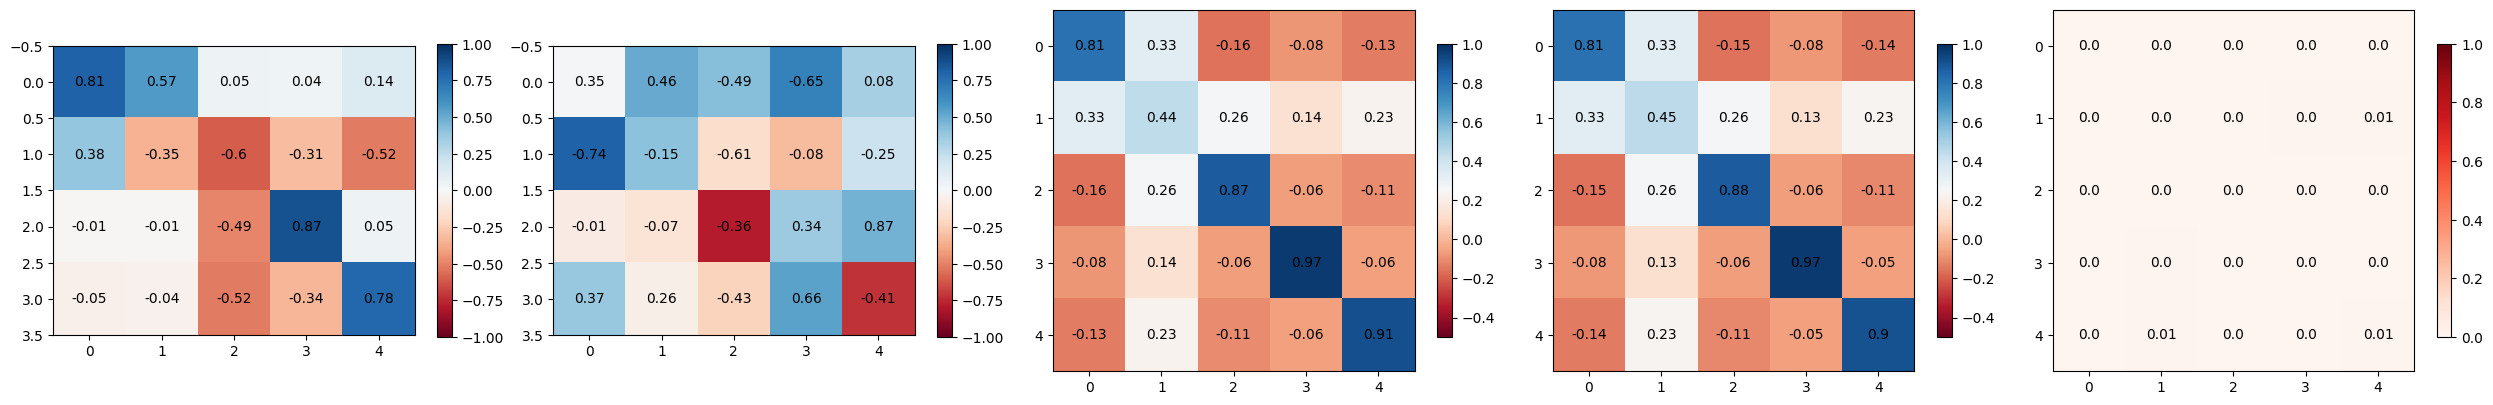

13: 2.373169e-03


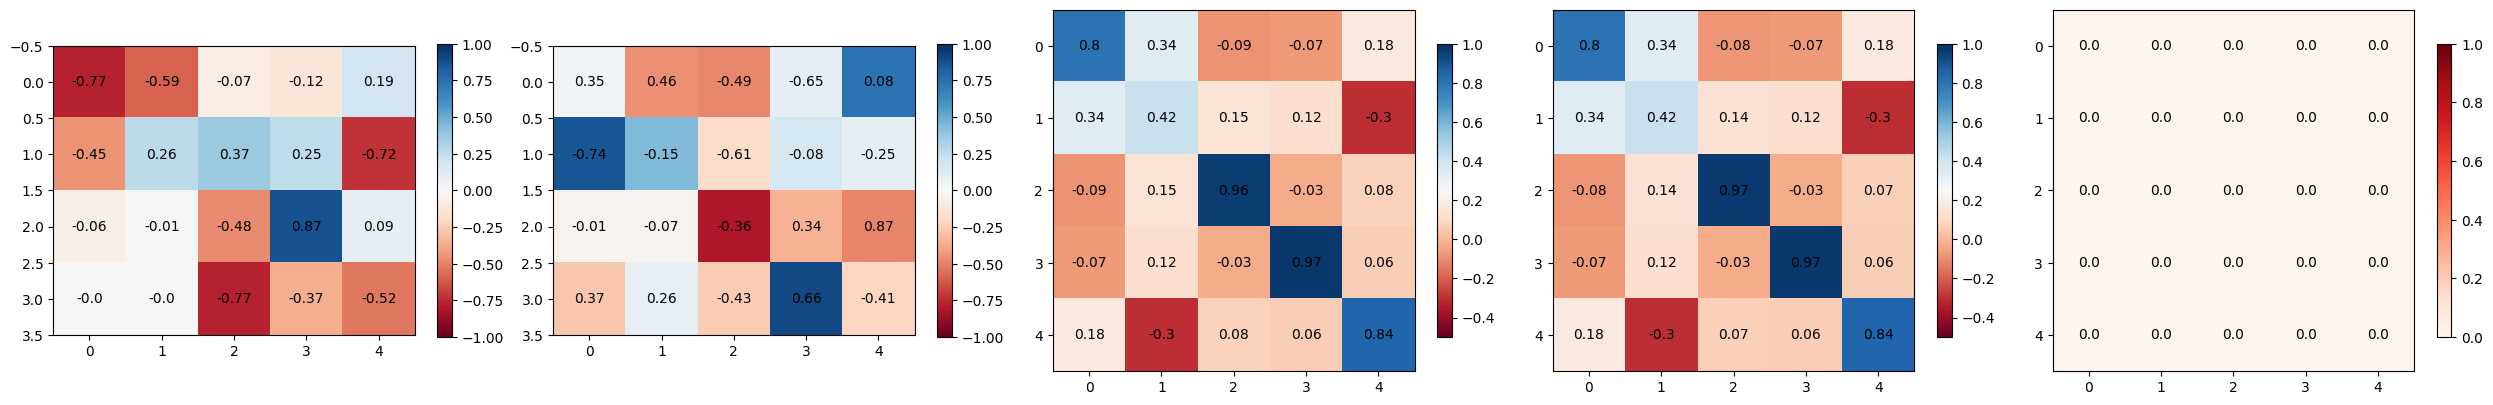

14: 1.350489e-03


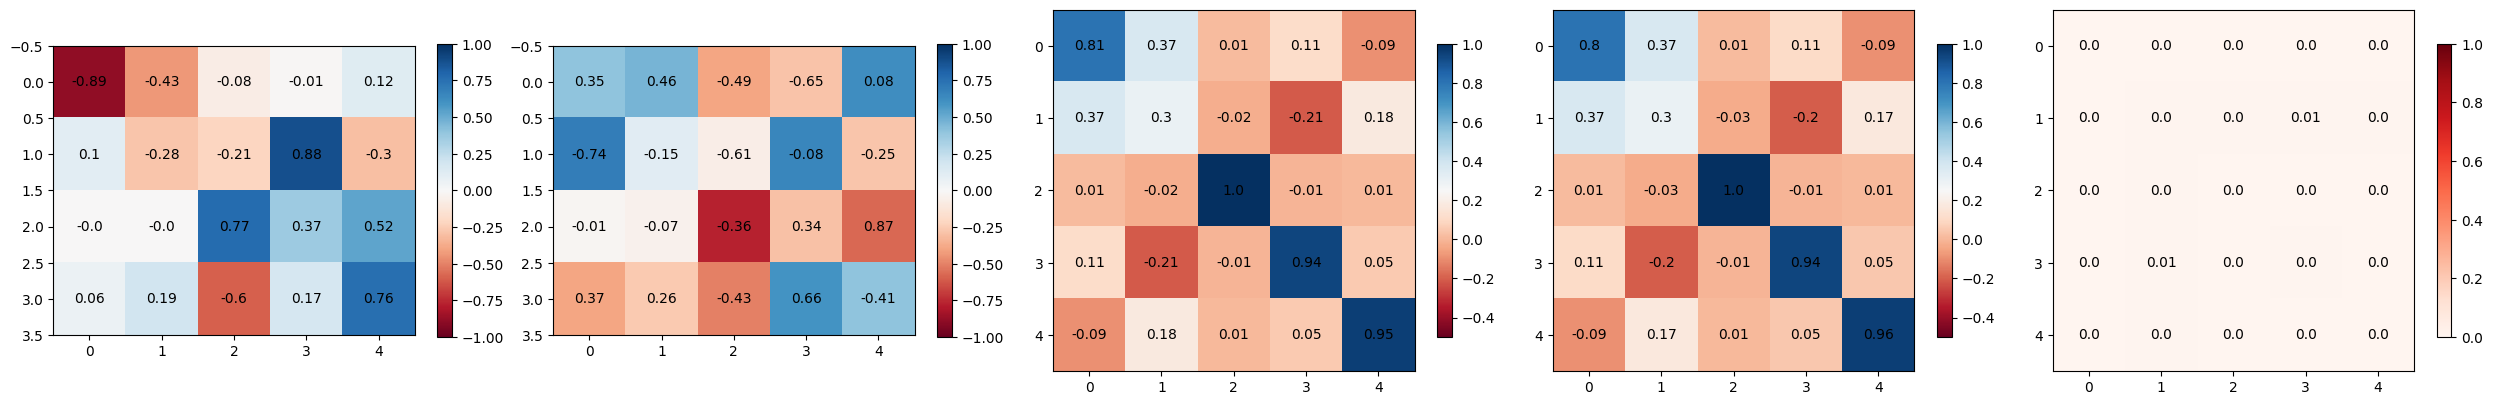

15: 3.004507e-03


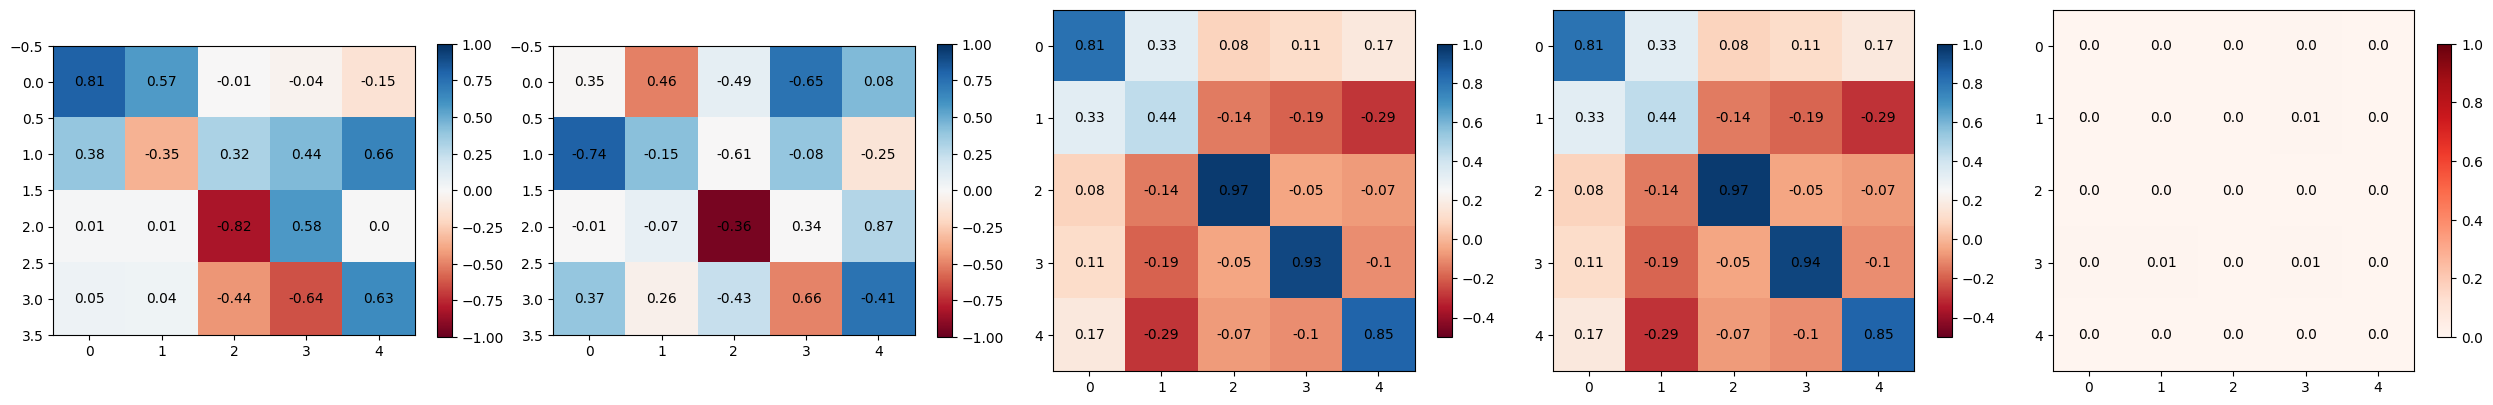

16: 2.338492e-03


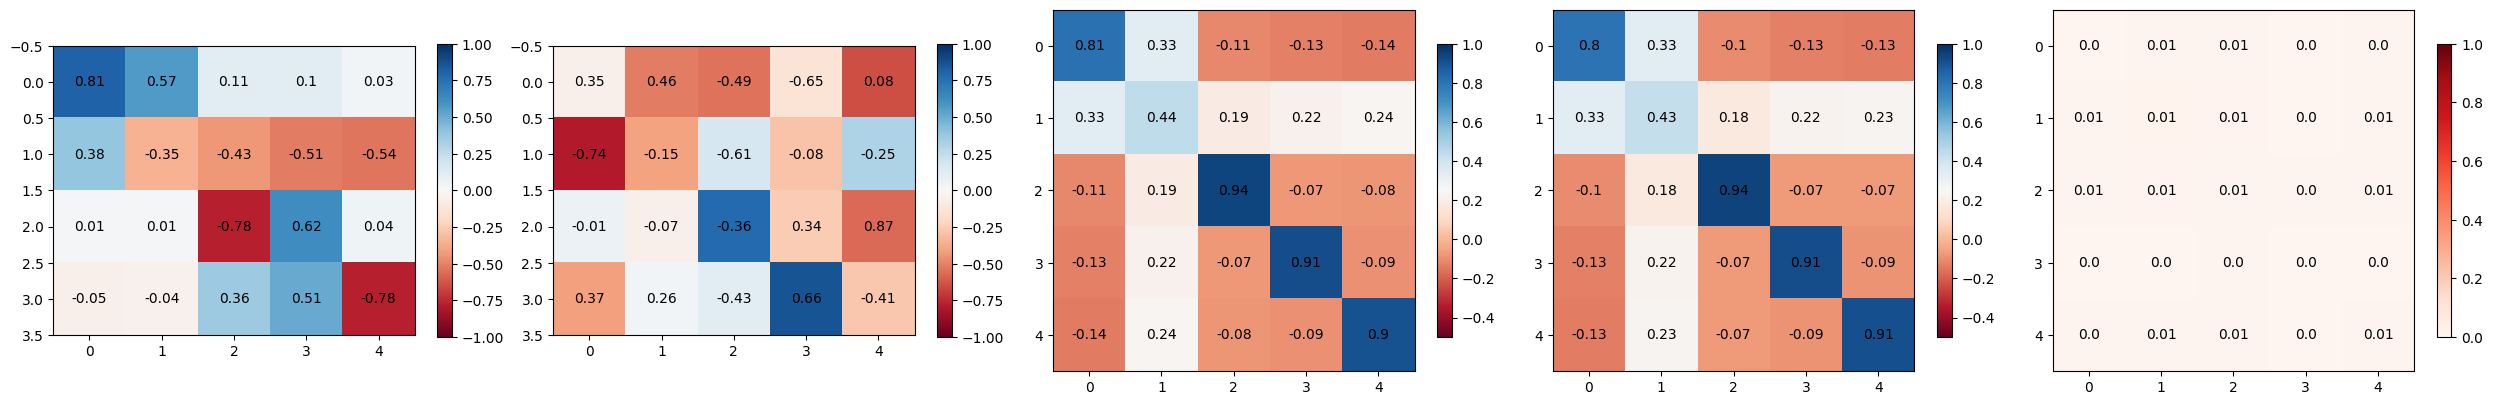

17: 5.281870e-03


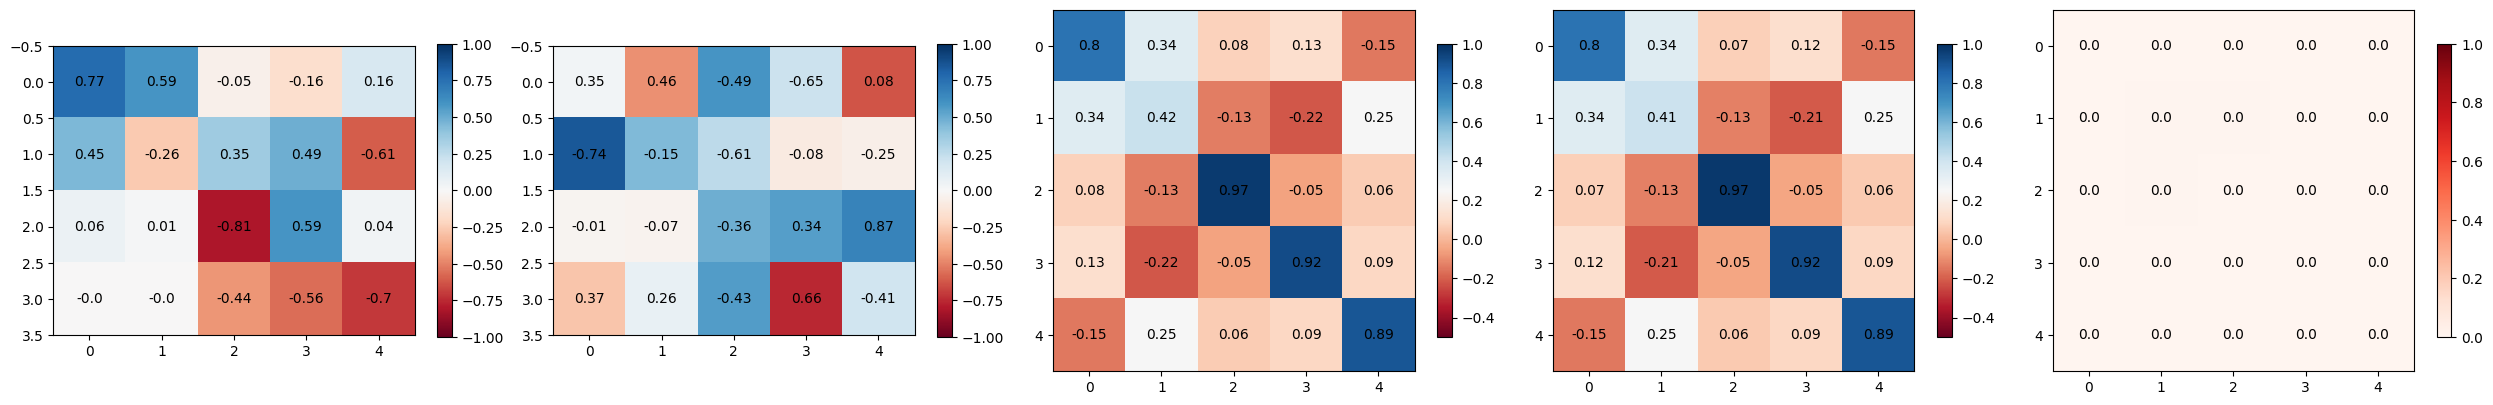

18: 2.401034e-03


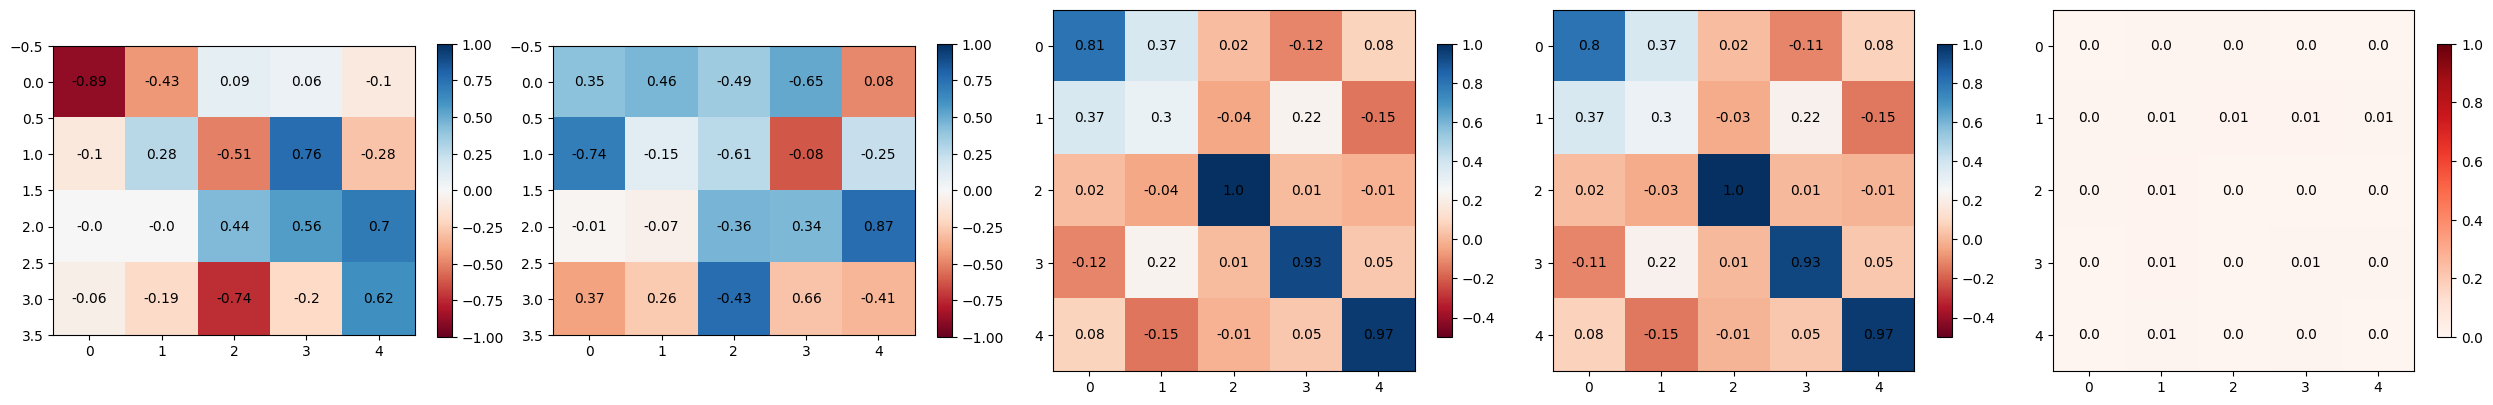

19: 4.793731e-03


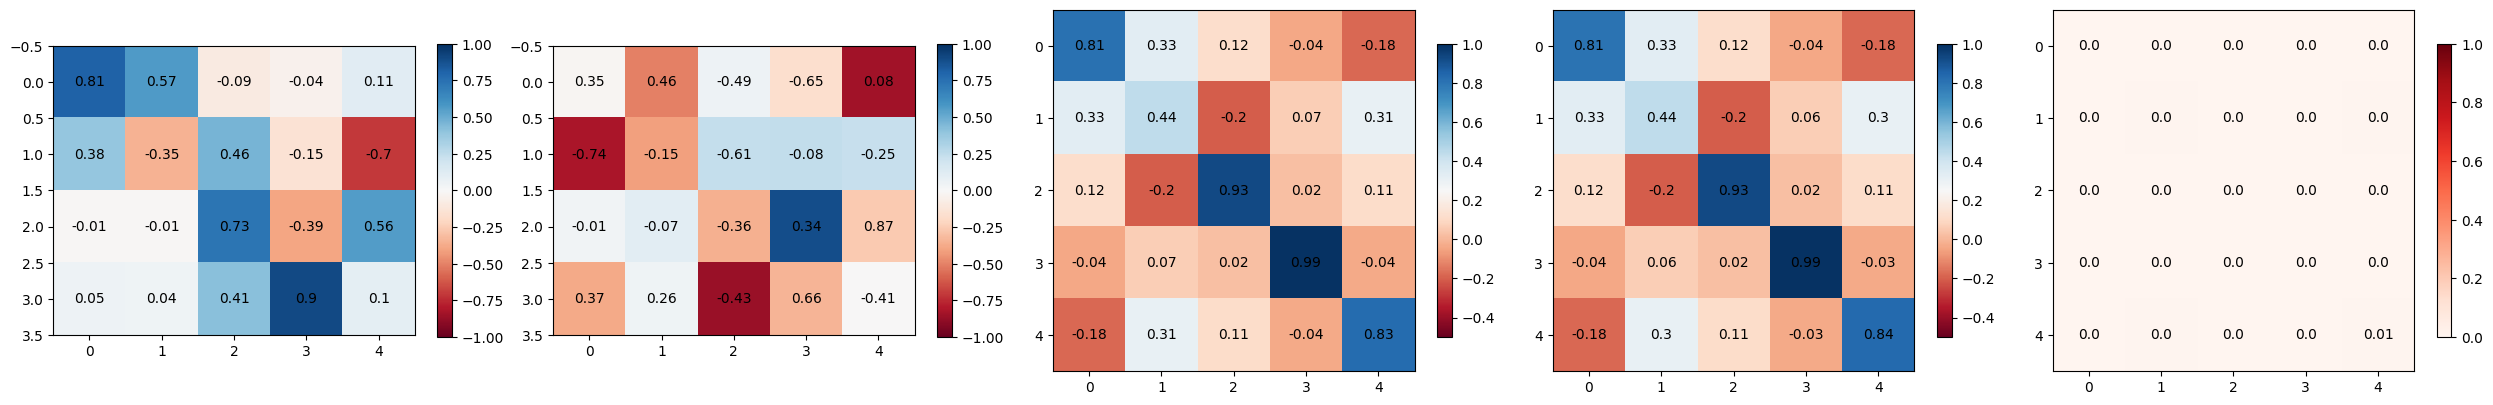

20: 1.673371e-03


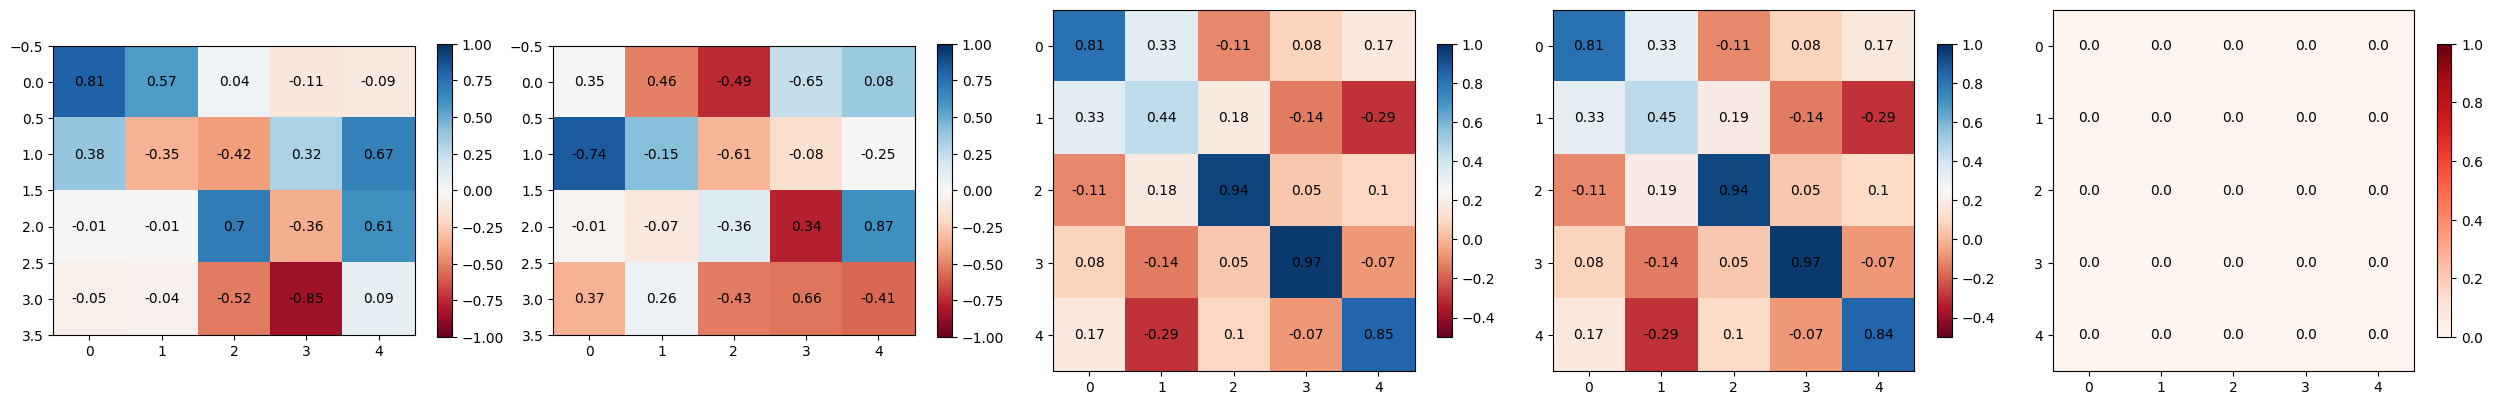

21: 1.856468e-03


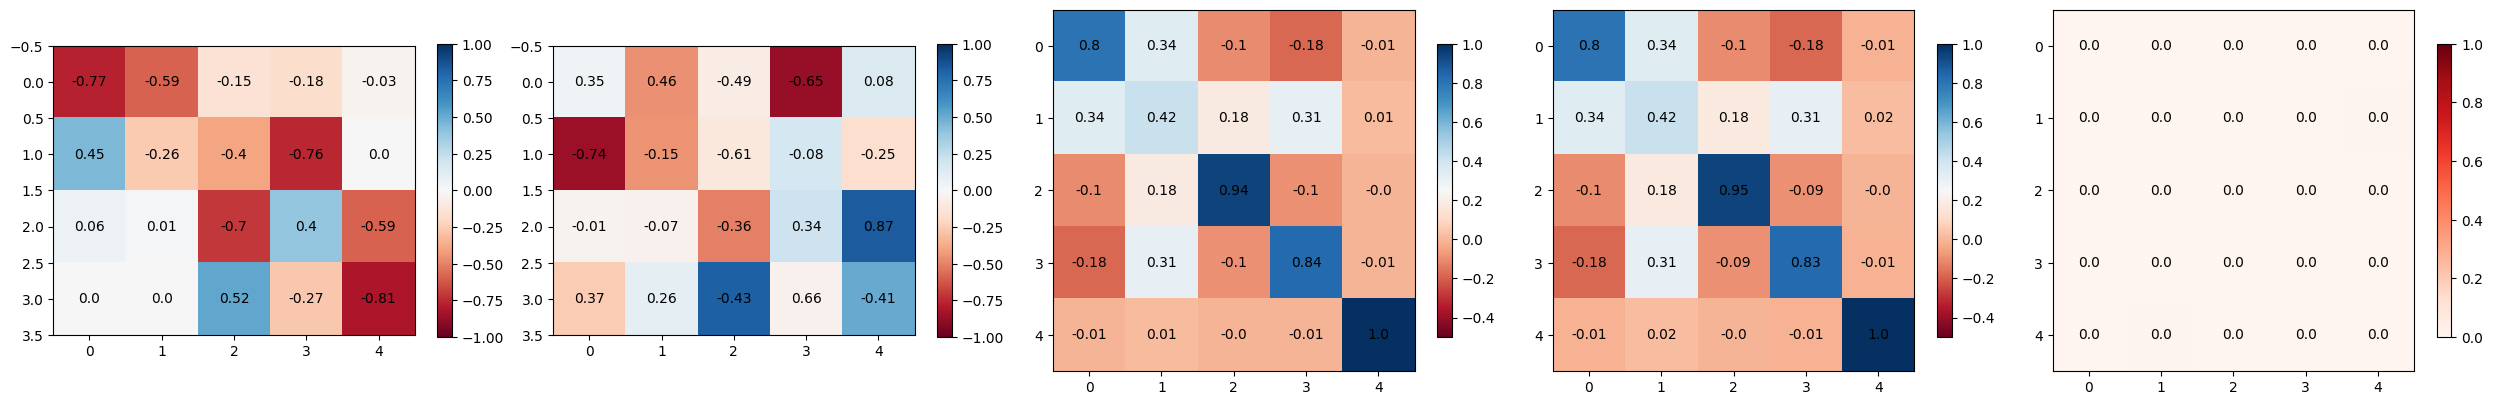

22: 1.713288e-03


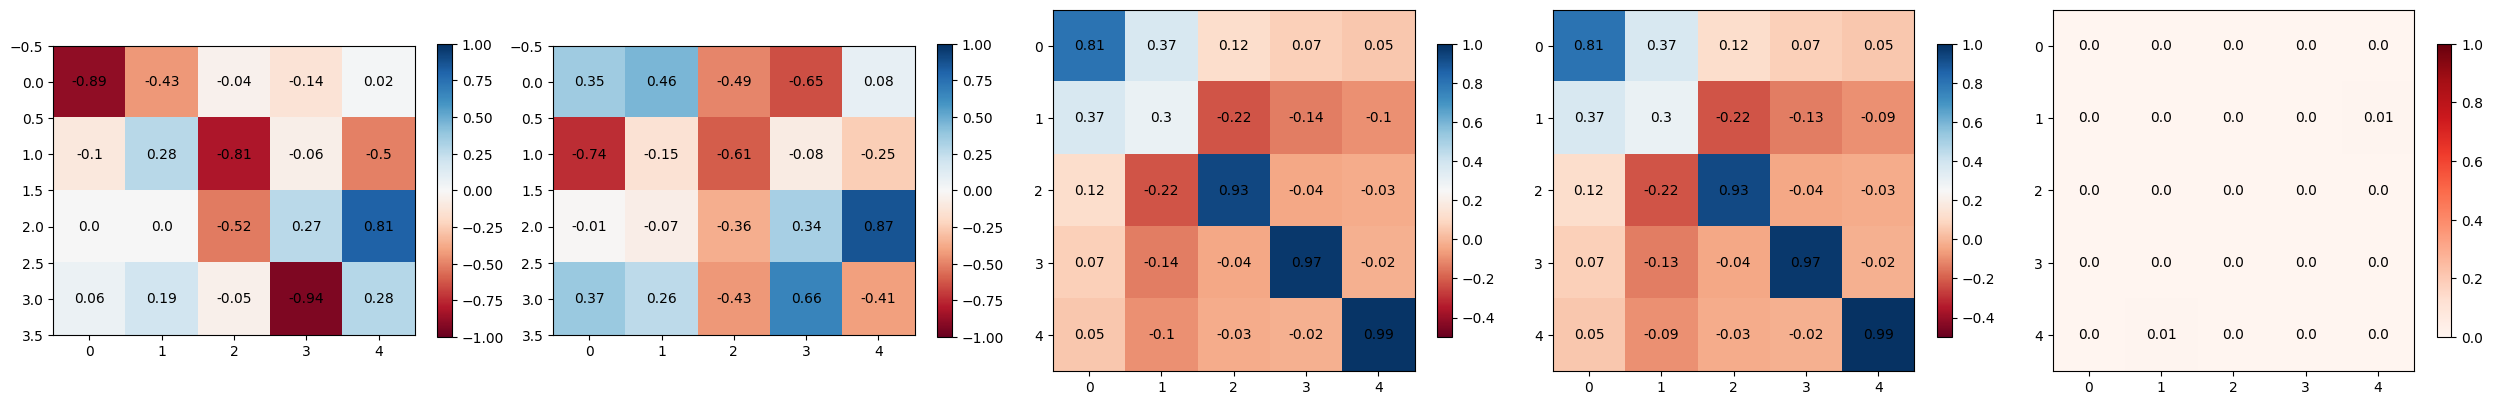

23: 1.740404e-03


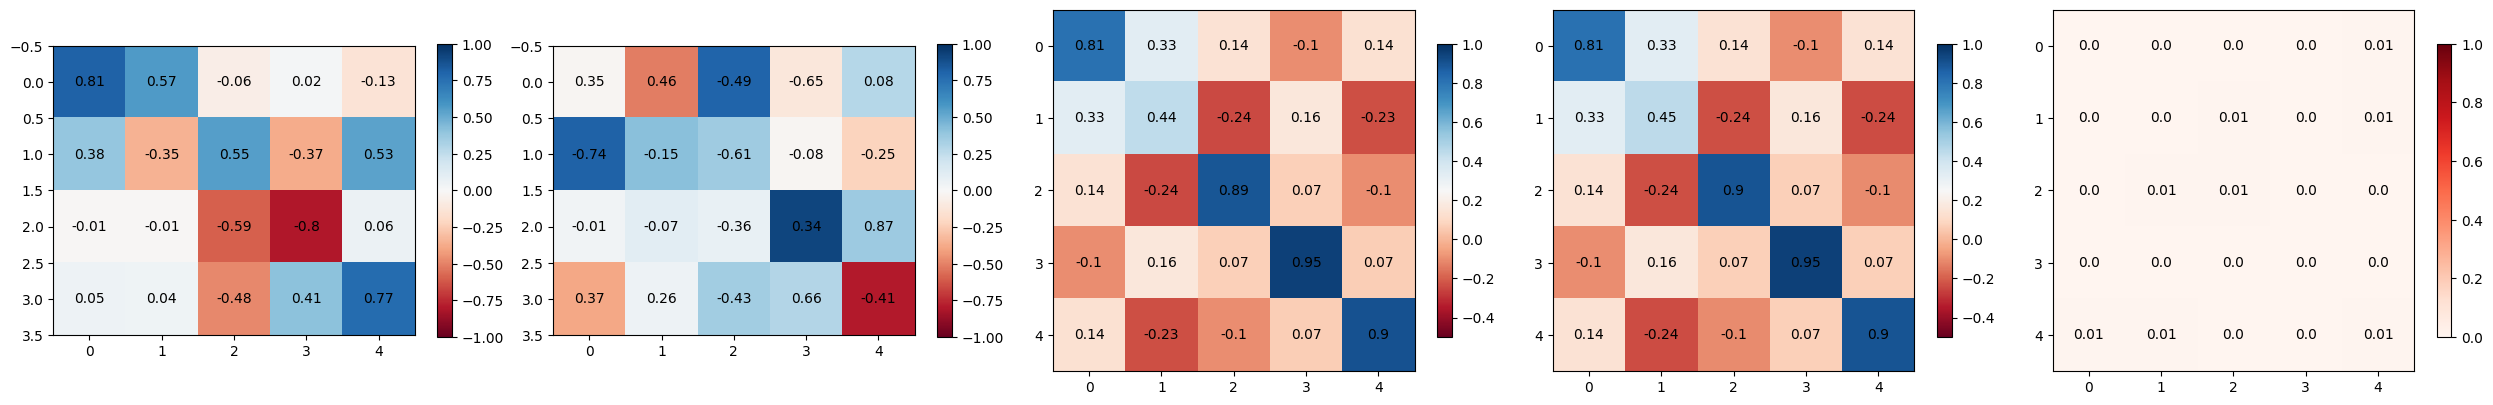

24: 3.227342e-03


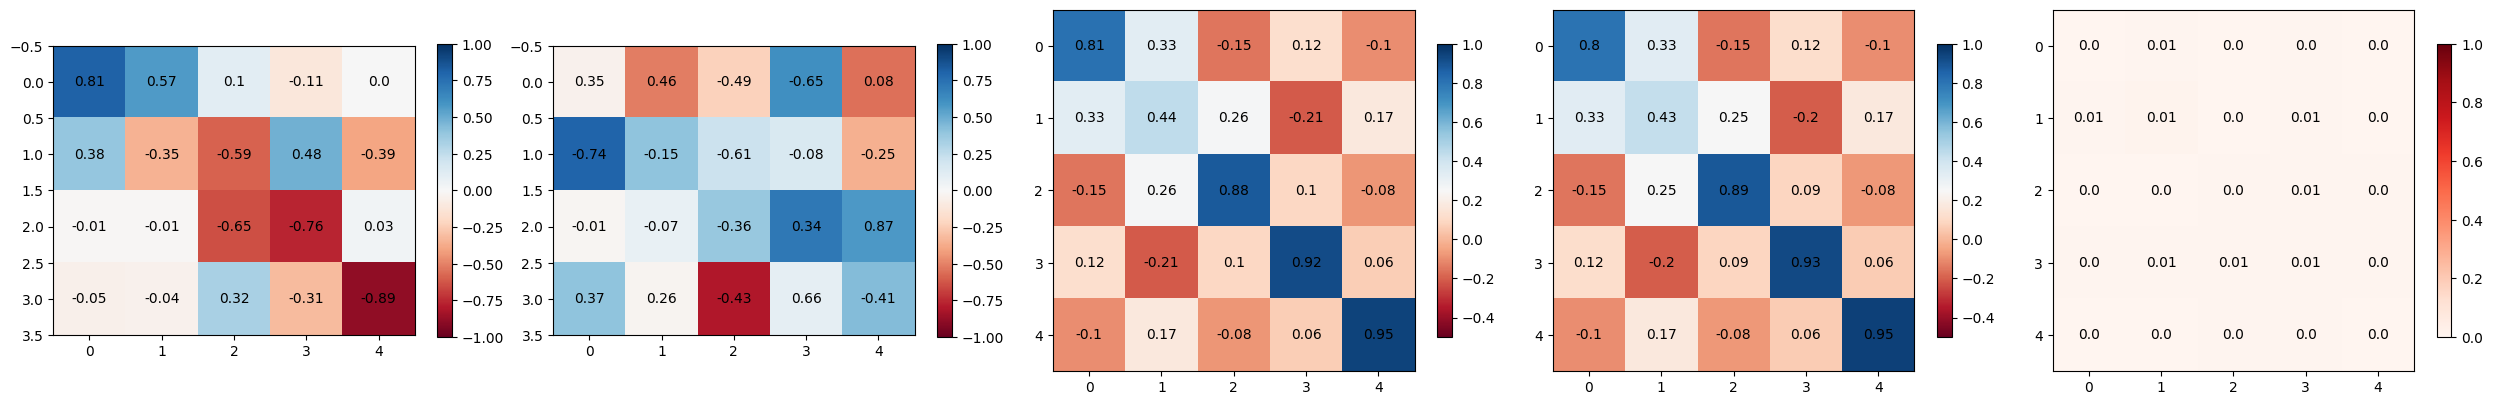

25: 4.621397e-03


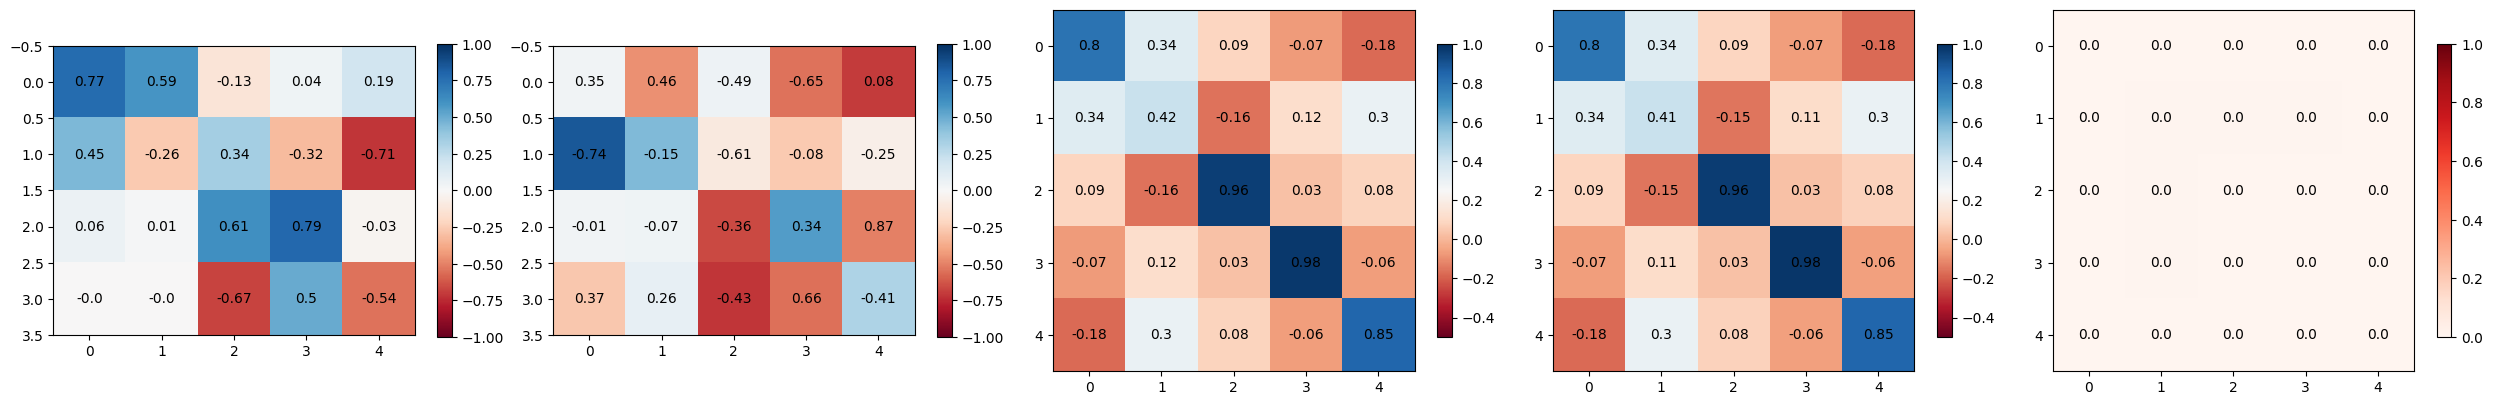

26: 2.425605e-03


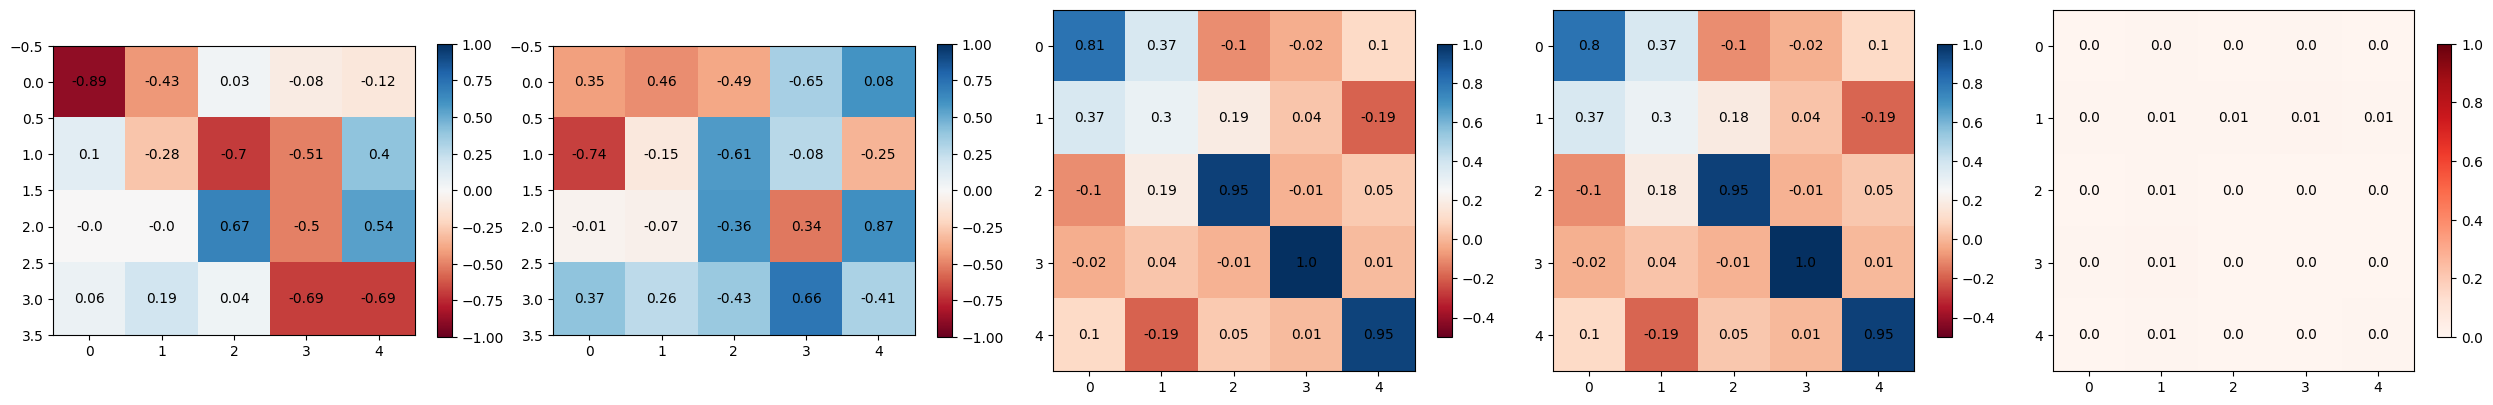

27: 4.355667e-03


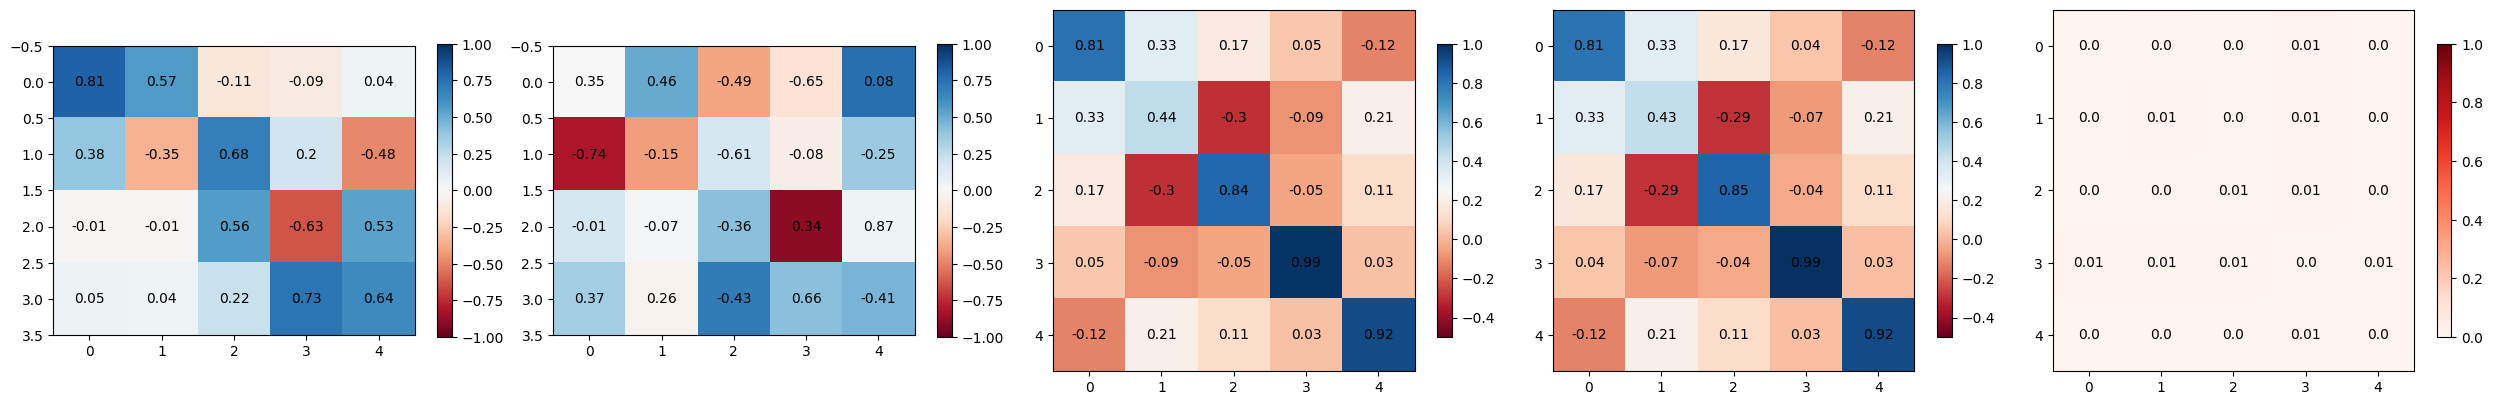

28: 5.248507e-03


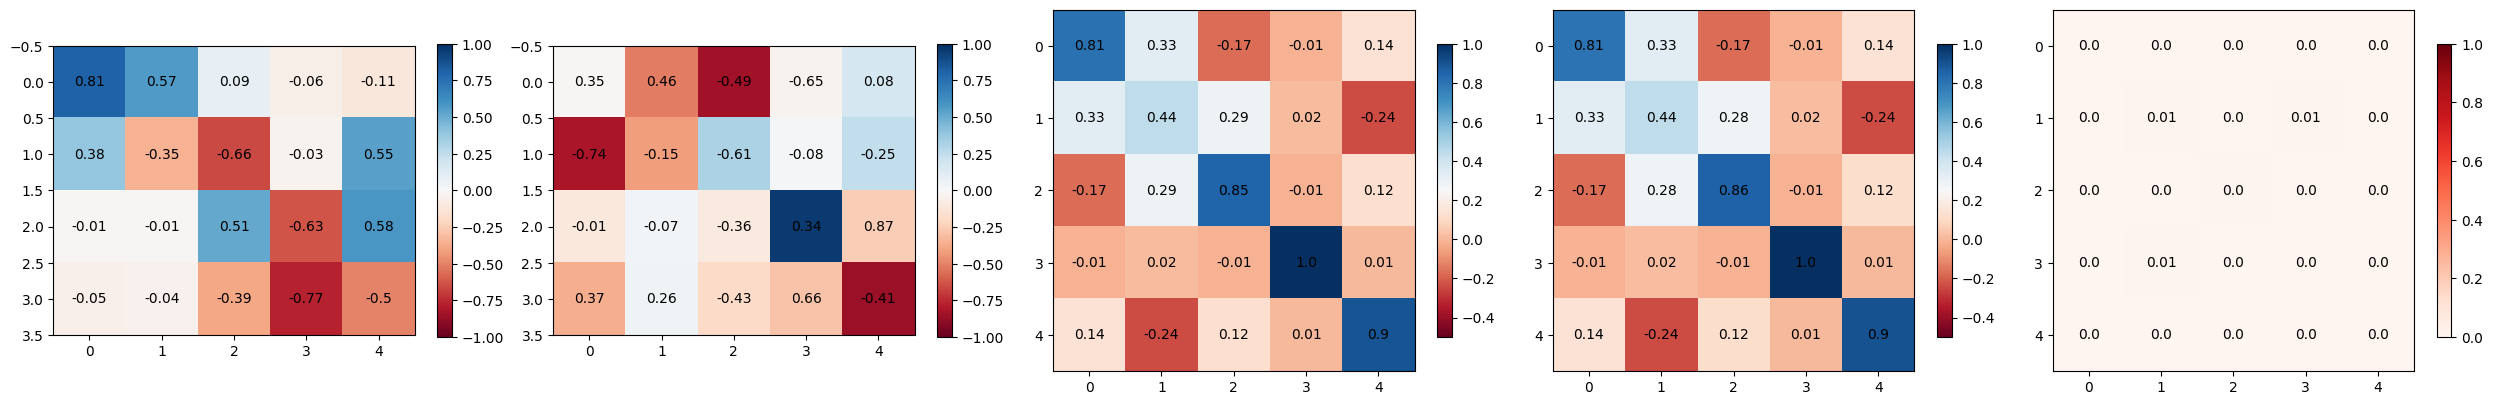

29: 2.557275e-03


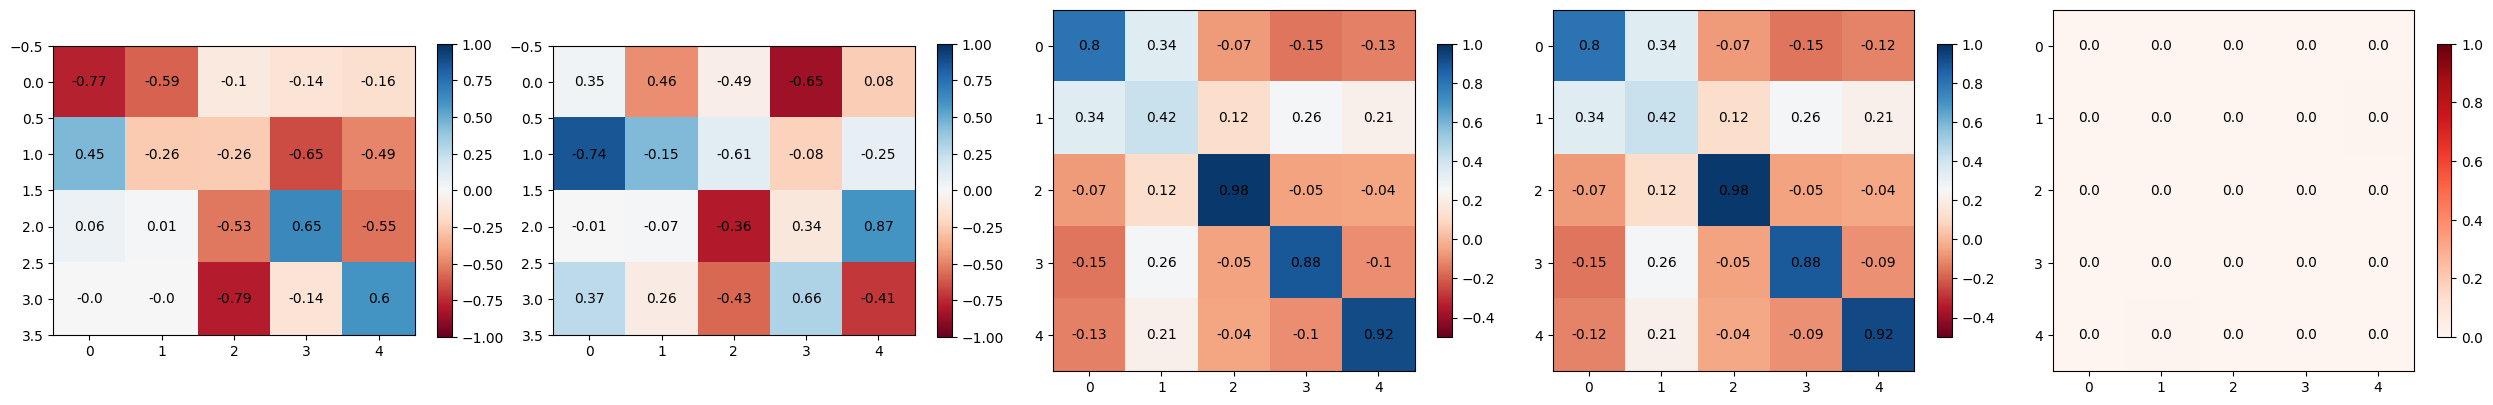

30: 1.664175e-03


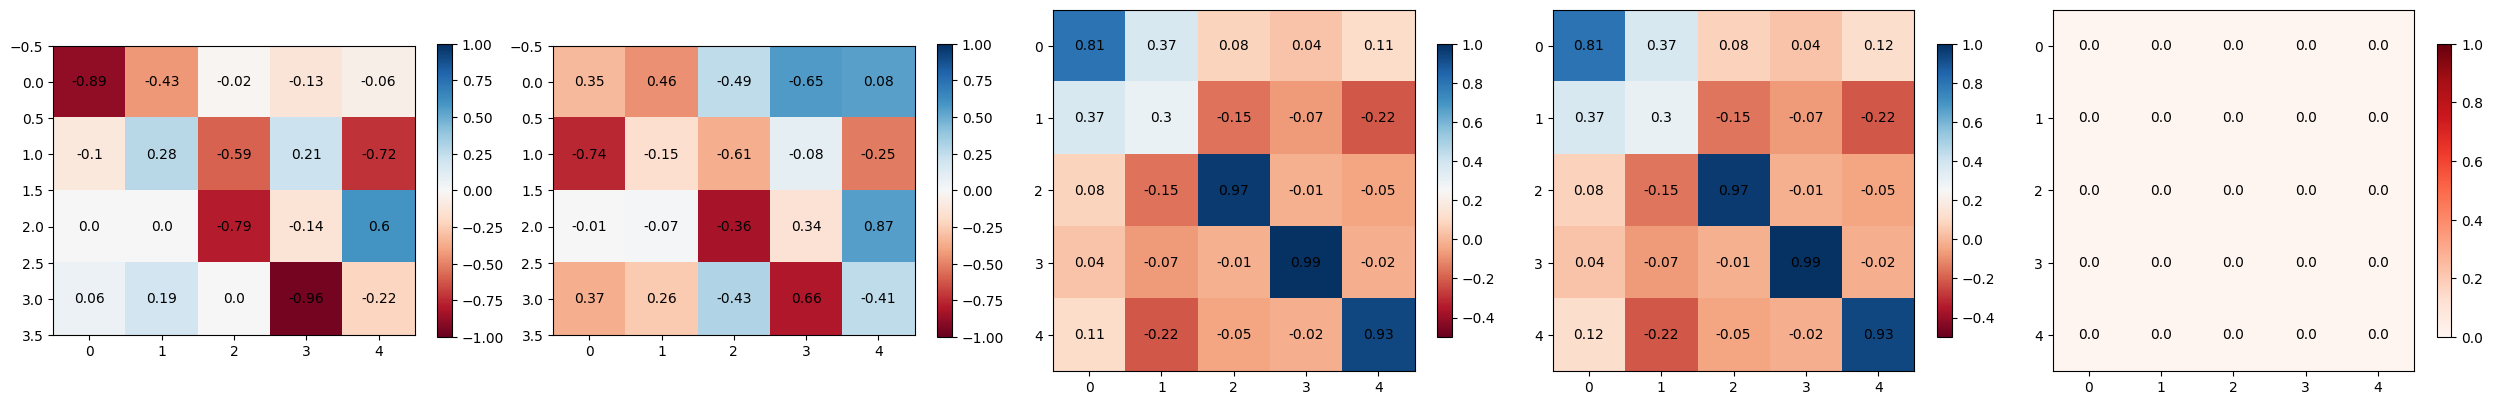

31: 1.129034e-03


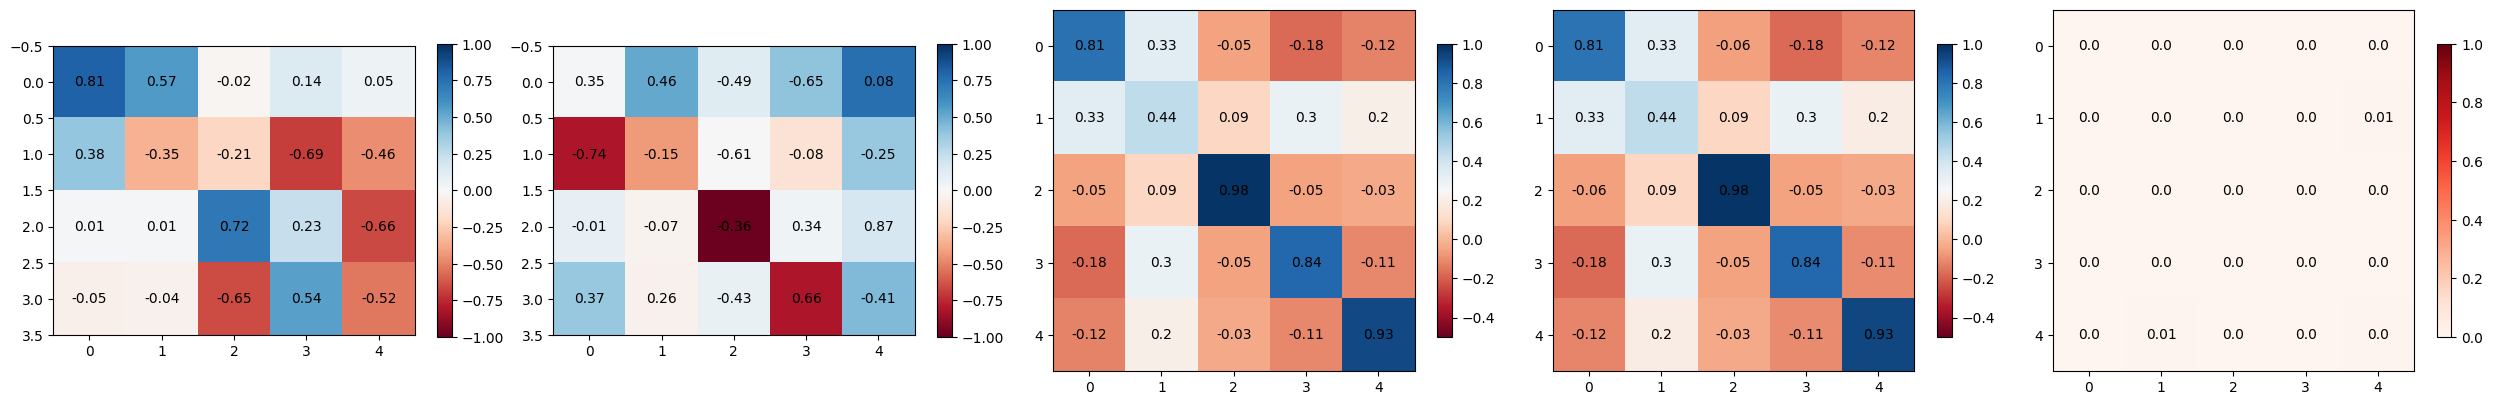

32: 2.244980e-03


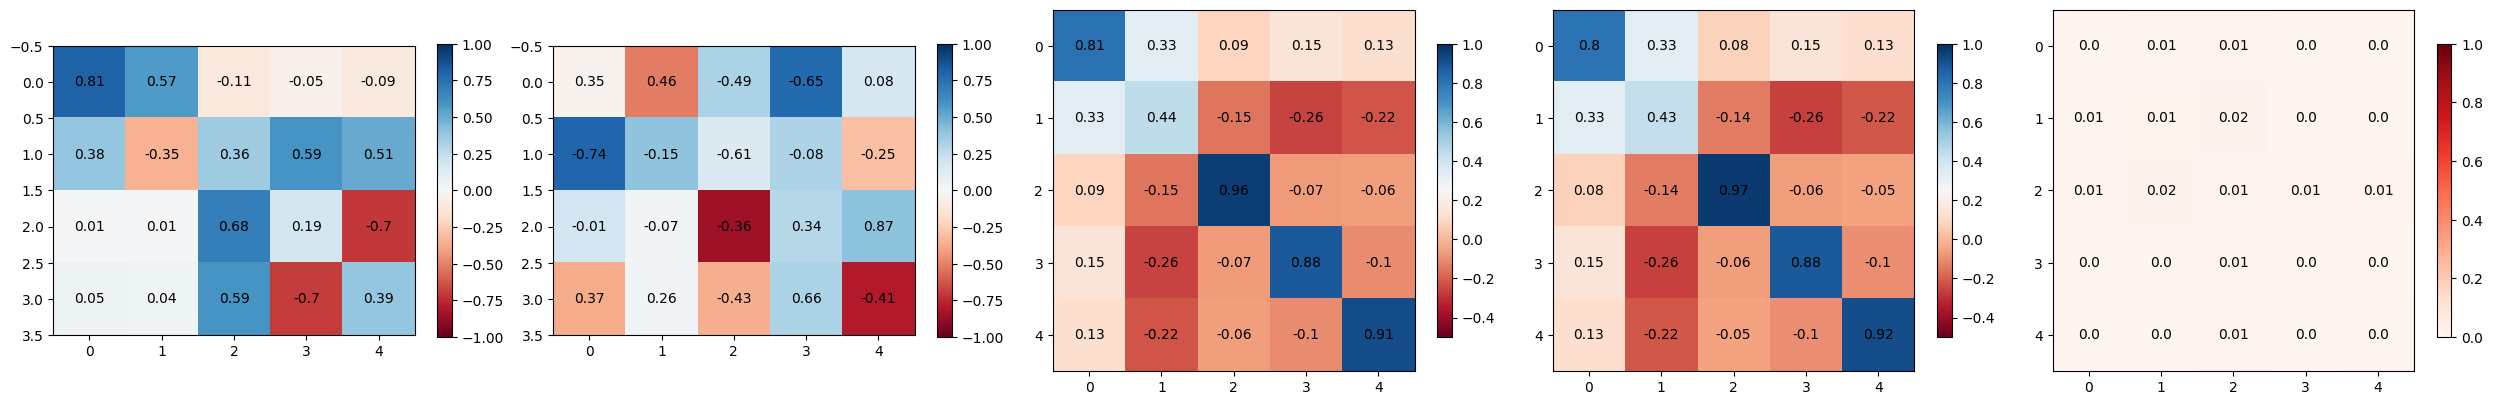

33: 6.519205e-03


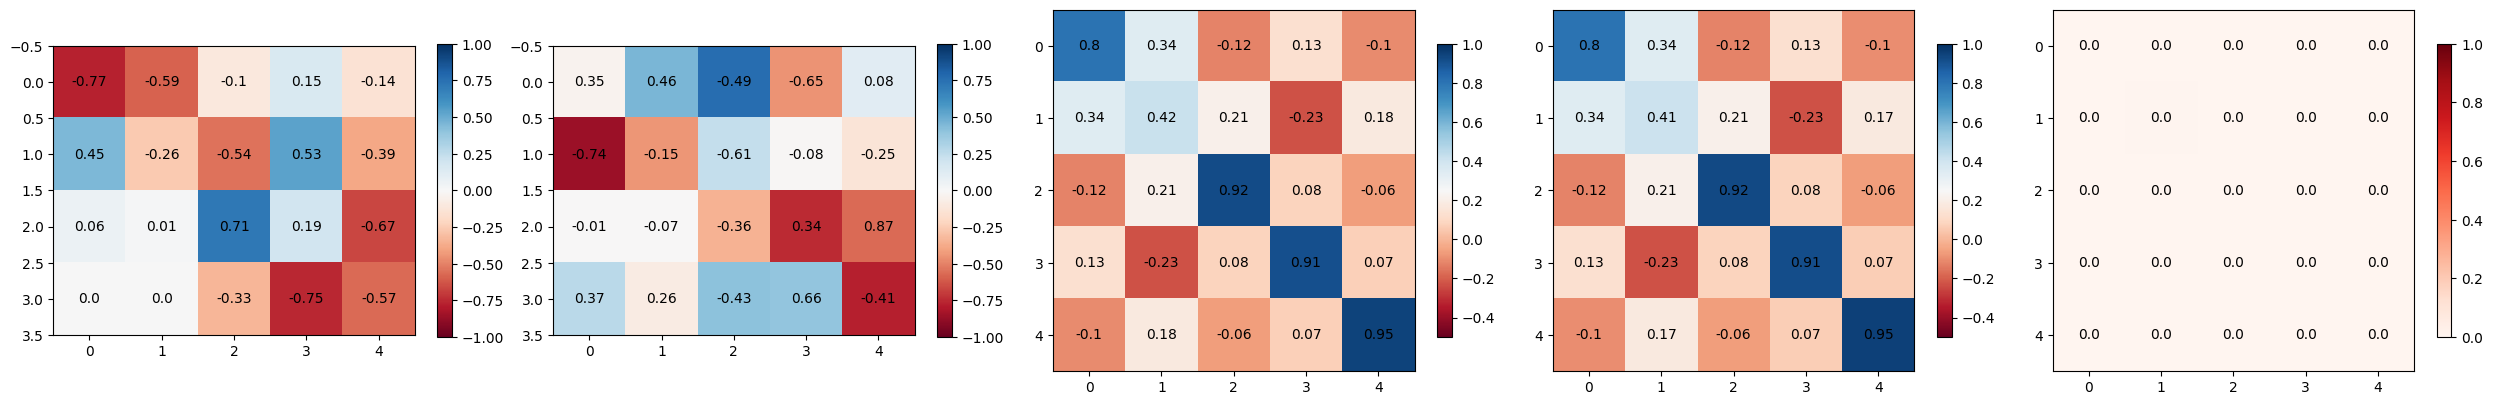

34: 1.836487e-03


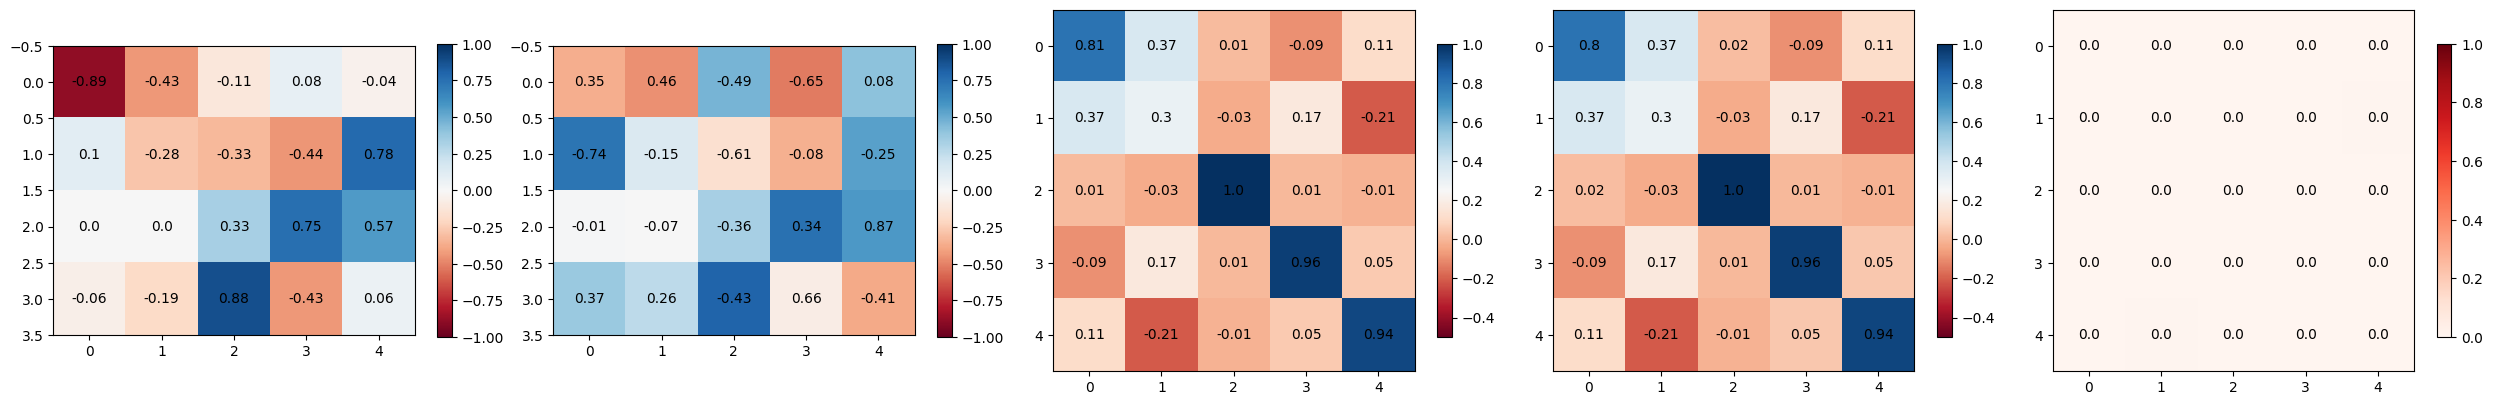

35: 1.919791e-03


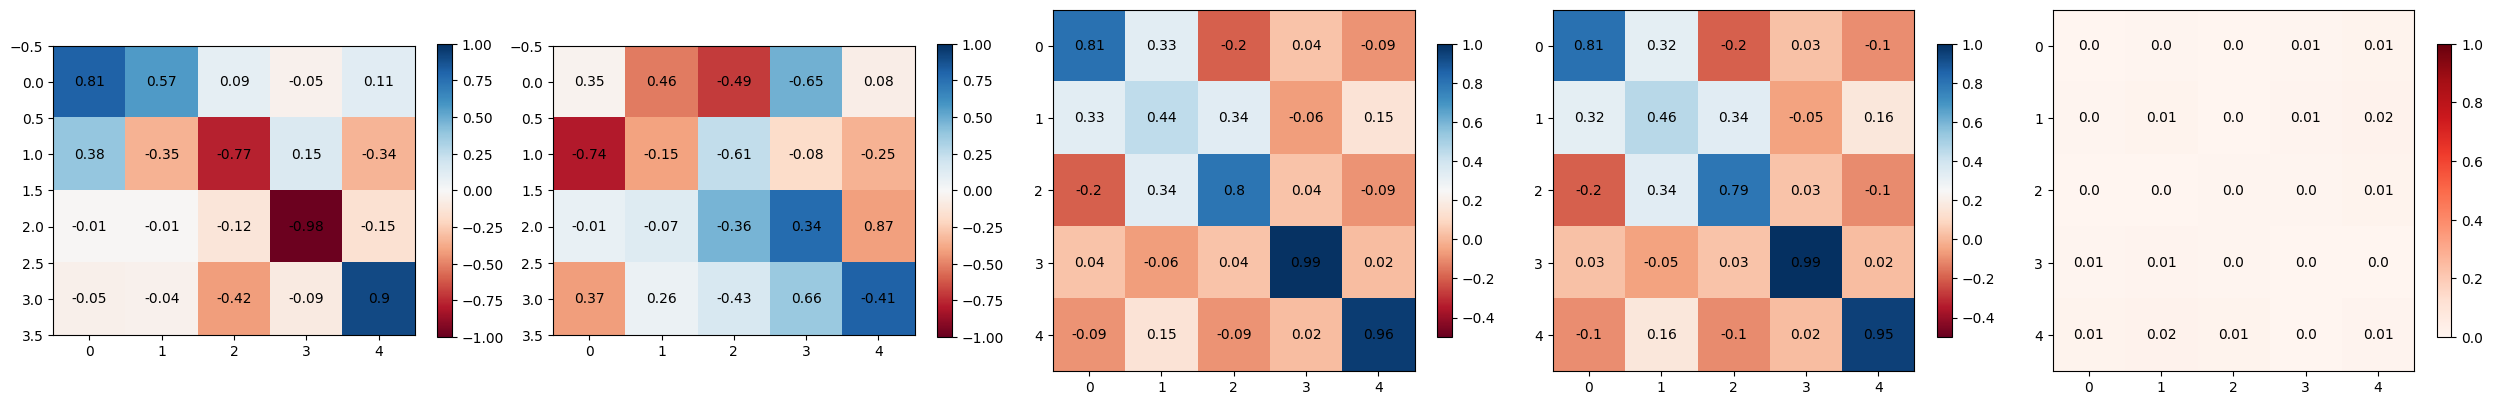

36: 6.810742e-03


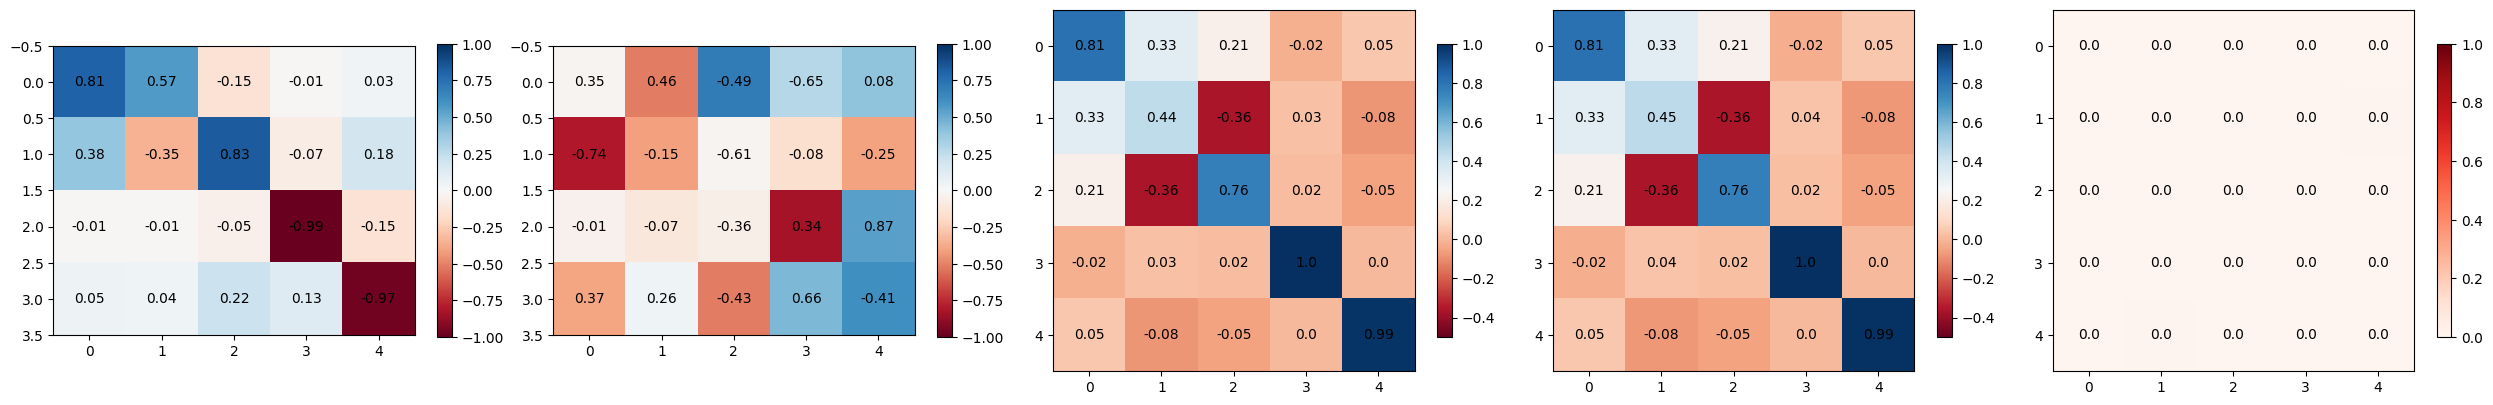

37: 2.124446e-03


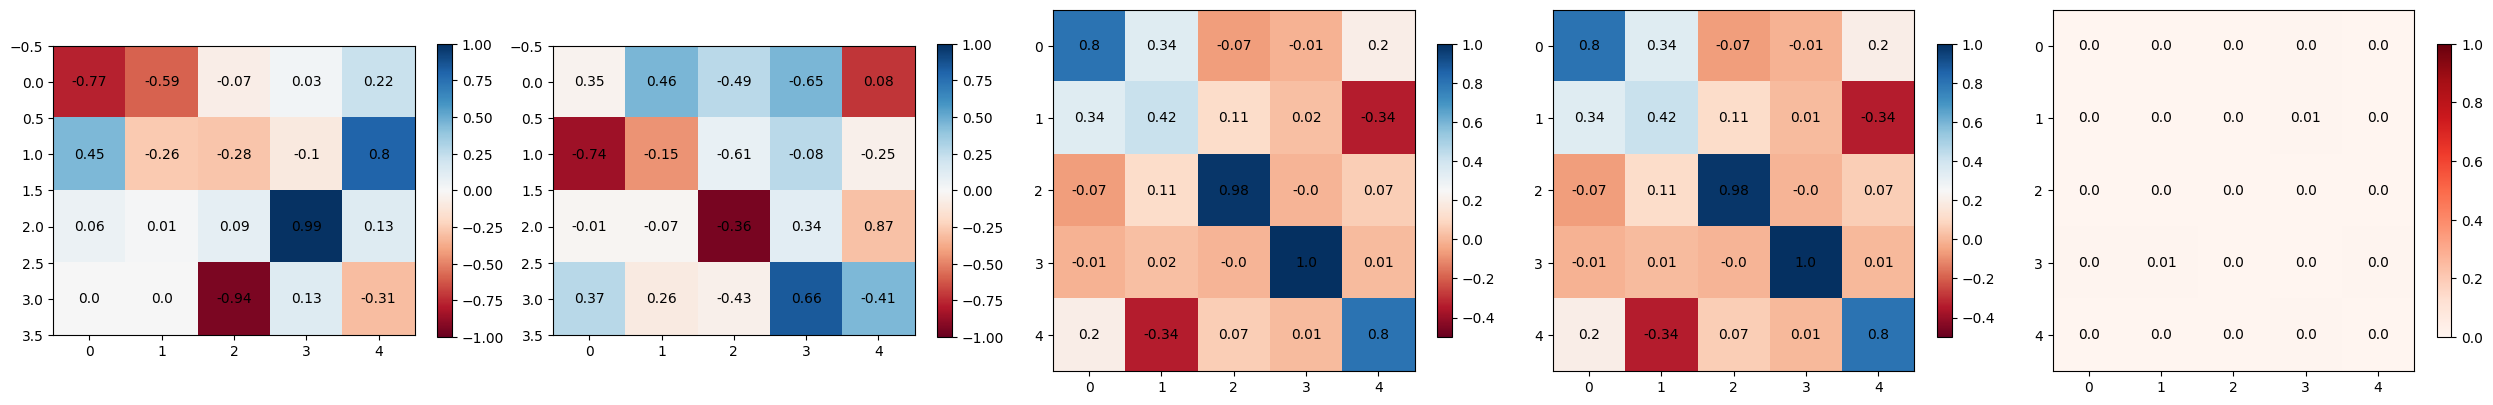

38: 2.256573e-03


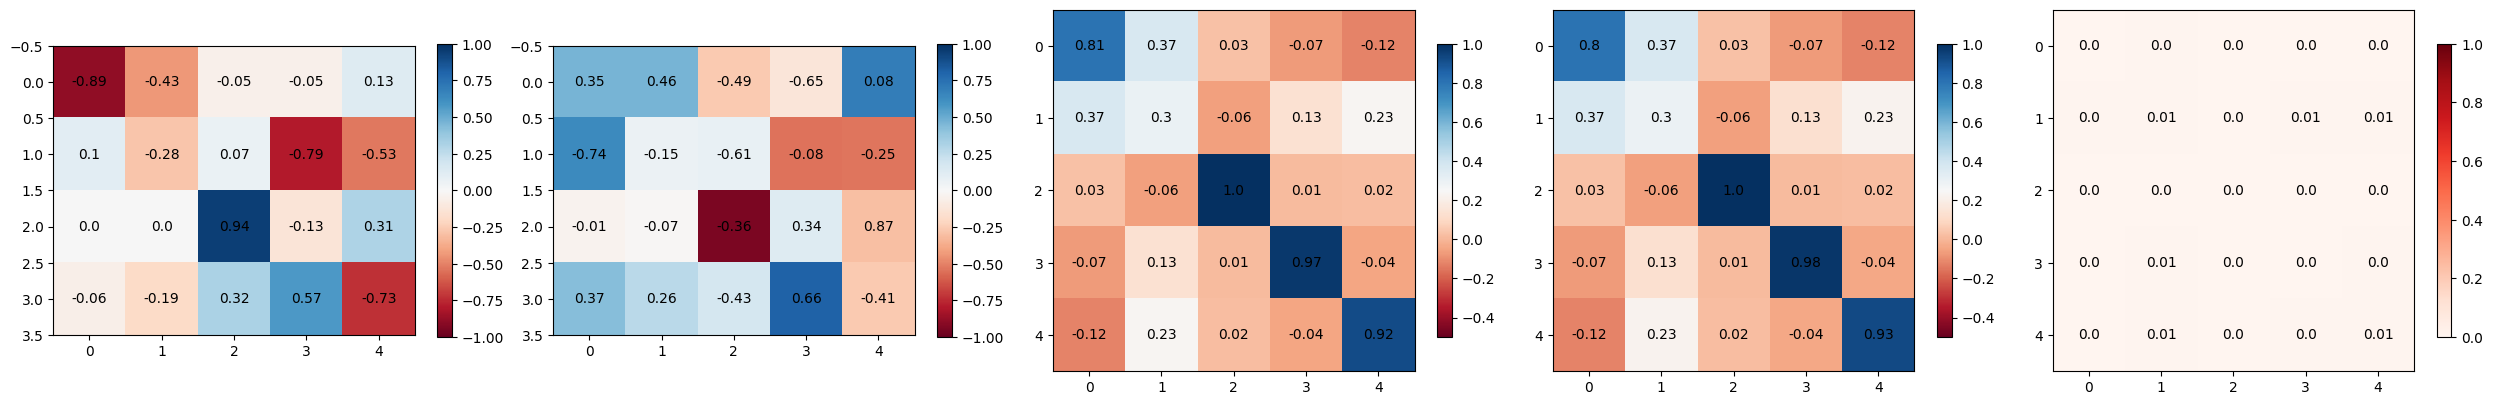

39: 3.502934e-03


In [118]:
prim_basis_spec = prim_basis_specs["H"]
prim_basis_size = o3.Irreps(prim_basis_spec).dim

for idx, pao_object in enumerate(test_data_H):
    label = pao_object.y
    pred = model_H(pao_object)
    label_projector = label.T @ label
    pred_projector = pred.T @ pred
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25.0, 4.0))
    ax0 = axs[0].imshow(pred.squeeze().detach(), cmap="RdBu",vmin=-1, vmax=1)
    ax1 = axs[1].imshow(pao_object.y, cmap="RdBu",vmin=-1, vmax=1)
    ax2 = axs[2].imshow(pred_projector.detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    ax3 = axs[3].imshow(label_projector.detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    ax4 = axs[4].imshow((pred_projector-label_projector).abs().detach(), cmap="Reds",vmin=0, vmax=1)
    for (j,i),label in np.ndenumerate(pred.squeeze().detach()):
        axs[0].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate(x.y):
        axs[1].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate(pred_projector.detach()):
        axs[2].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate(label_projector.detach()):
        axs[3].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate((pred_projector-label_projector).abs().detach()):
        axs[4].text(i,j,round(label,2),ha='center',va='center')
    fig.colorbar(ax0, ax=axs[0], shrink=0.8)
    fig.colorbar(ax1, ax=axs[1], shrink=0.8)
    fig.colorbar(ax2, ax=axs[2], shrink=0.8)
    fig.colorbar(ax3, ax=axs[3], shrink=0.8)
    fig.colorbar(ax4, ax=axs[4], shrink=0.8)
    plt.tight_layout()
    plt.show()
    test_mae = (pred_projector-label_projector).abs().mean()
    print(f"{idx}: {test_mae:e}")

In [ ]:
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao")):
    pao_objects = generate_pao_object_from_file(path)
    pao_objects_O = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==8]
    pao_objects_H = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==1]
    kinds, atom2kind, sample_coords, sample_xblocks = parse_pao_file_torch(path)
    pred_xblocks = sample_xblocks.copy()
    data_O = []
    for pao_object in pao_objects_O:
        data_O += [
            Data(
                x=None, pos=pao_object.coords, y=pao_object.label, z=pao_object.atomkind
            )
        ]
    data_H = []
    for pao_object in pao_objects_H:
        data_H += [
            Data(
                x=None, pos=pao_object.coords, y=pao_object.label, z=pao_object.atomkind
            )
        ]
    
    prim_basis_size = o3.Irreps(prim_basis_specs["O"]).dim    
    pred_xblocks[0] = model_O(data_O[0])
    pred_xblocks[3] = model_O(data_O[1])
    
    prim_basis_size = o3.Irreps(prim_basis_specs["H"]).dim
    pred_xblocks[1] = model_H(data_H[0])
    pred_xblocks[2] = model_H(data_H[1])
    pred_xblocks[4] = model_H(data_H[2])
    pred_xblocks[5] = model_H(data_H[3])
    
    write_pao_file(path.parent / "2H2O_pao44_eval.pao", kinds, atom2kind, sample_coords, pred_xblocks)
    ! cd {path.parent};source /data/vdella/software/cp2k/tools/toolchain/install/setup; OMP_NUM_THREADS=8 /data/vdella/software/cp2k/exe/local/cp2k.sdbg 2H2O_pao44_eval.inp > 2H2O_pao44_eval.out
    test_energy = read_cp2k_energy(path.parent / "2H2O_pao44_eval.out")
    ref_energy = read_cp2k_energy(path.parent / "2H2O_pao44.out")
    rel_diff_energy = (test_energy - ref_energy) / ref_energy
    print(f"{path}: Relative Energy Diff: {rel_diff_energy:e}")
    ! grep "SCF run converged in" {path.parent}/2H2O_pao44_eval.out

2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: Relative Energy Diff: -7.121680e-08
 SCF run converged in     9 steps.
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: Relative Energy Diff: -4.854716e-08
 SCF run converged in     9 steps.
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: Relative Energy Diff: -3.451889e-07
 SCF run converged in     9 steps.
2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.532438e-07
 SCF run converged in     9 steps.
2H2O_rotations/rand_04/2H2O_pao44-1_0.pao: Relative Energy Diff: -2.461356e-07
 SCF run converged in     9 steps.
2H2O_rotations/rand_05/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.705399e-07
 SCF run converged in     9 steps.
2H2O_rotations/rand_06/2H2O_pao44-1_0.pao: Relative Energy Diff: -6.946381e-08
 SCF run converged in     9 steps.
2H2O_rotations/rand_07/2H2O_pao44-1_0.pao: Relative Energy Diff: -9.140338e-08
 SCF run converged in     9 steps.
2H2O_rotations/rand_08/2H2O_pao44-1_0.pao: Relative Energy Diff: -8.169797e-08
 SCF run 